In [1]:
### RUN EVERY TIME: GRAVITY SOURCE DATASETS EXTRACTING

In [2]:
### RUN EVERY TIME: INITIALIZATION

import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import math
import itertools
import requests
import json ### To correct JSON structure before unpacking
import gc
import os
import datetime
import time ### UN COMTRADE Only
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
#%load_ext line_profiler

In [3]:
### RUN EVERY TIME: VERSION CONTROL

from platform import python_version
print('pandas version: ', pd.__version__)
print('python version: ', python_version())

pandas version:  0.25.3
python version:  3.7.4


In [4]:
### RUN EVERY TIME: MAIN CONSTANTS

### MultiIndex level slice constant:
All = slice(None)
### Universe path:
str_path_universe = 'Data_Files/Source_Files/acadian_universe.xlsx'
### CEPII dataset:
str_path_cepii_dataset = 'Data_Files/Source_Files/cepii_dataset.h5'
str_distance_dataset = 'distance_dataset'
### WB WDI GDP dataset:
str_path_wb_gdp_dataset = 'Data_Files/Source_Files/gdp_dataset.h5'
str_wb_gdp_dataset = 'gdp_dataset'
### UN Comtrade dataset:
str_path_unc_dataset = 'Data_Files/Source_Files/unc_dataset.h5'
str_unc_exp_total_dataset = 'export_total_dataset'
str_unc_imp_total_dataset = 'import_total_dataset'
### BIS Loans dataset:
str_path_bis_dataset = 'Data_Files/Source_Files/bis_dataset.h5'
str_bis_claim_dataset = 'claim_dataset'
str_bis_liability_dataset = 'liability_dataset'
str_full_bis_dataset = 'bis_full_dataset'
str_path_bis_lbs_combined = 'Data_Files/Source_Files/bis_combined.h5'
str_full_bis_lbs_combined = 'bis_full_combined'
### IMF CPIS dataset:
str_path_imf_cpis_dataset = 'Data_Files/Source_Files/cpis_dataset.h5'
str_asset_imf_cpis_dataset = 'cpis_asset_dataset'
str_liability_imf_cpis_dataset = 'cpis_liability_dataset'
str_full_imf_cpis_dataset = 'cpis_full_dataset'
str_path_imf_cpis_combined = 'Data_Files/Source_Files/cpis_combined.h5'
str_full_imf_cpis_combined = 'cpis_full_combined'
### IMF DOTS dataset:
str_path_imf_dots_dataset = 'Data_Files/Source_Files/dots_dataset.h5'
str_full_imf_dots_dataset = 'dots_full_dataset'
str_path_imf_dots_combined = 'Data_Files/Source_Files/dots_combined.h5'
str_full_imf_dots_combined = 'dots_full_combined'
str_path_imf_dots_world = 'Data_Files/Source_Files/dots_world_export.h5'
str_full_imf_dots_world = 'dots_world_export'
### OECD FDI dataset:
str_path_fdi_dataset = 'Data_Files/Source_Files/oecd_dataset.h5'
str_fdi_flow_oecd_dataset = 'fdi_flow_dataset'
str_fdi_pos_oecd_dataset = 'fdi_pos_dataset'
str_path_oecd_fdi_combined = 'Data_Files/Source_Files/oecd_combined.h5'
str_full_oecd_fdi_combined = 'oecd_full_combined'
### Technical Constants:
str_date_end = '2022-09-30'
date_start = pd.Timestamp('1989-12-29')
date_end = pd.Timestamp(str_date_end)
date_ison = pd.Timestamp('1994-12-31')
### Bloomberg structured data extraction parameters:
str_path_bb_hdf = 'Data_Files/Source_Files/Bloomberg_prepared.h5'
str_key_ret_daily = 'bb_ret_daily'
str_key_ret_monthly = 'bb_ret_monthly'

In [5]:
### DEFINING COUNTRY CODES EXTRACTOR

def get_country_codes(use_local_copy = False):  
    ### In case if URL is unavailable:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    ### Online extraction:
    else:
        url_country_code = 'https://countrycode.org/'
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    df_result = df_full_codes[['ISO SHORT', 'ISO LONG']].sort_index()    
    df_result.index = df_result.index.str.upper()
    ### Results output:
    return df_result

In [6]:
### DEFINING EXTRACTION UNIVERSE DATA FROM MS EXCEL SOURCE (TO BE IGNORED IN PRODUCT CODE)

def ison_membership_converting(str_path_universe, date_end, bool_daily = False, int_backfill_months = 0):
    ### Defining business-month-end reindexation on country level:
    def country_modify(ser_raw_country, date_end):
        ser_res_country = ser_raw_country.droplevel(0).resample('MS').last().resample('BM').last()
        range_country = pd.date_range(ser_res_country.index[0], date_end, freq = 'BM')
        return ser_res_country.reindex(range_country).ffill()
    ### Markets encoding table:
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM', 0: np.NaN}     
    ### Loading source file:
    df_raw_universe = pd.read_excel(engine = 'openpyxl', io = str_path_universe, sheet_name = 'Switchers', header = 0, parse_dates = True, index_col = [0, 1],
                                 na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Converting source file:
    df_raw_universe.index.names = ['Country', 'Date']
    ser_raw_universe = df_raw_universe['Region']
    ser_raw_universe.fillna(0, inplace = True)
    ser_raw_universe.name = 'Market'
    ### By country reindexation and translation:
    ser_res_universe = ser_raw_universe.groupby('Country').apply(country_modify, date_end)
    ser_res_universe.index.names = ['Country', 'Date']
    ser_res_universe = ser_res_universe.replace(dict_markets).reorder_levels([1, 0]).sort_index() 
    ### Expanding membership for primary regions members by backfilling:
    if int_backfill_months:
        ### List of regions:
        list_region = list(ser_res_universe.dropna().unique())
        ### Initialising of collection of series with backfilled data for each region:
        list_ison_backfill = []
        ### Regions looping:
        for iter_region in list_region:
            ### Defining start of region date:
            date_first_valid = ser_res_universe.loc[ser_res_universe == iter_region].first_valid_index()[0]
            ### Creating dates index to backfilling:
            idx_date_backfill = pd.date_range(end = date_first_valid, periods = int_backfill_months + 1, freq = 'BM')[: -1]
            ### Creating primary countries index to backfilling:            
            idx_region_backfill = ser_res_universe.loc[ser_res_universe == iter_region].loc[date_first_valid, All].index.get_level_values('Country')
            ### Creating full index:
            idx_ison_backfill = pd.MultiIndex.from_product([idx_date_backfill, idx_region_backfill])
            ### Series with backfilled data:
            list_ison_backfill.append(pd.Series(iter_region, index = idx_ison_backfill))
        ### Combination of backfilled series and original ISON data:    
        ser_res_universe = ser_res_universe.combine_first(pd.concat(list_ison_backfill, axis = 0)).sort_index()  
        ser_res_universe.index.names = ['Date', 'Country']
    ### Converting to daily frequency:
    if bool_daily:
        ser_res_universe = ser_res_universe.reset_index('Country').groupby('Country').resample('B').ffill()['Market'].swaplevel().sort_index()    
    ### Results output:
    ser_res_universe.name = 'Market'
    return ser_res_universe

In [7]:
### RUN EVERY TIME: COMMON DATA EXTRACTION STEPS

### World Country Codes:
df_country_codes = get_country_codes()
### ISON membership history:
ser_ison_membership = ison_membership_converting(str_path_universe, pd.to_datetime(str_date_end))
### ISON LONG IDs list:
list_ison_long = list(df_country_codes.loc[df_country_codes['ISO SHORT'].isin(ser_ison_membership.index.get_level_values('Country').unique()), 'ISO LONG'].values)
### ISON current status:
ser_ison_status = ser_ison_membership.loc[str_date_end].droplevel('Date')
### ISON stats:
int_ison_number = len(list_ison_long)
list_regions = ['DM', 'EM', 'FM']
dict_ison_len = {}
dict_ison_len['Full Universe'] = int_ison_number
for iter_region in list_regions:
    dict_ison_len[iter_region] = len(ser_ison_status[ser_ison_status == iter_region])
ser_market_len = pd.Series(dict_ison_len)
ser_market_len.index.names = ['Market']    

In [8]:
### WORLD BANK: WDI: GDP

In [24]:
### WORLD BANK: WDI: GDP: GENERAL DATA PREPARATION

All = slice(None)
str_wdi_base_url = 'http://api.worldbank.org/v2/'
str_wdi_request_format = '?format=json&per_page=29999'

In [23]:
### WORLD BANK: WDI: INDICATORS LIST

### Session initializing:
request_session = requests.Session()
### Data loading:
obj_wb_indicators = request_session.get(str_wdi_base_url + 'indicator' + str_wdi_request_format)
list_indicators = obj_wb_indicators.json()[1]
df_indicators = pd.DataFrame(list_indicators)
print('Indicators registry length:', len(df_indicators))
### Indicators search and saving:
print(df_indicators.loc[df_indicators['name'].str.startswith('GDP') & df_indicators['name'].str.contains('current US'), ['id', 'name']])
str_gdp_dataset = 'NY.GDP.MKTP.CD'

Indicators registry length: 21021
                   id                                  name
12092  NY.GDP.MKTP.CD                     GDP (current US$)
12111  NY.GDP.PCAP.CD          GDP per capita (current US$)
12218   NYGDPMKTPSACD  GDP,current US$,millions,seas. adj.,


In [33]:
### WORLD BANK: WDI: GDP: DATA EXTRACTING

### Session initializing:
request_session = requests.Session()
### List of ISON countries converting:
str_reporters_all = ';'.join(sorted(list_ison_long))
### URL for API request:
str_gdp_url = str_wdi_base_url + 'country/' + str_reporters_all + '/indicator/' + str_gdp_dataset + \
              str_wdi_request_format + '&date=' + str(date_start.year) + ':' + str(date_end.year)
### API response:
obj_gdp_dataset = request_session.get(str_gdp_url)
### Data converting from JSON to pandas:
ser_country_id = pd.DataFrame(obj_gdp_dataset.json()[1])['country'].apply(pd.Series)['id']
df_raw_dataset = pd.concat([ser_country_id, pd.DataFrame(obj_gdp_dataset.json()[1])[['date', 'value']]], axis = 1)
df_raw_dataset.columns = ['Country', 'Year', 'Value']
df_raw_dataset['Date'] = pd.to_datetime(df_raw_dataset['Year']) + pd.offsets.BYearEnd()
### Adding data to container:
ser_full_gdp = df_raw_dataset.set_index(['Date', 'Country'])['Value'].sort_index()
### Data saving:
ser_full_gdp.to_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset, mode = 'w')

Date
1990-12-31           NaN
1995-12-29    100.605703
2000-12-29    132.455662
2005-12-30    142.657069
2010-12-31    234.654590
2015-12-31    300.078278
2020-12-31    407.100737
Name: Value, dtype: float64

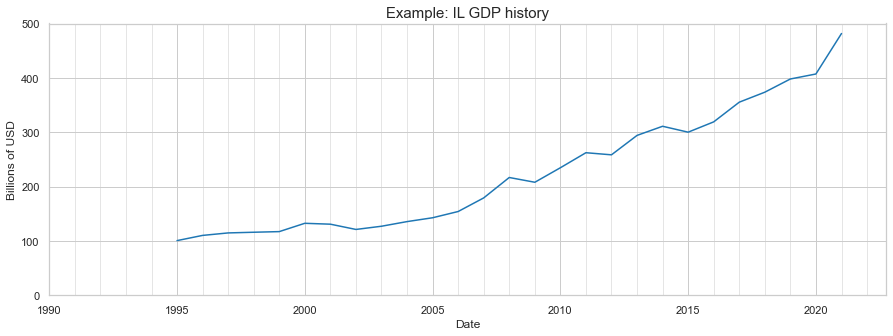

In [34]:
### WORLD BANK: WDI: GDP: EXAMPLES

### Data loading:
ser_full_gdp = pd.read_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset)
### Country data filtering:
str_country = 'IL'
ser_example = ser_full_gdp.loc[All, str_country] / 1000000000
display(ser_example[1::5])
### Resampling example to correct x-axis visualization:
ser_example_ys = ser_example.resample('YS').last()
### Plot initializaing:
df_to_plot = ser_example_ys.reset_index()
plt.figure(figsize = (15, 5))
sns.set_style('whitegrid')
sns.set_context('notebook')
ax_example = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Value')
ax_example.set(ylim = (0, 500), xlim = (date_start, date_end), ylabel = 'Billions of USD')
ax_example.set_title('Example: ' + str_country + ' GDP history', fontsize = 15)
### Major ticker options:    
ax_example.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_example.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_example.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_example.grid(visible = True, which = 'minor', linewidth = 0.5)      
### Plot drawing:
plt.show()

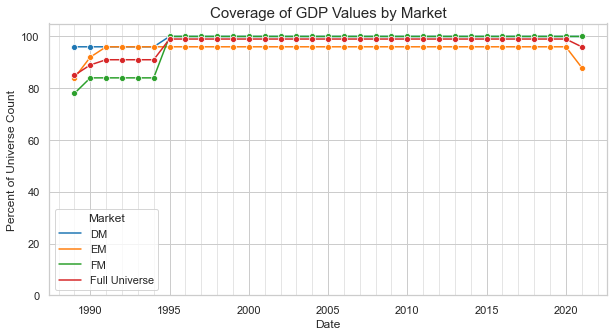

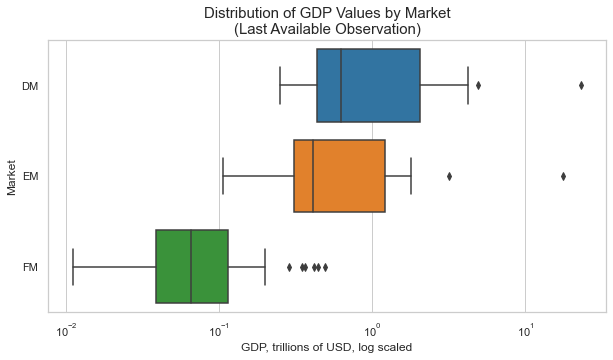

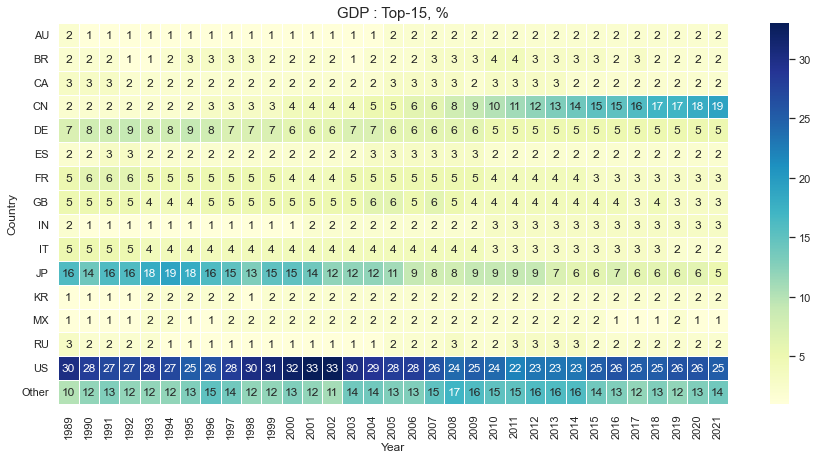

In [35]:
### WORLD BANK: WDI: GDP: DATA PRESENCE STATISTICS

### Data loading and ISONing
ser_full_gdp = pd.read_hdf(path_or_buf = str_path_wb_gdp_dataset, key = str_wb_gdp_dataset)
ser_ison_gdp = ser_full_gdp.to_frame().join(ser_ison_status).set_index('Market', append = True).squeeze().dropna()
### Calculating of coverage:
ser_gdp_count = ser_ison_gdp.groupby(['Date', 'Market']).count()
ser_gdp_count = pd.concat([ser_gdp_count, pd.concat({'Full Universe': ser_gdp_count.groupby('Date').sum()}, names = ['Market']).swaplevel()], axis = 0).sort_index()
ser_gdp_part = ((ser_gdp_count / ser_market_len).round(2) * 100).astype(int)
### Coverage plotting:
ser_gdp_part_ys = ser_gdp_part.unstack('Market').resample('YS').last().stack('Market')
ser_gdp_part_ys.name = 'Percentage'
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
df_to_plot = ser_gdp_part_ys.reset_index()
ax_coverage = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percentage', hue = 'Market', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_coverage.set_title('Coverage of GDP Values by Market', fontsize = 15)
ax_coverage.set(ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_coverage.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_coverage.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_coverage.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_coverage.grid(visible = True, which = 'minor', linewidth = 0.5)    
plt.show()   
### Distribution plotting:
df_to_plot = (ser_ison_gdp / 1000000000000).groupby(['Country', 'Market']).last().dropna().reset_index()
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_box = sns.boxplot(data = df_to_plot, x = 'Value', y = 'Market', order = list_regions)
ax_box.set_title('Distribution of GDP Values by Market' + '\n' + '(Last Available Observation)', fontsize = 15)
ax_box.set_xlabel('GDP, trillions of USD, log scaled')
ax_box.set_xscale('log')
plt.show()
### Largest / smallest values preparation:
int_n_countries = 15
int_n_years = 10
ser_ison_mean = ser_ison_gdp.loc[ser_ison_gdp.index.levels[0][-int_n_years : ]].groupby('Country').mean().dropna().sort_values(ascending = False)
### Leaders data preparation:
#ser_ison_largest = ser_ison_gdp.loc[All, ser_ison_mean[: int_n_countries].index, All].droplevel('Market') 
#df_ison_largest = ser_ison_gdp.loc[All, ser_ison_mean[: int_n_countries].index, All].droplevel('Market').reset_index()
df_country_part = (ser_ison_gdp / ser_ison_gdp.groupby('Date').sum()).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Country', 'Market']).drop('Date', axis = 1).squeeze().sort_index()
ser_ison_largest = ser_country_part.loc[All, ser_ison_mean[: int_n_countries].index, All].droplevel('Market') * 100
ser_ison_other = ser_country_part.loc[All, ser_ison_mean[int_n_countries : ].index, All].droplevel('Market')
ser_ison_other = ser_ison_other.groupby('Year').sum() * 100
ser_ison_other = pd.concat({'Other': ser_ison_other[ser_ison_other > 0]}, names = ['Country']).swaplevel()
### Data aggregation:
df_to_plot = pd.concat([ser_ison_largest.unstack('Year').sort_index(), ser_ison_other.unstack('Year')], axis = 0)
### Heatmap plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False,
                         annot = True, fmt = '.0f')
ax_heatmap.set_title('GDP' + ' : Top-' + str(int_n_countries) + ', %' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()    

In [52]:
### CEPII DISTANCES

In [53]:
### CEPII DISTANCES: DATA EXPORT AND REPACKING

### Constants:
str_path_cepii_source = 'Data_Files/Source_Files/CEPII Distance Data/dist_cepii.xls'
### Source data export:
df_distance_source = pd.read_excel(str_path_cepii_source, index_col = [0, 1])
### Long to Short Country ID's converting:
df_distance_data = df_distance_source.join(df_country_codes.set_index('ISO LONG').squeeze(), on = 'iso_o')
df_distance_data.rename({'ISO SHORT': 'From_ID'}, axis = 1, inplace = True)
df_distance_data = df_distance_data.join(df_country_codes.set_index('ISO LONG').squeeze(), on = 'iso_d')
df_distance_data.rename({'ISO SHORT': 'To_ID'}, axis = 1, inplace = True)
### ISON countries filtering:
list_ison_countries = ser_ison_membership.index.get_level_values(1).unique()
df_distance_data = df_distance_data.dropna().set_index(['From_ID', 'To_ID']).loc[(list_ison_countries, list_ison_countries), ['dist', 'distcap', 'distw', 'distwces']]
df_distance_data = df_distance_data.astype(int)
### Result saving:
df_distance_data.to_hdf(path_or_buf = str_path_cepii_dataset, key = str_distance_dataset, mode = 'w')

Example :
 From_ID  To_ID
AU       AU        1121
         US       14802
US       AU       14802
         US        1853
Name: distw, dtype: int32
Unique "From" countries number :
 83
ISON countries not in "From" :
 {'RO', 'RS'}
Unique "To" countries number :
 83
ISON countries not in "To" :
 {'RO', 'RS'}
NaN values number :
 0
Sample bilateral pairs number vs Theoretical bilateral pairs number :
 3403 vs 3403
Asymmetric bilateral distances :
 []
Maximal bilateral distance :
 From_ID  To_ID
EC       SG       19650
SG       EC       19650
Name: distw, dtype: int32
Minimal bilateral distance :
 From_ID  To_ID
IL       JO       114
JO       IL       114
Name: distw, dtype: int32
Maximal inner distance :
 From_ID  To_ID
US       US       1853
Name: distw, dtype: int32
Minimal inner distance :
 From_ID  To_ID
MT       MT       8
Name: distw, dtype: int32


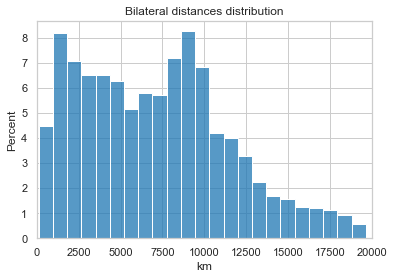

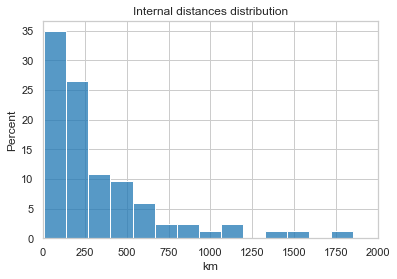

In [54]:
### CEPII DISTANCES: STATS

### Countries stats:
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
ser_dist = pd.read_hdf(path_or_buf = str_path_cepii_dataset, key = str_distance_dataset)['distw']
ser_dist_outer = ser_dist[ser_dist.index.get_level_values(0) != ser_dist.index.get_level_values(1)]
ser_dist_inner = ser_dist[ser_dist.index.get_level_values(0) == ser_dist.index.get_level_values(1)]
print('Example :\n', ser_dist.loc[['AU', 'US'], ['AU', 'US']])
set_from = set(ser_dist_outer.index.get_level_values(0))
set_to = set(ser_dist_outer.index.get_level_values(1))
print('Unique \"From\" countries number :\n', len(set_from))
print('ISON countries not in \"From\" :\n', set_ison_countries - set_from)
print('Unique \"To\" countries number :\n', len(set_to))
print('ISON countries not in \"To\" :\n', set_ison_countries - set_to)
print('NaN values number :\n', len(ser_dist[ser_dist.isna()]))
### Pairs stats:
print('Sample bilateral pairs number vs Theoretical bilateral pairs number :\n', len(ser_dist_outer) // 2, 'vs', len(set_from) * (len(set_from) - 1) // 2)
print('Asymmetric bilateral distances :\n', 
      [(iter_from, iter_to) for iter_from in set_from for iter_to in set_to if (ser_dist[iter_from, iter_to] != ser_dist[iter_to, iter_from])])
### Distances stats:
print('Maximal bilateral distance :\n', ser_dist_outer[ser_dist_outer == max(ser_dist_outer)])
print('Minimal bilateral distance :\n', ser_dist_outer[ser_dist_outer == min(ser_dist_outer)])
print('Maximal inner distance :\n', ser_dist_inner[ser_dist_inner == max(ser_dist_inner)])
print('Minimal inner distance :\n', ser_dist_inner[ser_dist_inner == min(ser_dist_inner)])
sns.set_style('whitegrid')
sns.set_context('notebook')
ax_outer = sns.histplot(ser_dist_outer.loc[sorted(list(itertools.combinations(set_from, 2)))].values, kde = False, stat = 'percent')
ax_outer.set_title('Bilateral distances distribution')
ax_outer.set(xlim = (0, 20000), xlabel = 'km')
plt.show()
ax_inner = sns.histplot(ser_dist_inner.values, kde = False, stat = 'percent')
ax_inner.set_title('Internal distances distribution')
ax_inner.set(xlim = (0, 2000), xlabel = 'km')
plt.show()

In [8]:
### IMF DOTS: BILATERAL EXPORTS & IMPORTS (MILLIONS OF USD)

In [9]:
### IMF DOTS: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 5
int_imf_country_limit = 30

In [10]:
### IMF DOTS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update(dict_request_headers)

In [11]:
### IMF DOTS: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_dots_id = ser_imf_dataflow[ser_imf_dataflow.str.endswith('(DOTS)')].index[0].replace('DS-', '')
print(str_imf_dots_id)

DOT


In [12]:
### IMF DOTS: DATASTRUCTURE SEARCHING

obj_imf_dots_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_dots_id).json()
df_imf_dots_params = pd.DataFrame(obj_imf_dots_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_dots_params)

        @conceptRef                @codelist @isFrequencyDimension
0              FREQ                  CL_FREQ                  true
1          REF_AREA              CL_AREA_DOT                   NaN
2         INDICATOR         CL_INDICATOR_DOT                   NaN
3  COUNTERPART_AREA  CL_COUNTERPART_AREA_DOT                   NaN


In [13]:
### IMF DOTS: CODES DESCRIPTION SEARCHING

for int_counter, str_param_code in enumerate(df_imf_dots_params['@codelist']):
    if (int_counter == 2):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_dots_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_dots_param =  pd.DataFrame(obj_imf_dots_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_dots_param = df_imf_dots_param.assign(Text = df_imf_dots_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        print(int_counter, ':', df_imf_dots_params.iloc[int_counter, All]['@conceptRef'], ':', str_param_code, ':\n', df_imf_dots_param)
    
str_dots_freq = 'M' # 'A' # 'B' # 
#str_dots_indicator = 
list_dots_indicator = ['TXG_FOB_USD', 'TMG_CIF_USD', 'TMG_FOB_USD', 'TBG_USD']
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))

2 : INDICATOR : CL_INDICATOR_DOT :
         @value                                               Text
0  TXG_FOB_USD  Goods, Value of Exports, Free on board (FOB), ...
1  TMG_CIF_USD  Goods, Value of Imports, Cost, Insurance, Frei...
2  TMG_FOB_USD  Goods, Value of Imports, Free on board (FOB), ...
3      TBG_USD          Goods, Value of Trade Balance, US Dollars


In [15]:
### TEMP

str_dots_full_url

'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/DOT/M.AE+AR+AT+AU+BD+BE+BG+BH+BR+BW+CA+CH+CI+CL+CN+CO+CR+CY+CZ+DE+DK+EC+EE+EG+ES+FI+FR+GB+GH+GR.TXG_FOB_USD.W00'

In [14]:
### IMF DOTS: INDICATORS EXTRACTION: WORLD EXPORT

dict_dots_bilateral = {} # Global container
str_dots_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_dots_id + '/' # Beginning of request URL
### Export Indicator defining:
str_dots_indicator = 'TXG_FOB_USD'
### Session initializing:
request_session = requests.Session()
request_session.headers.update(dict_request_headers)    
### List of bilateral dataframes for future concatenation
list_dots_bilateral = [] 
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_dots_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### World as a partner:
    str_dots_partners = 'W00'
    ### Generating complete request URL:
    str_dots_full_url = str_dots_const_url + '.'.join([str_dots_freq, str_dots_reporters, str_dots_indicator, str_dots_partners])
    ### Receiving DOTS dataset from IMF API:
    print(str_dots_indicator, '(WORLD) :', int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit)        
    obj_dots_set = request_session.get(str_dots_full_url)
    ### Data reading as JSON:
    dict_dots_set = json.loads(obj_dots_set.text)
    ### Converting each bilateral dataset to dataframe and it's mungling:
    for dict_dots_pair in dict_dots_set['CompactData']['DataSet']['Series']:
        if isinstance(dict_dots_pair['Obs'], list):
            df_dots_bilateral = pd.DataFrame(dict_dots_pair['Obs'])
        else:
            df_dots_bilateral = pd.DataFrame([dict_dots_pair['Obs']])
        ### Markers checking:
        if '@OBS_STATUS' not in df_dots_bilateral.columns:
            df_dots_bilateral['@OBS_STATUS'] = np.NaN
        ### Data extracting and mungling:
        df_dots_bilateral = df_dots_bilateral[['@TIME_PERIOD', '@OBS_VALUE', '@OBS_STATUS']]
        df_dots_bilateral.columns = ['Date', 'Value', 'Status']
        df_dots_bilateral = df_dots_bilateral.assign(Reporter_ID = dict_dots_pair['@REF_AREA'])
        df_dots_bilateral = df_dots_bilateral.assign(Partner_ID = dict_dots_pair['@COUNTERPART_AREA'])
        list_dots_bilateral.append(df_dots_bilateral)
        break
    break
### Flow level data aggregation:
df_dots_indicator = pd.concat(list_dots_bilateral, axis = 0, ignore_index = True)
df_dots_indicator['Date'] = pd.to_datetime(df_dots_indicator['Date']) + pd.offsets.BMonthEnd()
ser_dots_indicator = df_dots_indicator.set_index(['Date', 'Reporter_ID']).drop(['Partner_ID', 'Status'], axis = 1).squeeze().astype(float)
ser_dots_indicator.index.names = ['Date', 'Reporter']
ser_dots_indicator.name = 'World_Export'
### Dataset saving:
#ser_dots_indicator.to_hdf(path_or_buf = str_path_imf_dots_world, key = str_full_imf_dots_world, mode = 'w', format = 'fixed')
gc.collect()

TXG_FOB_USD (WORLD) : 0 - 30


0

In [14]:
### IMF DOTS: INDICATORS EXTRACTION: BILATERAL FLOWS

dict_dots_bilateral = {} # Global container
str_dots_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_dots_id + '/' # Beginning of request URL
### Looping for DOTS Indicators:
for str_dots_indicator in list_dots_indicator[: 2]:
    ### Session initializing:
    request_session = requests.Session()
    request_session.headers.update(dict_request_headers)    
    ### List of bilateral dataframes for future concatenation
    list_dots_bilateral = [] 
    ### Looping for reporter country groups:
    for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_dots_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
        ### Looping for partner country groups:
        for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
            str_dots_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit]) 
            ### Generating complete request URL:
            str_dots_full_url = str_dots_const_url + \
                                '.'.join([str_dots_freq, str_dots_reporters, str_dots_indicator, str_dots_partners])
            ### Receiving DOTS dataset from IMF API:
            print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
                  int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit, ' / ', str_dots_indicator)
            obj_dots_set = request_session.get(str_dots_full_url)
            ### Data reading as JSON:
            dict_dots_set = json.loads(obj_dots_set.text)
            ### Converting each bilateral dataset to dataframe and it's mungling:
            for dict_dots_pair in dict_dots_set['CompactData']['DataSet']['Series']:
                if isinstance(dict_dots_pair['Obs'], list):
                    df_dots_bilateral = pd.DataFrame(dict_dots_pair['Obs'])
                else:
                    df_dots_bilateral = pd.DataFrame([dict_dots_pair['Obs']])
                ### Markers checking:
                if '@OBS_STATUS' not in df_dots_bilateral.columns:
                    df_dots_bilateral['@OBS_STATUS'] = np.NaN
                ### Data extracting and mungling:
                df_dots_bilateral = df_dots_bilateral[['@TIME_PERIOD', '@OBS_VALUE', '@OBS_STATUS']]
                df_dots_bilateral.columns = ['Date', 'Value', 'Status']
                df_dots_bilateral = df_dots_bilateral.assign(Reporter_ID = dict_dots_pair['@REF_AREA'])
                df_dots_bilateral = df_dots_bilateral.assign(Partner_ID = dict_dots_pair['@COUNTERPART_AREA'])
                list_dots_bilateral.append(df_dots_bilateral)
#            break
#        break
    ### Flow level data aggregation:
    df_dots_indicator = pd.concat(list_dots_bilateral, axis = 0, ignore_index = True)
    df_dots_indicator['Date'] = pd.to_datetime(df_dots_indicator['Date']) + pd.offsets.BMonthEnd()
    df_dots_indicator = df_dots_indicator.set_index(['Date', 'Reporter_ID', 'Partner_ID'])                
    dict_dots_bilateral[str_dots_indicator] = df_dots_indicator
    del df_dots_indicator
    gc.collect()
### Full data aggregation:
df_dots_result = pd.concat(dict_dots_bilateral, axis = 1)
del dict_dots_bilateral
gc.collect()
### Structure optimization:
df_dots_flows = df_dots_result.iloc[All, [0, 2]]
del df_dots_result
gc.collect()
df_dots_flows.columns = ['Export', 'Import']
df_dots_flows = df_dots_flows.reset_index().melt(id_vars = ['Date', 'Reporter_ID', 'Partner_ID'], var_name = 'Flow', value_name = 'Value')
df_dots_flows.rename({'Reporter_ID': 'Reporter', 'Partner_ID': 'Partner'}, axis = 1, inplace = True)
df_dots_flows = df_dots_flows.astype({'Reporter': 'category', 'Partner': 'category', 'Flow': 'category', 'Value': float})
### Dataset saving:
df_dots_flows.to_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset, mode = 'w', format = 'table')
del df_dots_flows
gc.collect()

0 - 30  /  0 - 30  /  TXG_FOB_USD
0 - 30  /  30 - 60  /  TXG_FOB_USD
0 - 30  /  60 - 90  /  TXG_FOB_USD
30 - 60  /  0 - 30  /  TXG_FOB_USD
30 - 60  /  30 - 60  /  TXG_FOB_USD
30 - 60  /  60 - 90  /  TXG_FOB_USD
60 - 90  /  0 - 30  /  TXG_FOB_USD
60 - 90  /  30 - 60  /  TXG_FOB_USD
60 - 90  /  60 - 90  /  TXG_FOB_USD
0 - 30  /  0 - 30  /  TMG_CIF_USD
0 - 30  /  30 - 60  /  TMG_CIF_USD
0 - 30  /  60 - 90  /  TMG_CIF_USD
30 - 60  /  0 - 30  /  TMG_CIF_USD
30 - 60  /  30 - 60  /  TMG_CIF_USD
30 - 60  /  60 - 90  /  TMG_CIF_USD
60 - 90  /  0 - 30  /  TMG_CIF_USD
60 - 90  /  30 - 60  /  TMG_CIF_USD
60 - 90  /  60 - 90  /  TMG_CIF_USD


73

In [9]:
### IMF DOTS: DATA LOADING

df_dots_flows = pd.read_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset)
df_dots_export = df_dots_flows[(df_dots_flows['Flow'] == 'Export') & (df_dots_flows['Date'] > date_start) & (df_dots_flows['Date'] <= date_end)].dropna()

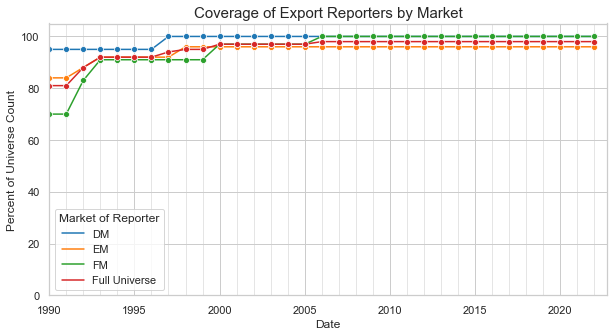

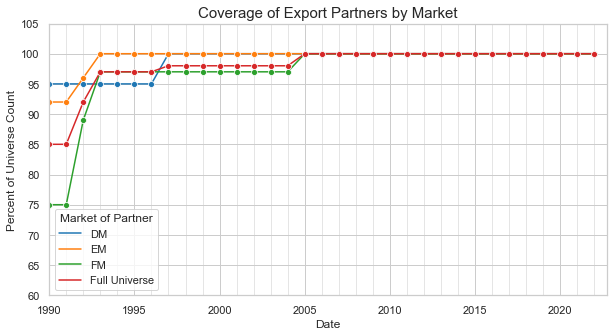

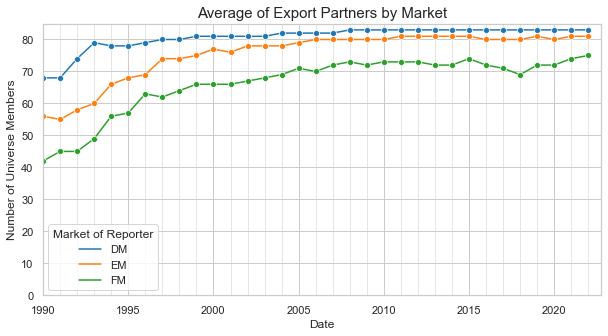

In [42]:
### IMF DOTS: STATS: EXPORT COVERAGE: PARTICIPANTS NUMBER

gc.collect()
### Adding regions of reporters and partners:
ser_ison_status.index.names = ['Country']
df_coverage_full = df_dots_export.merge(ser_ison_status, left_on = 'Reporter', right_on = 'Country').merge(ser_ison_status, left_on = 'Partner', right_on = 'Country')
df_coverage_full.rename({'Market_x': 'Reporter_Market', 'Market_y': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.dropna().unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.dropna().unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Coverage of Export Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
ser_iter_partners.name = 'Percent'
### Region's partners number:
dict_partners['Full Universe']  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
    ser_iter_partners.name = 'Percent'
    dict_partners[iter_region]  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Partner', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_partners.set_title('Coverage of Export Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (60, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Percent'
#    dict_ave_partners[iter_region] = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
    dict_ave_partners[iter_region] = ser_iter_partners.resample('BY').last().dropna().astype(int)    
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions, marker = 'o')
ax_partners.set_title('Average of Export Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 85), ylabel = 'Number of Universe Members')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

IMF Export: Total ISON Reporters number: 84
IMF Export: Absent countries: {'TW'}


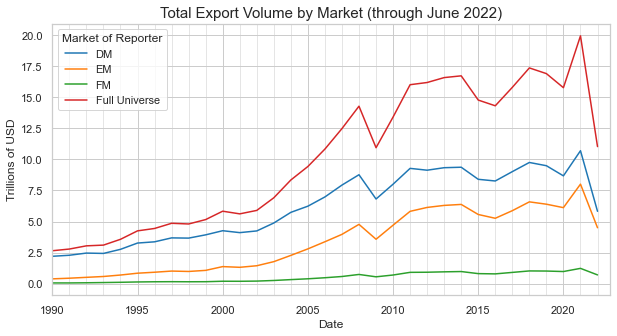

In [49]:
### IMF DOTS: STATS: EXPORT VOLUME

gc.collect()
print('IMF Export: Total ISON Reporters number:', str(len(df_dots_export['Reporter'].unique())))
print('IMF Export: Absent countries:', (set(ser_ison_status.index) - set(df_dots_export['Reporter'].unique())))
### Total export volume calculation start:
ser_dots_export_ann = df_dots_export.groupby(['Reporter', 'Partner']).apply(lambda df_group: df_group.set_index('Date').resample('BY').sum())\
                                    .squeeze().reorder_levels([2, 0, 1])
ser_dots_export_ann = ser_dots_export_ann[ser_dots_export_ann > 0.0]
dict_total_volume = {}
### ISON total volume:
ser_total_volume = ser_dots_export_ann.dropna().groupby('Date').sum() / 1000000
dict_total_volume['Full Universe'] = ser_total_volume
ser_ison_status.index.names = ['Reporter']
df_dots_export_isoned = ser_dots_export_ann.dropna().to_frame().join(ser_ison_status, on = 'Reporter')
### Region's total volume:
for iter_region in list_regions:
    ser_iter_volume = df_dots_export_isoned[df_dots_export_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000
    dict_total_volume[iter_region] = ser_iter_volume
### Data consolidating:    
df_volume = pd.concat(dict_total_volume).unstack(0).resample('YS').last().stack(0).reset_index()
df_volume.columns = ['Date', 'Market of Reporter', 'Volume']
df_to_plot = df_volume[df_volume['Date'] < date_end]
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Volume', hue = 'Market of Reporter', hue_order = ['DM', 'EM', 'FM', 'Full Universe'])
ax_total.set_title('Total Export Volume by Market (through June 2022)', fontsize = 15)
ax_total.set(xlim = (date_start, date_end), ylabel = 'Trillions of USD')
### Major ticker options:    
ax_total.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_total.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_total.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_total.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

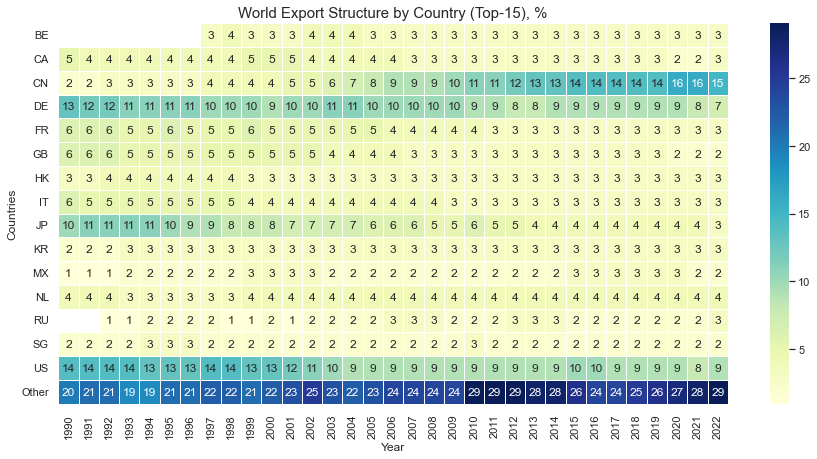

In [50]:
### IMF DOTS: STATS: EXPORT LEADERS

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Stats parameter - years to define leaders:
int_term = 10
### Country trade proprotion for each date:
ser_country_value = ser_dots_export_ann.groupby(['Date', 'Reporter']).sum().dropna() / 1000000
df_country_part = (ser_country_value / ser_total_volume).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze().sort_index()
### Limited by term country trade volume:
ser_country_sum = ser_country_value.groupby('Reporter').apply(lambda ser_group: ser_group.iloc[-int_term :].sum()).sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other[ser_country_other > 0]}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f')
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Export Structure by Country (Top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()   

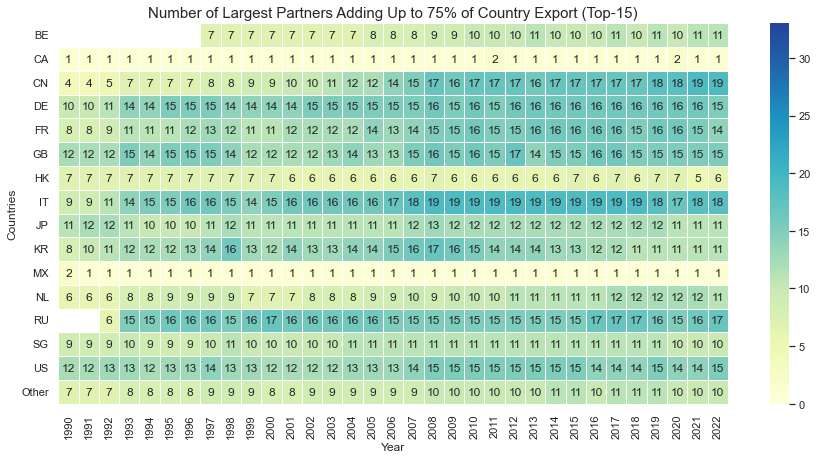

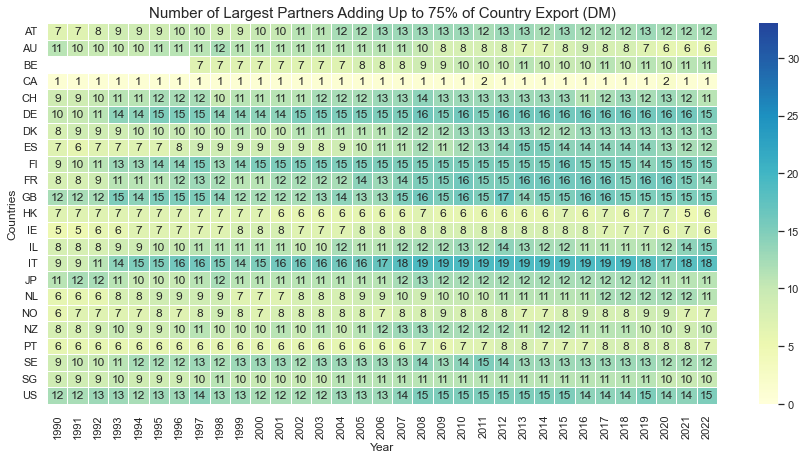

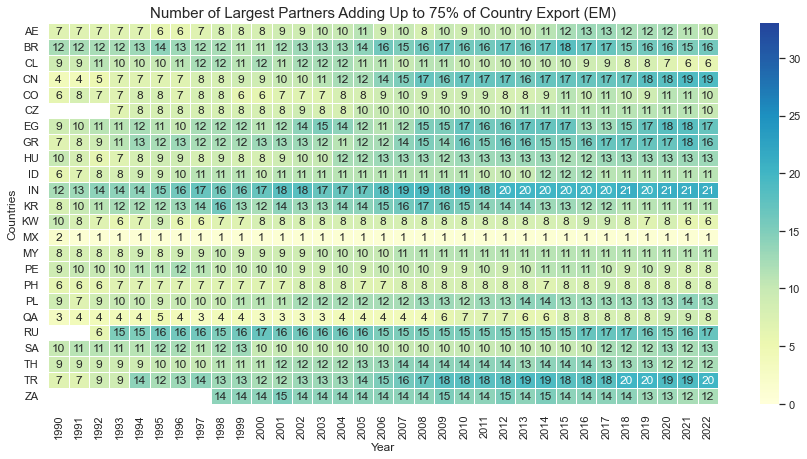

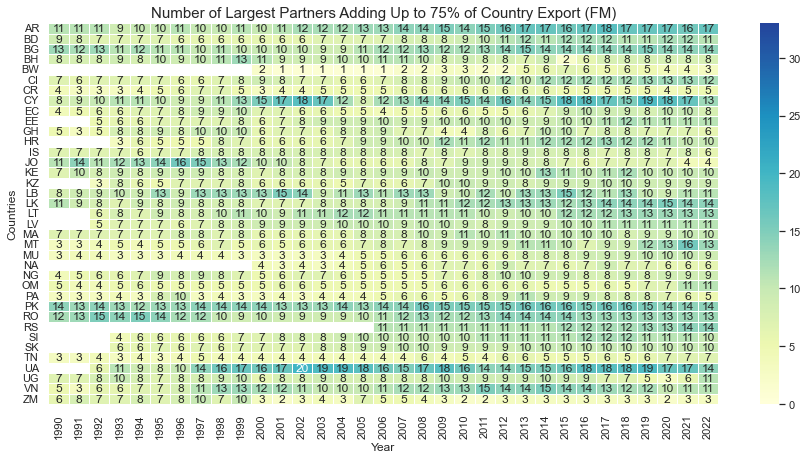

In [13]:
### IMF DOTS: STATS: NUMBER OF PARTNERS TO COMPLETE FIXED % OF EXPORT FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(ser_group, flo_perc):
    ser_by_partner = ser_group.groupby(['Date', 'Partner']).sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.75
### Stats parameter - leaders to plot:
int_top = 15
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Partners number calculation for each Date / Reporter pair:
ser_partners = ser_dots_export_ann.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).dropna().astype(int)
ser_partners.name = 'Number'
df_partners = ser_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Leaders data extraction for leaders plot:
df_top_part = df_partners[df_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_partners[df_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Export (Top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_regions:
    ### Data extraction:    
    df_to_plot = df_partners.loc[df_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Export (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

In [9]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

gc.collect()
### Data loading:
df_dots_flows = pd.read_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset)
df_dots_flows = df_dots_flows[(df_dots_flows['Date'] > date_start) & (df_dots_flows['Date'] <= date_end)].dropna()
ser_export = df_dots_flows.loc[df_dots_flows['Flow'] == 'Export'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
ser_export_ann = ser_export.groupby(['Reporter', 'Partner', 'Flow'])\
                           .apply(lambda ser_group: ser_group.droplevel(['Reporter', 'Partner', 'Flow']).resample('BY').sum()).reorder_levels([3, 0, 1, 2])
ser_import = df_dots_flows.loc[df_dots_flows['Flow'] == 'Import'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
ser_import_ann = ser_import.groupby(['Reporter', 'Partner', 'Flow'])\
                           .apply(lambda ser_group: ser_group.droplevel(['Reporter', 'Partner', 'Flow']).resample('BY').sum()).reorder_levels([3, 0, 1, 2])
### Data concatenation:
ser_flows = pd.concat([ser_export, ser_import], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()
ser_flows_ann = pd.concat([ser_export_ann, ser_import_ann], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()

In [ ]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Average partners number for Date / Reporter:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Flow', 'Market']).count()
dict_obs_mean['Full Universe'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_regions:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Flow']).resample('YS').last()\
                                                                               .stack(['Market of Reporter', 'Reporter', 'Flow']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style configuration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Value', hue = 'Flow', ci = None)
    ax_partners.set_title('Average Number of Partners by Flow (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (35, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break
print('Number of observations for each flow:', '\n', ser_flows.unstack('Flow').count())

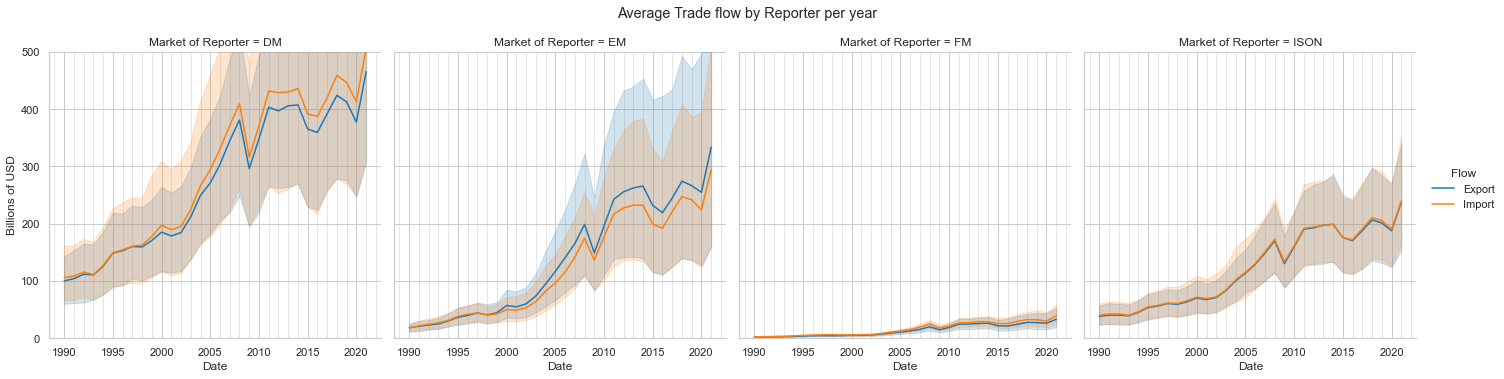

In [20]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: VOLUME COMPARING

gc.collect()
### Trade volume calculation:
dict_obs_sum = {}
ser_reporter_sum = ser_flows_ann.groupby(['Date', 'Reporter', 'Flow', 'Market']).sum() / 1000
dict_obs_sum['Full Universe'] = ser_reporter_sum.round(0)[ser_reporter_sum > 0].droplevel('Market').round(2).dropna()
for iter_region in list_regions:
    dict_obs_sum[iter_region] = ser_reporter_sum[ser_reporter_sum > 0].loc[All, All, All, iter_region].round(2).dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_sum, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Flow']).resample('YS').last()\
                                                                              .stack(['Market of Reporter', 'Reporter', 'Flow']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Market of Reporter', hue = 'Flow', kind = 'line')
fig_mean_obs.fig.suptitle('Average Trade flow by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Billions of USD')
fig_mean_obs.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_obs.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [108]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()
### Data loading:
df_dots_flows = pd.read_hdf(path_or_buf = str_path_imf_dots_dataset, key = str_full_imf_dots_dataset)
df_dots_flows = df_dots_flows[(df_dots_flows['Date'] > date_start) & (df_dots_flows['Date'] <= date_end)].dropna()
ser_export = df_dots_flows.loc[df_dots_flows['Flow'] == 'Export'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
ser_import = df_dots_flows.loc[df_dots_flows['Flow'] == 'Import'].set_index(['Date', 'Reporter', 'Partner', 'Flow']).squeeze()
del df_dots_flows
gc.collect()
### Data aggregation:
ser_import_rev = ser_import[:]
ser_import_rev.index.set_names('Partner_Inv', level = 1, inplace = True)
ser_import_rev.index.set_names('Reporter', level = 2, inplace = True)
ser_import_rev.index.set_names('Partner', level = 1, inplace = True)
ser_import_rev = ser_import_rev.swaplevel('Reporter', 'Partner').sort_index()
df_export_aug = pd.concat([ser_export.droplevel('Flow'), ser_import_rev.droplevel('Flow')], axis = 1, 
                           names = 'Source Flow', keys = ['Export', 'Import'])
df_export_aug = df_export_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_export_aug = df_export_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')

In [121]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: ANNUAL DATA PREPARATION

gc.collect()
dict_export_aug_ann = {}
dict_export_aug_ann['Export'] = df_export_aug['Export'].groupby(['Reporter', 'Partner', 'Market'])\
                                                       .apply(lambda df_group: df_group.droplevel(['Reporter', 'Partner', 'Market']).resample('BY').sum())\
                                                       .replace({0.0: np.NaN}).dropna().reorder_levels([3, 0, 1, 2]).sort_index()
dict_export_aug_ann['Import'] = df_export_aug['Import'].groupby(['Reporter', 'Partner', 'Market'])\
                                                       .apply(lambda df_group: df_group.droplevel(['Reporter', 'Partner', 'Market']).resample('BY').sum())\
                                                       .replace({0.0: np.NaN}).dropna().reorder_levels([3, 0, 1, 2]).sort_index()
df_export_aug_ann = pd.concat(dict_export_aug_ann, axis = 1)
del dict_export_aug_ann

In [122]:
### TEMP

display(df_export_aug.loc[('2021', 'ZM', 'ZA', All), All].sum())
display(df_export_aug_ann.loc[('2021-12-31', 'ZM', 'ZA', All), All])

Export    285.268645
Import    259.143804
dtype: float64

Export      Import
Date       Reporter Partner Market                        
2021-12-31 ZM       ZA      FM      285.268645  259.143804

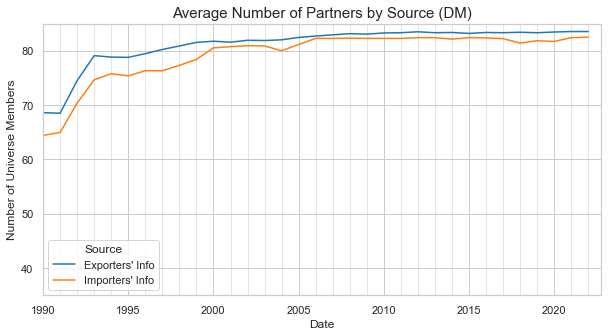

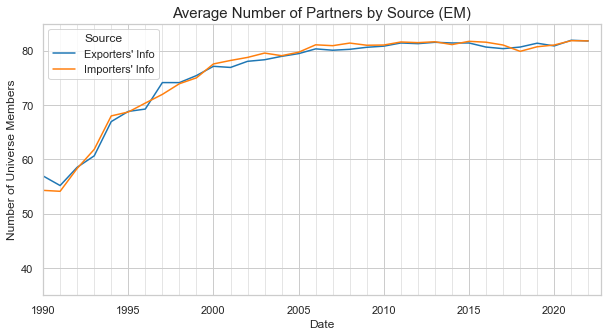

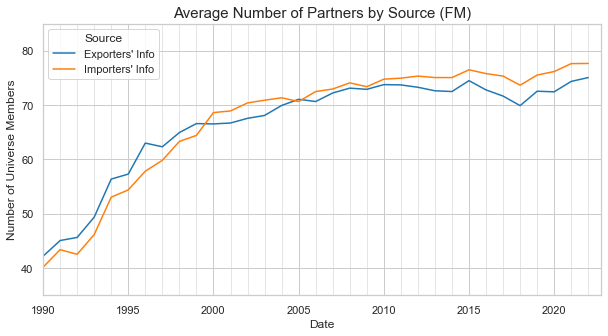

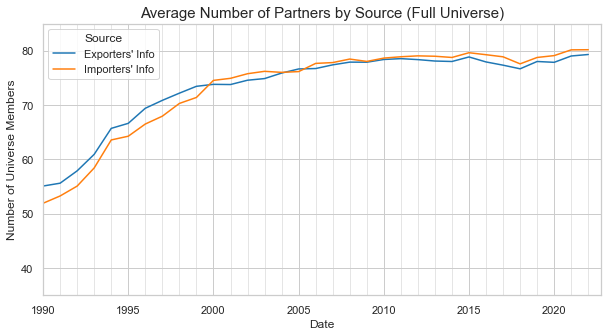

In [109]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Coverage data container:
dict_unique_mean = {}
### Partners number calculation:
dict_unique_mean['Exporters\' Info'] = df_export_aug['Export'].groupby(['Date', 'Reporter', 'Market']).count()
dict_unique_mean['Importers\' Info'] = df_export_aug['Import'].groupby(['Date', 'Reporter', 'Market']).count()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source']).round(0).astype(int)
ser_unique_mean = ser_unique_mean[ser_unique_mean > 0.0]
ser_unique_mean.name = 'Number of Partners'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source']).resample('YS').last()\
                                                                                    .stack(['Market of Exporter', 'Reporter']).dropna(how = 'all')\
                                                                                    .stack('Source').reset_index()
df_to_plot.rename({0: 'Number of Partners'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Exporter'] == iter_region], x = 'Date', y = 'Number of Partners', hue = 'Source', ci = None)
    ax_partners.set_title('Average Number of Partners by Source (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (35, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

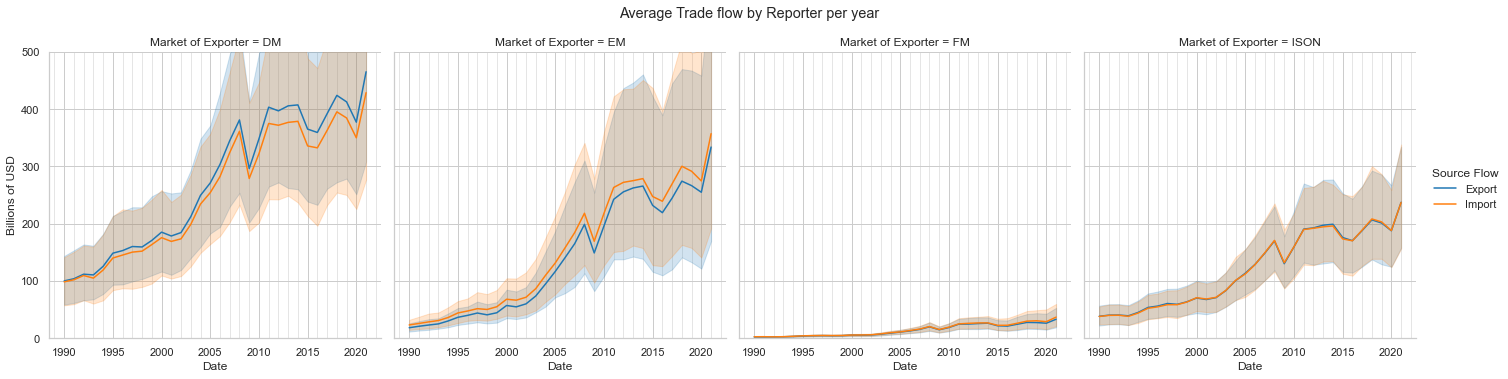

In [25]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: TOTAL OBSERVATIONS VOLUME

gc.collect()
### Valome calculation:
dict_unique_sum = {}
dict_unique_sum['Export'] = df_export_aug_ann['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Import'] = df_export_aug_ann['Import'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Flow']).round(2)
ser_unique_sum.name = 'Export volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                              .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Export volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export volume', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average Trade flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

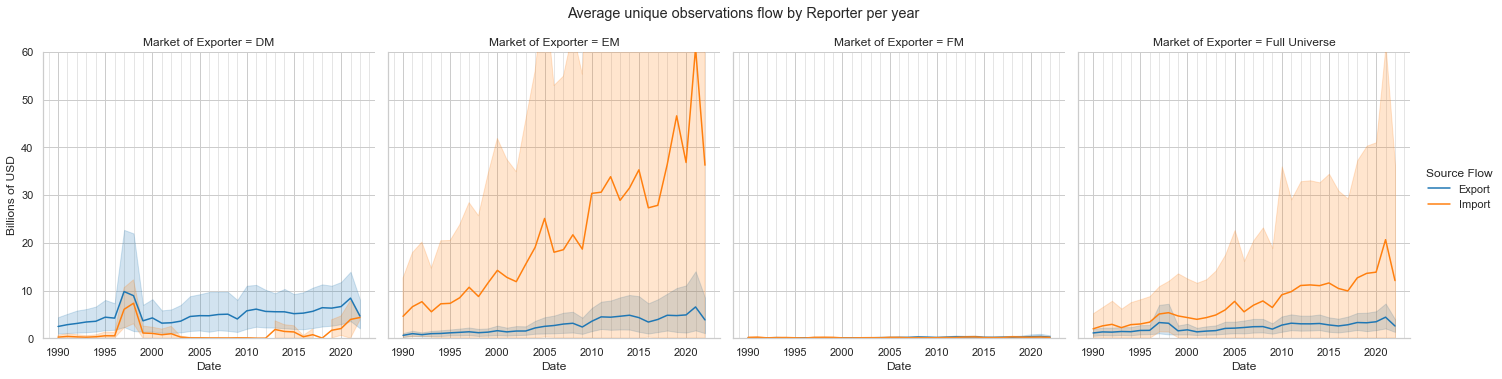

In [29]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: UNIQUE OBSERVATIONS VOLUME

gc.collect()

dict_unique_sum = {}
dict_unique_sum['Export'] = df_export_aug.loc[df_export_aug['Export'].notna() & df_export_aug['Import'].isna(), 'Export']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Export'] = dict_unique_sum['Export'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])   
dict_unique_sum['Import'] = df_export_aug.loc[df_export_aug['Export'].isna() & df_export_aug['Import'].notna(), 'Import']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Import'] = dict_unique_sum['Import'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market']) 
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Flow']).round(2)
ser_unique_sum.name = 'Export volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                              .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Export volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export volume', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_unique.fig.suptitle('Average unique observations flow by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 60))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

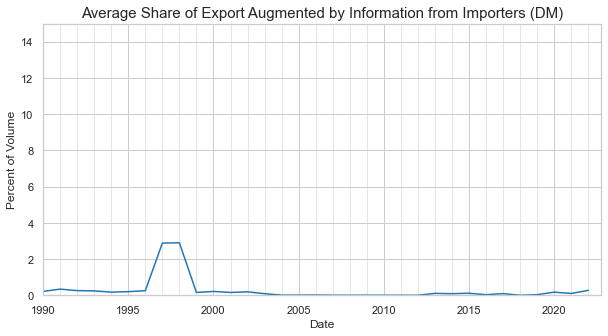

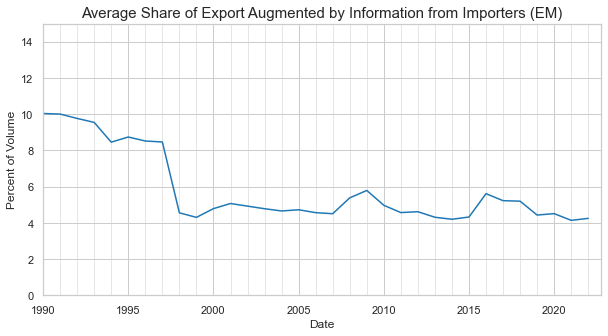

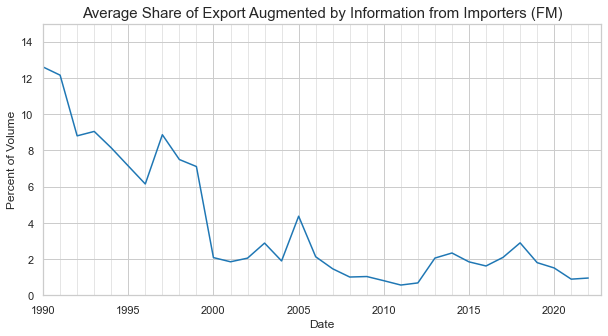

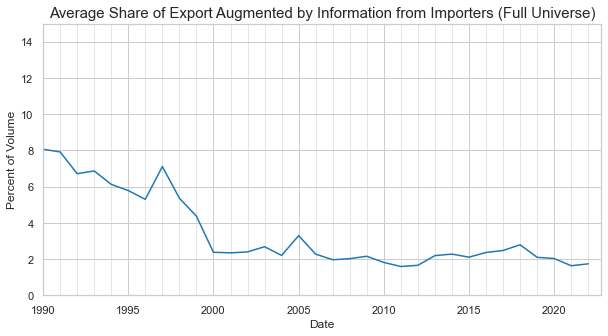

In [127]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: UNIQUE INVERTED IMPORT VOLUME

gc.collect()
### Unique inverted import data filtering:
ser_import_unique = df_export_aug.loc[df_export_aug['Export'].isna() & df_export_aug['Import'].notna(), 'Import']\
                                 .groupby(['Date', 'Reporter', 'Market']).sum()
ser_import_unique_ann = ser_import_unique.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_import_unique_ann.name = 'Added Volume'
### Unique inverted import by Market grouping:
dict_unique_import = {}
dict_unique_import['Full Universe'] = ser_import_unique_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_import[iter_region] = ser_import_unique_ann.loc[All, All, iter_region].dropna()
ser_import_isoned = pd.concat(dict_unique_import, axis = 0, names = ['Market of Exporter'])
### Total export data filtering:
ser_export_total = df_export_aug['Export'].groupby(['Date', 'Reporter', 'Market']).sum()
ser_export_total_ann = ser_export_total.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_export_total_ann.name = 'Export Volume'
### Total export by Market grouping:
dict_export_total = {}
dict_export_total['Full Universe'] = ser_export_total_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_export_total[iter_region] = ser_export_total_ann.loc[All, All, iter_region].dropna()
ser_export_isoned = pd.concat(dict_export_total, axis = 0, names = ['Market of Exporter'])
### Share of Export Augmented by Information from Importers:
ser_share = (ser_import_isoned.fillna(0) / (ser_import_isoned.fillna(0) + ser_export_isoned.fillna(0)) * 100).round(2)
### Dataset to draw:
df_to_plot = ser_share.unstack(['Market of Exporter', 'Reporter']).resample('YS').last().stack(['Market of Exporter', 'Reporter']).reset_index()
df_to_plot.rename({0: 'Share Added'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_share = sns.lineplot(data = df_to_plot[df_to_plot['Market of Exporter'] == iter_region], x = 'Date', y = 'Share Added', ci = None)
    ax_share.set_title('Average Share of Export Augmented by Information from Importers (' + iter_region + ')', fontsize = 15)
    ax_share.set(xlim = (date_start, date_end), ylabel = 'Percent of Volume', ylim = (0, 15))
    ### Major ticker options:    
    ax_share.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_share.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_share.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_share.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()

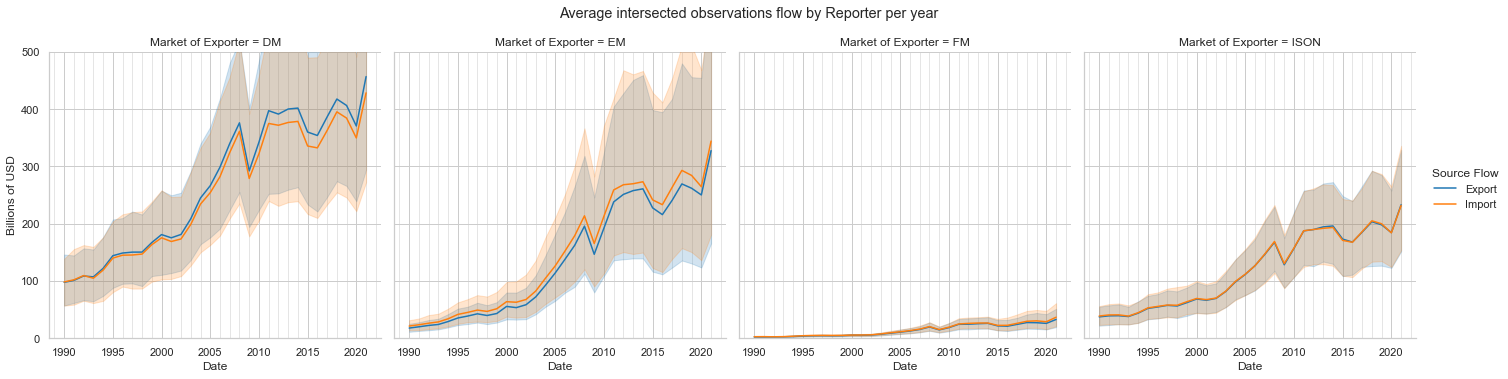

In [27]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS VOLUME

gc.collect()

dict_inter_sum = {}
dict_inter_sum['Export'] = df_export_aug.dropna()['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_inter_sum['Export'] = dict_inter_sum['Export'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
dict_inter_sum['Import'] = df_export_aug.dropna()['Import'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_inter_sum['Import'] = dict_inter_sum['Import'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_inter_sum = pd.concat(dict_inter_sum, axis = 0, names = ['Source Flow']).round(2)
ser_inter_sum.name = 'Export volume'
del dict_inter_sum
gc.collect()
dict_inter_source = {}
dict_inter_source['Full Universe'] = ser_inter_sum[ser_inter_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_inter_source[iter_region] = ser_inter_sum[ser_inter_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_inter_source, axis = 0, names = ['Market of Exporter']).unstack(['Market of Exporter', 'Reporter', 'Source Flow']).resample('YS').last()\
                                                                                   .stack(['Market of Exporter', 'Reporter', 'Source Flow']).reset_index()
df_to_plot.rename({0: 'Export volume'}, axis = 1, inplace = True)
fig_mean_inter = sns.relplot(data = df_to_plot, x = 'Date', y = 'Export volume', col = 'Market of Exporter', hue = 'Source Flow', kind = 'line')
fig_mean_inter.fig.suptitle('Average intersected observations flow by Reporter per year', y = 1.05)
fig_mean_inter.set_ylabels('Billions of USD')
fig_mean_inter.set(ylim = (0, 500))
### Axes customizing:
for iter_ax in fig_mean_inter.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)
plt.show()

In [28]:
### TEMP

gc.collect()
#print(ser_inter_sum[ser_inter_sum > 0.0].sum())
#print(ser_unique_sum[ser_unique_sum > 0.0].sum())
ser_inter_exp = df_export_aug.dropna()['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_inter_exp = ser_inter_exp.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_total_exp = df_export_aug_ann['Export'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = df_export_aug.loc[df_export_aug['Export'].notna() & df_export_aug['Import'].isna(), 'Export']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = ser_unique_exp.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
print('Total:', ser_total_exp.sum())
print('Intersected:', ser_inter_exp.sum())
print('Unique:', ser_unique_exp.sum())
print('Sum:', ser_inter_exp.sum() + ser_unique_exp.sum())
print('Unique:', ser_unique_exp.sum() / ser_total_exp.sum() * 100)


Total: 322921.11998766
Intersected: 316996.6950980726
Unique: 5924.424889587394
Sum: 322921.11998766
Unique: 1.8346353096427352


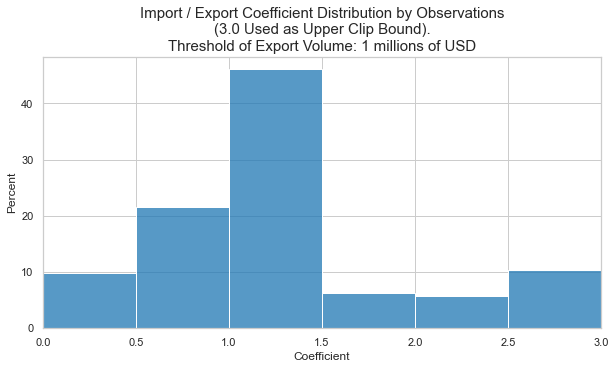

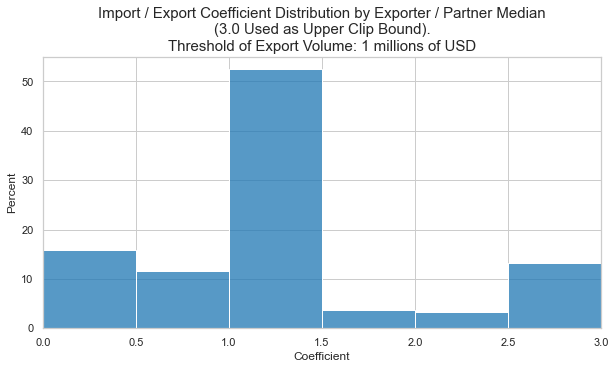

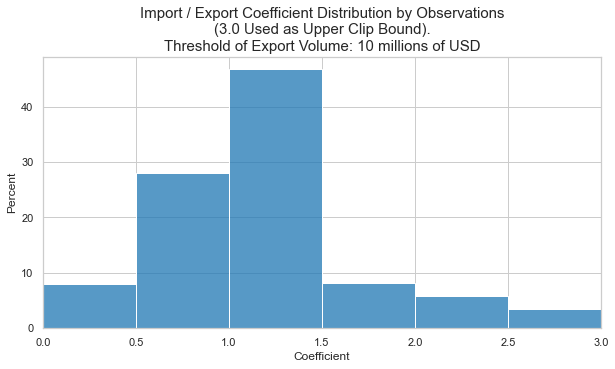

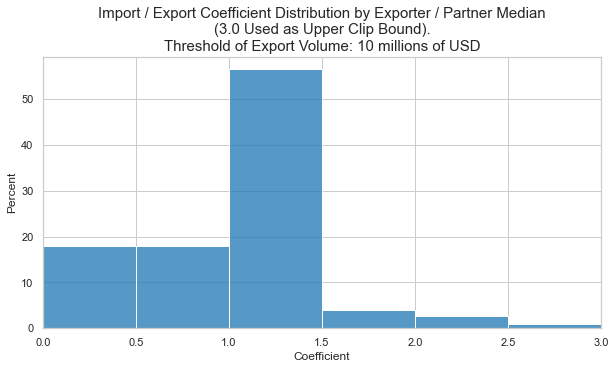

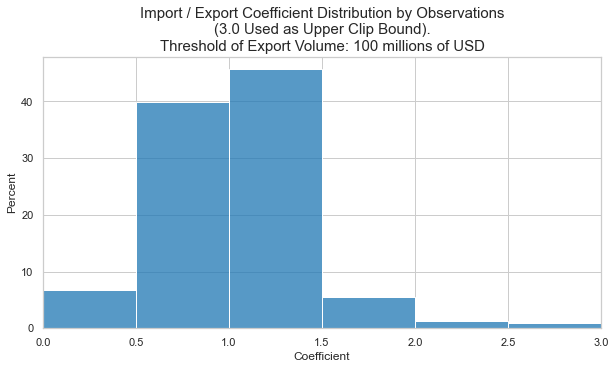

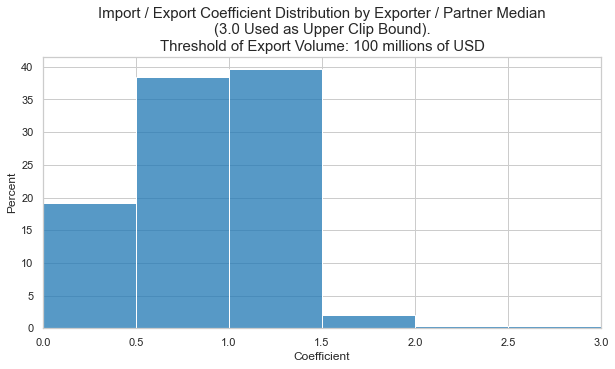

In [89]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS ANALYSIS

gc.collect()
### Data preparation:
list_threshold = [1, 10, 100]
for iter_threshold in list_threshold:
    df_inter_aug = (df_export_aug[df_export_aug['Export'] > iter_threshold].dropna() / 1000).round(2)
    ### Observations with the largest absolute difference between sources:
    df_inter_aug['Difference'] = (df_inter_aug['Export'] - df_inter_aug['Import']).abs()
    df_inter_aug.loc[df_inter_aug['Difference'].nlargest(20).index]
    ### Import / Export Coefficient distribution by observation:
    flo_upper_bound = 3.0
    df_inter_aug['Coefficient'] = (df_inter_aug['Import'] / df_inter_aug['Export']).round(2).clip(upper = flo_upper_bound)
    df_to_plot = df_inter_aug.dropna()['Coefficient'].reset_index()
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    plt.figure(figsize = (10, 5))
    ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
    ax_coeff_dist.set_title('Import / Export Coefficient Distribution by Observations\n' + 
                            '(' + str(flo_upper_bound) + ' Used as Upper Clip Bound).\n' + 
                            'Threshold of Export Volume: ' + str(iter_threshold) + ' millions of USD', fontsize = 15)
    ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
    plt.show()
    ### Import / Export Coefficient distribution by Exporter / Partner / Commodity averages:
    flo_upper_bound = 3.0
    df_to_plot = df_inter_aug.dropna().groupby(['Reporter', 'Partner'])['Coefficient'].median().reset_index()
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    plt.figure(figsize = (10, 5))
    ax_coeff_dist = sns.histplot(data = df_to_plot, x = 'Coefficient', stat = 'percent', bins = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, flo_upper_bound])
    ax_coeff_dist.set_title('Import / Export Coefficient Distribution by Exporter / Partner Median\n' + '(' \
                            + str(flo_upper_bound) + ' Used as Upper Clip Bound).\n' + 
                            'Threshold of Export Volume: ' + str(iter_threshold) + ' millions of USD', fontsize = 15)
    ax_coeff_dist.set(xlim = (0.0, flo_upper_bound))
    plt.show()

In [90]:
### IMF DOTS: CIF COEFFICIENTS CALCULATION

gc.collect()

### Bounds to filter bilateral Import to Export ratio before median calculation:
flo_lower_bound = 1.0
flo_upper_bound = 2.0

### Bilateral median calculation procedure:
def get_obs_median(df_comm):
    ### Export to Import ratio:
    ser_obs_coeff = df_comm['Import'] / df_comm['Export']
    ### Ratio filtering:
    ser_obs_coeff = ser_obs_coeff.loc[(ser_obs_coeff >= flo_lower_bound) & (ser_obs_coeff <= flo_upper_bound)]
    ### Filtered timeseries median as a result:
    return round(ser_obs_coeff.median(), 2)

### Calulation CIF coefficient for all commodities:
ser_cif_median = df_export_aug.groupby(['Reporter', 'Partner']).apply(get_obs_median)
ser_cif_median.fillna(ser_cif_median.median(), inplace = True)
ser_cif_median.name = 'CIF_Coefficient'

In [91]:
### IMF DOTS: IMPORT DATA INCORPORATION:

### Adding CIF coefficients to dataset:
df_export_cif = df_export_aug.merge(ser_cif_median, left_index = True, right_index = True)
df_export_cif = df_export_cif.reorder_levels(['Date', 'Reporter', 'Partner', 'Market'])
### Import correction:
df_export_cif['Import_Corrected'] = df_export_cif['Import'] / df_export_cif['CIF_Coefficient']
### Combining Export & Import data:
df_export_cif['Export_Augmented'] = df_export_cif['Export'].combine_first(df_export_cif['Import_Corrected'])
df_export_cif.drop('CIF_Coefficient', axis = 1, inplace = True)

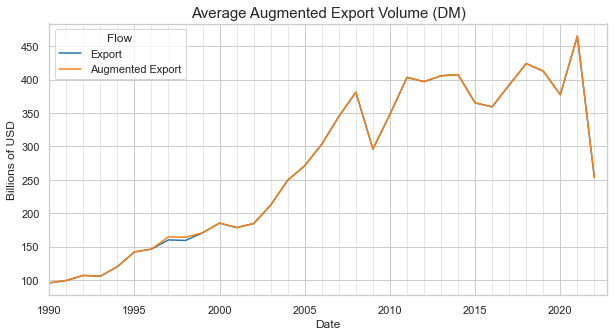

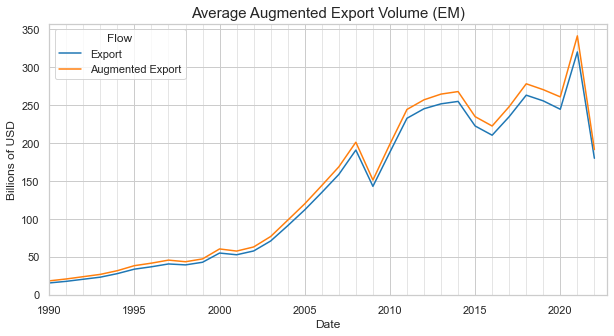

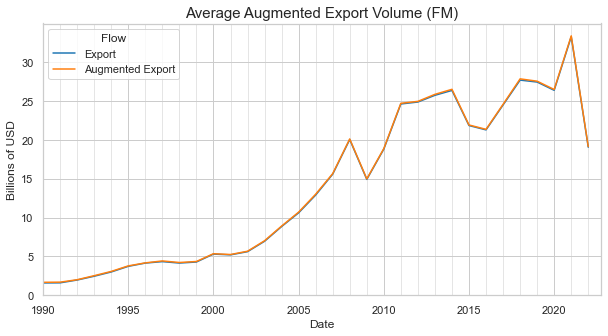

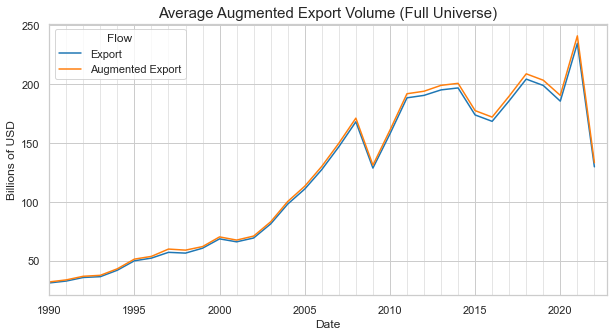

In [97]:
### IMF DOTS: IMPORT OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()
### Annualiziation:
dict_export_cif_ann = {}
for iter_flow in df_export_cif.columns:
    dict_export_cif_ann[iter_flow] = df_export_cif[iter_flow].unstack(['Reporter', 'Partner', 'Market']).resample('YS').sum().stack(['Reporter', 'Partner', 'Market'])
    dict_export_cif_ann[iter_flow].replace({0.0: np.NaN}, inplace = True)
df_export_cif_ann = pd.concat(dict_export_cif_ann, axis = 1)
df_options_sum = df_export_cif_ann.groupby(['Date', 'Reporter', 'Market']).sum() / 1000
df_options_sum.columns = ['Export', 'Import', 'Corrected Import', 'Augmented Export']
ser_options_sum = df_options_sum[['Export', 'Augmented Export']].reset_index()\
                                .melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Flow', value_name = 'Export_Volume')\
                                .set_index(['Date', 'Reporter', 'Market', 'Flow']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['Full Universe'] = ser_options_sum.dropna().droplevel('Market')
for iter_region in list_regions:
    dict_options_sum[iter_region] = ser_options_sum.dropna().loc[All, All, iter_region, All]
### Export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Exporter']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_volume = sns.lineplot(data = df_to_plot[df_to_plot['Market of Exporter'] == iter_region], x = 'Date', y = 'Export_Volume', hue = 'Flow', ci = None)
    ax_volume.set_title('Average Augmented Export Volume (' + iter_region + ')', fontsize = 15)
    ax_volume.set(xlim = (date_start, date_end), ylabel = 'Billions of USD')
    ### Major ticker options:    
    ax_volume.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_volume.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_volume.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_volume.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

In [98]:
### IMF DOTS: IMPORT DATA INCORPORATION: RESULTS SAVING

### Dataset saving:
df_export_cif = df_export_cif.astype('float32')
df_export_cif = df_export_cif.reset_index()
df_export_cif = df_export_cif.astype({'Reporter': 'category', 'Partner': 'category', 'Market': 'category'})
df_export_cif.to_hdf(path_or_buf = str_path_imf_dots_combined, key = str_full_imf_dots_combined, mode = 'w', format = 'table')
del df_export_cif
gc.collect()

22845

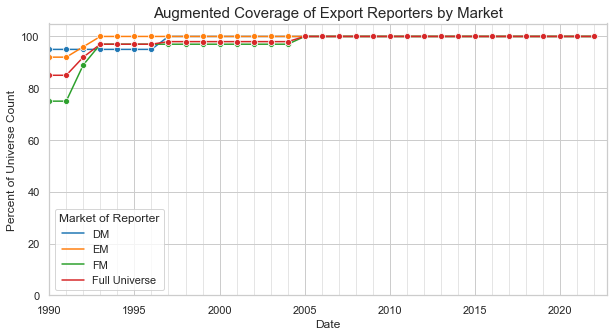

In [105]:
### IMF DOTS: NUMBER OF REPORTERS CHANGE

dict_reporters = {}
### Data loading:
ser_oecd_fdi = pd.read_hdf(path_or_buf = str_path_imf_dots_combined, key = str_full_imf_dots_combined).set_index(['Date', 'Reporter', 'Partner', 'Market'])\
                                                                                                                        .sort_index()['Export_Augmented'].dropna()
### Total reporters number:
ser_iter_reporters = ser_oecd_fdi.groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = ser_oecd_fdi[:, :, :, iter_region].groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Augmented Coverage of Export Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

Last date reported: 2022-06-30 00:00:00


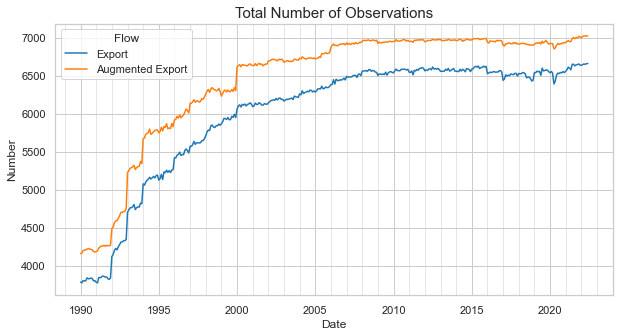

In [114]:
### IMF DOTS: DATA FRESHNESS

df_imf_dots = pd.read_hdf(path_or_buf = str_path_imf_dots_combined, key = str_full_imf_dots_combined).set_index(['Date', 'Reporter', 'Partner'])\
                                                                                                     .sort_index()[['Export', 'Export_Augmented']]
df_imf_dots.columns = ['Export', 'Augmented Export']
ser_imf_dots = df_imf_dots.stack().sort_index()
ser_imf_dots.index.names = ['Date', 'Reporter', 'Partner', 'Flow']
print('Last date reported:', ser_imf_dots.index.get_level_values('Date').max())
df_to_plot = ser_imf_dots.groupby(['Date', 'Flow']).count().sort_index().unstack('Flow').resample('MS').last().stack('Flow').reset_index()
df_to_plot.rename({0: 'Number'}, axis = 1, inplace = True)
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_number = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Number', hue = 'Flow', hue_order = ['Export', 'Augmented Export'])
ax_number.set_title('Total Number of Observations', fontsize = 15)
### Major ticker options:    
ax_number.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_number.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_number.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_number.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [8]:
### IMF CPIS: BILATERAL EQUITY & DEBT INVESTMENT POSITIONS

In [9]:
### IMF CPIS: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 5
int_imf_country_limit = 30

In [10]:
### IMF CPIS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update(dict_request_headers)

In [12]:
### IMF CPIS: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_cpis_id = ser_imf_dataflow[ser_imf_dataflow.str.contains('CPIS')].index[0].replace('DS-', '')
print(str_imf_cpis_id)

CPIS


In [13]:
### IMF CPIS: DATASTRUCTURE SEARCHING

obj_imf_cpis_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_cpis_id).json()
df_imf_cpis_params = pd.DataFrame(obj_imf_cpis_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_cpis_params)

          @conceptRef          @codelist @isFrequencyDimension
0                FREQ            CL_FREQ                  true
1            REF_AREA       CL_AREA_CPIS                   NaN
2           INDICATOR  CL_INDICATOR_CPIS                   NaN
3          REF_SECTOR     CL_SECTOR_CPIS                   NaN
4  COUNTERPART_SECTOR     CL_SECTOR_CPIS                   NaN
5    COUNTERPART_AREA       CL_AREA_CPIS                   NaN


In [15]:
### IMF CPIS: CODES DESCRIPTION SEARCHING

pd.set_option('display.max_colwidth', -1)
for int_counter, str_param_code in enumerate(df_imf_cpis_params['@codelist']):
    if (int_counter == 3):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_cpis_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_cpis_param =  pd.DataFrame(obj_imf_cpis_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_cpis_param = df_imf_cpis_param.assign(Text = df_imf_cpis_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        print(int_counter, ':', df_imf_cpis_params.iloc[int_counter, All]['@conceptRef'], ':', str_param_code, ':\n', df_imf_cpis_param.head(20))
    
str_cpis_freq = 'A' # 'B' # 
str_cpis_asset_indicator = 'I_A_T_T_T_BP6_USD' 
str_cpis_liability_indicator = 'I_L_T_T_T_BP6_USD'
str_cpis_ref_sector = 'T'
str_cpis_cp_sector = 'T'
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))
# 0: FREQ == 'B' # Semi-annual frequency - they don't have Quaterly or Monthly frequency data
# 1: REF_AREA == '??' # Country
# 2: INDICATOR  == 'I_A_T_T_T_BP6_USD' # Assets, Total Investment, BPM6, US Dollars & I_L_T_T_T_BP6_USD    Liabilities, Total Investment, BPM6, US Dollars
# 3: REF_SECTOR == 'T' # Total Holdings (all sectors)
# 4: COUNTERPART_SECTOR  == 'T' # Total Holdings (all sectors)
# 5: COUNTERPART_AREA == '??' # Country

3 : REF_SECTOR : CL_SECTOR_CPIS :
    @value  \
0   T       
1   FC      
2   DC      
3   CB      
4   ODX     
5   OFT     
6   IPF     
7   MMF     
8   OFX     
9   OFI     
10  OFM     
11  OFO     
12  GG      
13  NHN     
14  NFC     
15  HH      
16  NP      

                                                                           Text  
0   Total Holdings                                                               
1   Financial Corporations                                                       
2   Deposit Taking Corporations                                                  
3   Central Bank                                                                 
4   Depository-taking Corporations except the Central Bank                       
5   Other Financial Corporations                                                 
6   Other Financial Corporations: Insurance Corporations and Pension Funds       
7   Other Financial Corporations: Money Market Funds                      

In [14]:
### IMF CPIS ASSETS: REPORTED TOTAL PORTFOLIO INVESTMENT ASSET DATASET RETRIEVING

list_cpis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cpis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cpis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cpis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cpis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cpis_full_url = str_cpis_const_url + \
                            '.'.join([str_cpis_freq, str_cpis_reporters, str_cpis_asset_indicator, str_cpis_ref_sector, str_cpis_ref_sector, str_cpis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)
        obj_cpis_set = request_session.get(str_cpis_full_url)
        ### Data reading as JSON:
        dict_cpis_set = json.loads(obj_cpis_set.text.replace('@OBS_STATUS', '@OBS_VALUE'))
        ### Converting each bilateral dataset to dataframe and it's mungling:
        for dict_cpis_pair in dict_cpis_set['CompactData']['DataSet']['Series']:
            if isinstance(dict_cpis_pair['Obs'], list):
                df_cpis_bilateral = pd.DataFrame(dict_cpis_pair['Obs'])
            else:
                df_cpis_bilateral = pd.DataFrame([dict_cpis_pair['Obs']])
            df_cpis_bilateral = df_cpis_bilateral[['@TIME_PERIOD', '@OBS_VALUE']]
            df_cpis_bilateral.columns = ['Date', 'Value']
            df_cpis_bilateral = df_cpis_bilateral.assign(Reporter_ID = dict_cpis_pair['@REF_AREA'])
            df_cpis_bilateral = df_cpis_bilateral.assign(Partner_ID = dict_cpis_pair['@COUNTERPART_AREA'])
            list_cpis_bilateral.append(df_cpis_bilateral)   
### Bilateral dataset aggregating:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis.loc[df_cpis['Value'] == 'C', 'Value'] = np.NaN
df_cpis.loc[df_cpis['Value'] == '-', 'Value'] = np.NaN
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
### Dataframe converting to standartized format series:
df_cpis['Date'] = pd.to_datetime(df_cpis['Date']) + pd.offsets.BYearEnd()
ser_asset_cpis_data = df_cpis.set_index(['Date', 'Reporter_ID', 'Partner_ID']).squeeze()
### Series saving:
ser_asset_cpis_data.to_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_asset_imf_cpis_dataset, mode = 'w')

0 - 30  /  0 - 30
0 - 30  /  30 - 60
0 - 30  /  60 - 90
30 - 60  /  0 - 30
30 - 60  /  30 - 60
30 - 60  /  60 - 90
60 - 90  /  0 - 30
60 - 90  /  30 - 60
60 - 90  /  60 - 90


In [15]:
### IMF CPIS LIABILITIES: REPORTED TOTAL PORTFOLIO INVESTMENT LIABILITY DATASET RETRIEVING

list_cpis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cpis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cpis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cpis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cpis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cpis_full_url = str_cpis_const_url + \
                            '.'.join([str_cpis_freq, str_cpis_reporters, str_cpis_liability_indicator, str_cpis_ref_sector, str_cpis_ref_sector, str_cpis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)        
        obj_cpis_set = request_session.get(str_cpis_full_url)
        ### Data reading as JSON:
        dict_cpis_set = json.loads(obj_cpis_set.text.replace('@OBS_STATUS', '@OBS_VALUE'))        
        ### Converting each bilateral dataset to dataframe and it's mungling:
        for dict_cpis_pair in dict_cpis_set['CompactData']['DataSet']['Series']:
            if isinstance(dict_cpis_pair['Obs'], list):
                df_cpis_bilateral = pd.DataFrame(dict_cpis_pair['Obs'])
            else:
                df_cpis_bilateral = pd.DataFrame([dict_cpis_pair['Obs']])
            df_cpis_bilateral = df_cpis_bilateral[['@TIME_PERIOD', '@OBS_VALUE']]
            df_cpis_bilateral.columns = ['Date', 'Value']
            df_cpis_bilateral = df_cpis_bilateral.assign(Reporter_ID = dict_cpis_pair['@REF_AREA'])
            df_cpis_bilateral = df_cpis_bilateral.assign(Partner_ID = dict_cpis_pair['@COUNTERPART_AREA'])
            list_cpis_bilateral.append(df_cpis_bilateral)   
### Bilateral dataset aggregating:
df_cpis = pd.concat(list_cpis_bilateral, axis = 0, ignore_index = True)
df_cpis = df_cpis[df_cpis['Reporter_ID'] != df_cpis['Partner_ID']]
df_cpis.loc[df_cpis['Value'] == 'C', 'Value'] = np.NaN
df_cpis.loc[df_cpis['Value'] == '-', 'Value'] = np.NaN
df_cpis = df_cpis.astype({'Reporter_ID': 'str', 'Partner_ID': 'str', 'Value': 'float32'})
### Dataframe converting to stadartized format series:
df_cpis['Date'] = pd.to_datetime(df_cpis['Date']) + pd.offsets.BYearEnd()
ser_liability_cpis_data = df_cpis.set_index(['Date', 'Reporter_ID', 'Partner_ID']).squeeze()
### Series saving:
ser_liability_cpis_data.to_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_liability_imf_cpis_dataset, mode = 'r+')

0 - 30  /  0 - 30
0 - 30  /  30 - 60
0 - 30  /  60 - 90
30 - 60  /  0 - 30
30 - 60  /  30 - 60
30 - 60  /  60 - 90
60 - 90  /  0 - 30
60 - 90  /  30 - 60
60 - 90  /  60 - 90


In [16]:
### IMF CPIS POSITIONS: POSITIONS AGGREGATION & SAVING

ser_cpis_asset = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_asset_imf_cpis_dataset)
ser_cpis_liability = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_liability_imf_cpis_dataset)
ser_cpis_full = pd.concat([ser_cpis_asset, ser_cpis_liability], keys = ['Asset', 'Liability'], names = ['Position'])
### Aggregated dataset saving:
df_cpis_full = ser_cpis_full.reset_index()
df_cpis_full.rename({'Reporter_ID': 'Reporter', 'Partner_ID': 'Partner'}, axis = 1, inplace = True)
df_cpis_full = df_cpis_full.astype({'Reporter': 'category', 'Partner': 'category', 'Position': 'category'})[['Date', 'Reporter', 'Partner', 'Position', 'Value']]
df_cpis_full.to_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_full_imf_cpis_dataset, mode = 'r+', format = 'table')
### Example:
list_to_plot = ['IL', 'US']
str_date_to_compare = '2020-12-31'
print(ser_cpis_full.loc[All, ['1997-12-31', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Position']))

Position                                   Asset     Liability
Date       Reporter_ID Partner_ID                             
1997-12-31 IL          US            1427.234009  23469.263672
           US          IL           12207.000000           NaN
2020-12-31 IL          US          119013.000000  89933.000000
           US          IL           94555.000000           NaN


In [16]:
### IMF CPIS POSITIONS: DATA LOADING

df_cpis_full = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_full_imf_cpis_dataset)
df_cpis_full = df_cpis_full[df_cpis_full['Value'] > 0.0]
df_cpis_asset = df_cpis_full[df_cpis_full['Position'] == 'Asset']

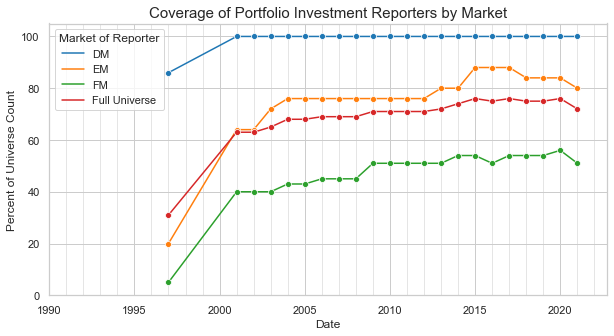

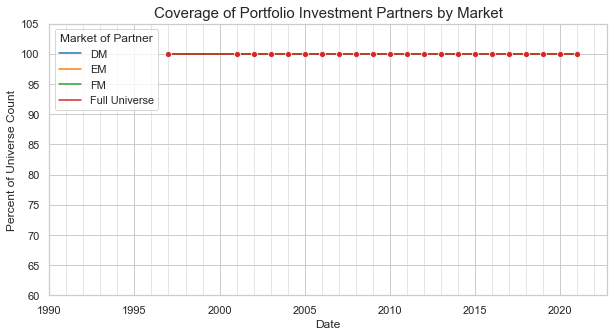

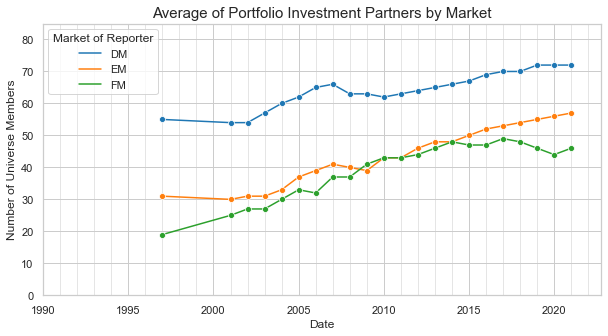

In [41]:
### IMF CPIS: STATS: ASSETS COVERAGE: PARTICIPANTS NUMBER

gc.collect()
### Adding regions of reporters and partners:
ser_ison_status.index.names = ['Country']
df_coverage_full = df_cpis_asset.merge(ser_ison_status, left_on = 'Reporter', right_on = 'Country').merge(ser_ison_status, left_on = 'Partner', right_on = 'Country')
df_coverage_full.rename({'Market_x': 'Reporter_Market', 'Market_y': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Coverage of Portfolio Investment Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
ser_iter_partners.name = 'Percent'
### Region's partners number:
dict_partners['Full Universe']  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
    ser_iter_partners.name = 'Percent'
    dict_partners[iter_region]  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Partner', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_partners.set_title('Coverage of Portfolio Investment Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (60, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Percent'
#    dict_ave_partners[iter_region] = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
    dict_ave_partners[iter_region] = ser_iter_partners.resample('BY').last().dropna().astype(int)    
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions, marker = 'o')
ax_partners.set_title('Average of Portfolio Investment Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 85), ylabel = 'Number of Universe Members')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [53]:
### TEMP

df_test = df_coverage_full#[df_coverage_full['Partner_Market'] == 'FM']
len(df_test[(df_test['Date'] == '2020-12-31') & (df_test['Reporter'] == 'US')])

79

IMF Portfolio Investment Assets: Total ISON Reporters number: 66
IMF Portfolio Investment Assets: Absent countries: ['AE', 'BW', 'CI', 'EC', 'GH', 'HR', 'JO', 'KE', 'LK', 'MA', 'NG', 'OM', 'QA', 'RS', 'TN', 'TW', 'UG', 'VN', 'ZM']


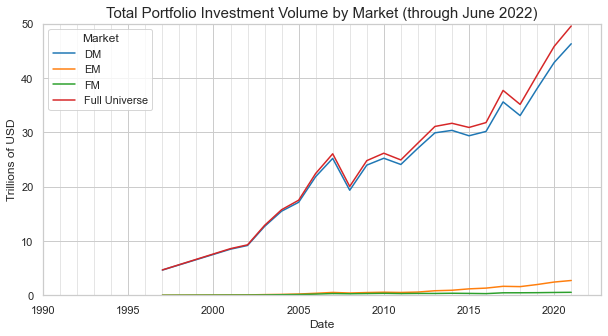

In [51]:
### IMF CPIS: STATS: ASSETS VOLUME

gc.collect()
print('IMF Portfolio Investment Assets: Total ISON Reporters number:', str(len(df_cpis_asset['Reporter'].unique())))
print('IMF Portfolio Investment Assets: Absent countries:', sorted(list(set(ser_ison_status.index) - set(df_cpis_asset['Reporter']))))
### Total export volume calculation start:
dict_total_volume = {}
### ISON total volume:
ser_ison_status.index.names = ['Reporter']
df_cpis_asset_isoned = df_cpis_asset.join(ser_ison_status, on = 'Reporter')
dict_total_volume['Full Universe'] = df_cpis_asset.groupby('Date')['Value'].sum() / 1000000
### Region's total volume:
for iter_region in list_regions:
    dict_total_volume[iter_region] = df_cpis_asset_isoned[df_cpis_asset_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000
### Data consolidating:    
df_volume = pd.concat(dict_total_volume).unstack(0).resample('YS').last().stack(0).reset_index()
df_volume.columns = ['Date', 'Market', 'Volume']
df_to_plot = df_volume[df_volume['Date'] < date_end]
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Volume', hue = 'Market', hue_order = ['DM', 'EM', 'FM', 'Full Universe'])
ax_total.set_title('Total Portfolio Investment Volume by Market (through June 2022)', fontsize = 15)
ax_total.set(xlim = (date_start, date_end), ylabel = 'Trillions of USD', ylim = (0, 50))
### Major ticker options:    
ax_total.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_total.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_total.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_total.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

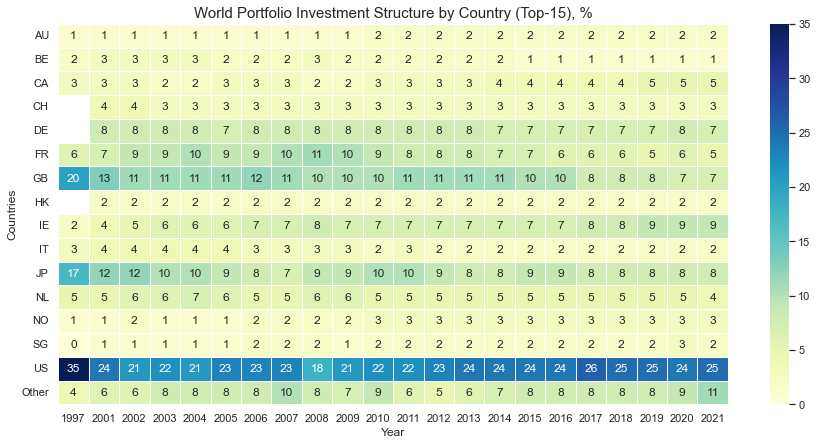

In [52]:
### IMF CPIS: STATS: ASSETS LEADERS

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Stats parameter - years to define leaders:
int_term = 10
### Country trade proprotion for each date:
ser_country_value = df_cpis_asset.groupby(['Date', 'Reporter'])['Value'].sum().dropna() / 1000000
ser_total_volume = df_cpis_asset.groupby(['Date'])['Value'].sum().dropna() / 1000000
df_country_part = (ser_country_value / ser_total_volume).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze().sort_index()
### Limited by term country trade volume:
ser_country_sum = ser_country_value.groupby('Reporter').apply(lambda ser_group: ser_group.iloc[-int_term :].sum()).sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other[ser_country_other > 0]}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f')
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Portfolio Investment Structure by Country (Top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()   

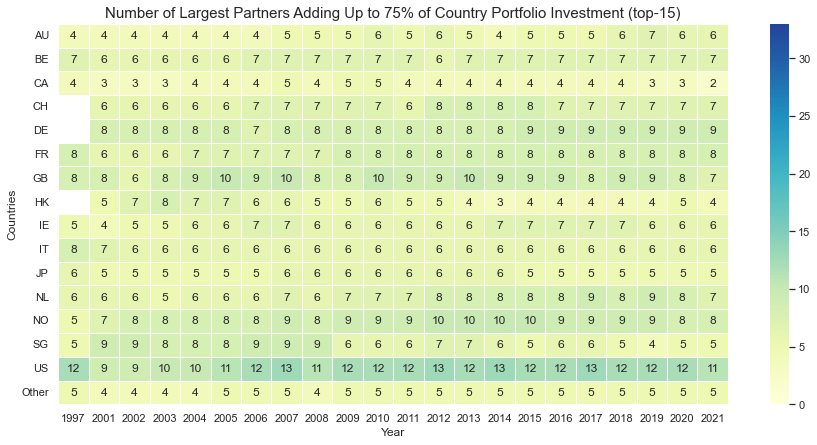

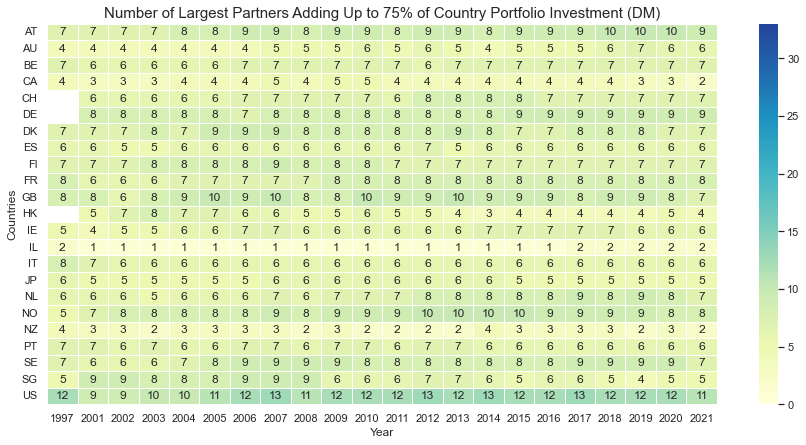

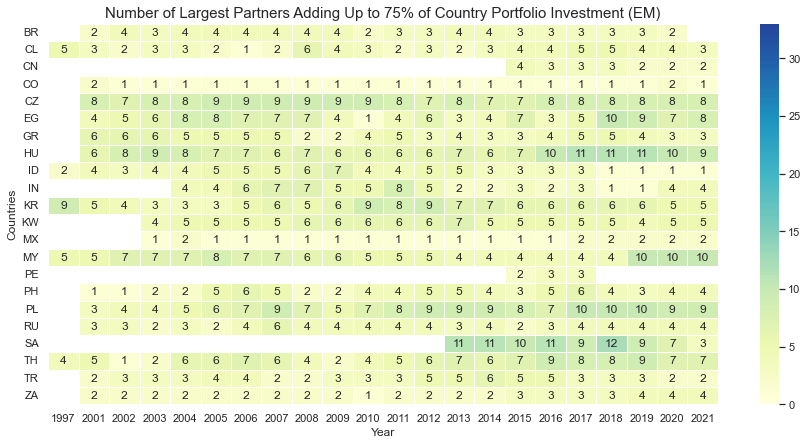

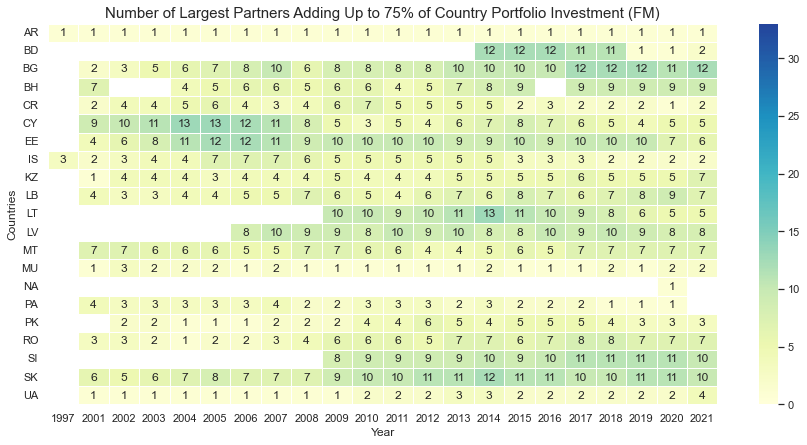

In [53]:
### IMF CPIS: STATS: NUMBER OF PARTNERS TO COMPLETE FIXED % OF ASSETS FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(ser_group, flo_perc):
    ser_by_partner = ser_group.groupby(['Date', 'Partner'])['Value'].sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.75
### Stats parameter - leaders to plot:
int_top = 15
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Partners number calculation for each Date / Reporter pair:
ser_partners = df_cpis_asset.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).dropna().astype(int)
ser_partners.name = 'Number'
df_partners = ser_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Leaders data extraction for leaders plot:
df_top_part = df_partners[df_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_partners[df_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Portfolio Investment (top-' + str(int_top) + ')', 
                     fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_regions:
    ### Data extraction:    
    df_to_plot = df_partners.loc[df_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Portfolio Investment (' + iter_region + ')', 
                         fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

In [9]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

gc.collect()
### Data loading:
df_cpis_full = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_full_imf_cpis_dataset)
df_cpis_full = df_cpis_full[(df_cpis_full['Date'] > date_start) & (df_cpis_full['Date'] <= date_end)].dropna()
df_cpis_full = df_cpis_full[df_cpis_full['Value'] > 0.0]
ser_asset = df_cpis_full.loc[df_cpis_full['Position'] == 'Asset'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_liability = df_cpis_full.loc[df_cpis_full['Position'] == 'Liability'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
### Data concatenation:
ser_flows = pd.concat([ser_asset, ser_liability], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()

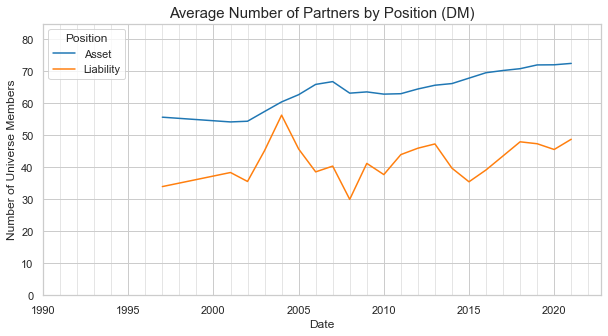

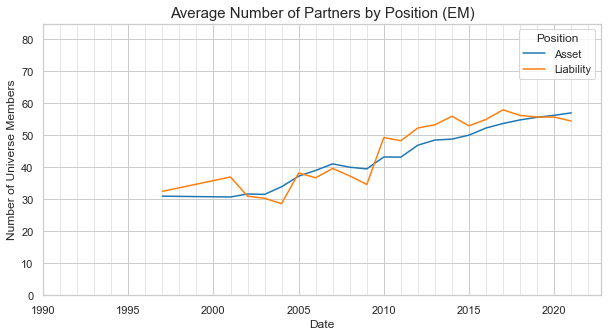

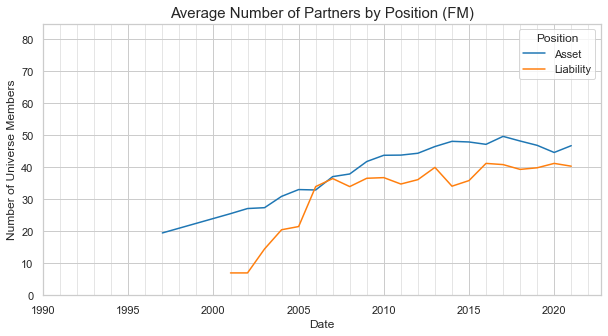

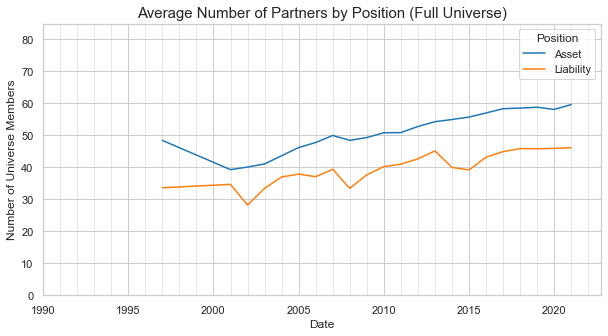

Number of observations for each flow: 
 Position
Asset        67051
Liability    11179
dtype: int64


In [10]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Average partners number for Date / Reporter:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Position', 'Market']).count()
dict_obs_mean['Full Universe'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_regions:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                               .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()

df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Value', hue = 'Position', ci = None)
    ax_partners.set_title('Average Number of Partners by Position (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break
print('Number of observations for each flow:', '\n', ser_flows.unstack('Position').count())

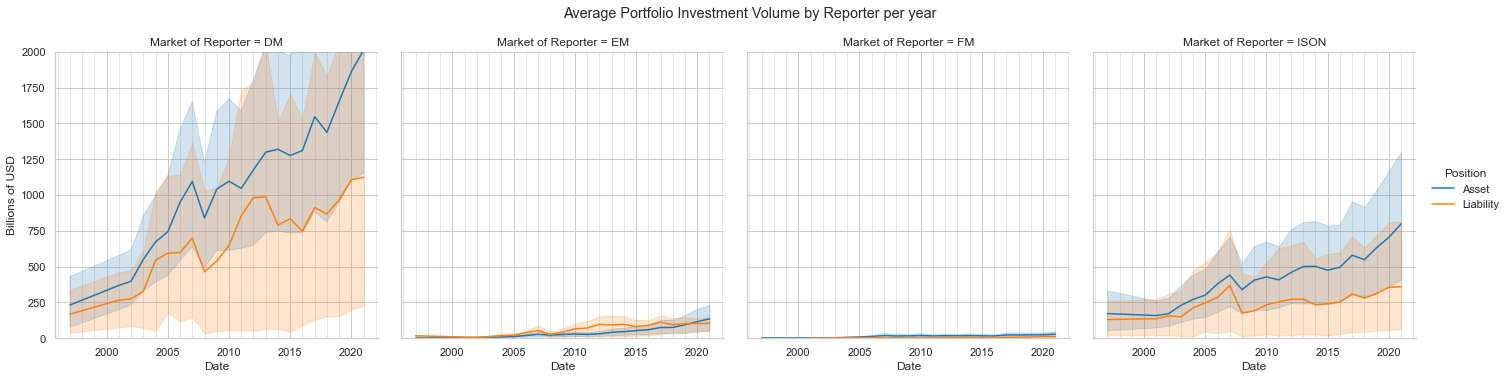

In [39]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: VOLUME COMPARING

gc.collect()
### Trade volume calculation:
dict_obs_sum = {}
ser_reporter_sum = ser_flows.groupby(['Date', 'Reporter', 'Position', 'Market']).sum() / 1000
dict_obs_sum['Full Universe'] = ser_reporter_sum.round(0).droplevel('Market').round(2).dropna()
for iter_region in list_regions:
    dict_obs_sum[iter_region] = ser_reporter_sum.loc[All, All, All, iter_region].round(2).dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_sum, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                              .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Market of Reporter', hue = 'Position', kind = 'line')
fig_mean_obs.fig.suptitle('Average Portfolio Investment Volume by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Billions of USD')
fig_mean_obs.set(ylim = (0, 2000))
### Axes customizing:
for iter_ax in fig_mean_obs.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [11]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()
### Data loading:
df_cpis_full = pd.read_hdf(path_or_buf = str_path_imf_cpis_dataset, key = str_full_imf_cpis_dataset)
df_cpis_full = df_cpis_full[(df_cpis_full['Date'] > date_start) & (df_cpis_full['Date'] <= date_end)].dropna()
ser_asset = df_cpis_full.loc[df_cpis_full['Position'] == 'Asset'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_liability = df_cpis_full.loc[df_cpis_full['Position'] == 'Liability'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
del df_cpis_full
gc.collect()
### Data aggregation:
ser_liability_rev = ser_liability[:]
ser_liability_rev.index.set_names('Partner_Inv', level = 1, inplace = True)
ser_liability_rev.index.set_names('Reporter', level = 2, inplace = True)
ser_liability_rev.index.set_names('Partner', level = 1, inplace = True)
ser_liability_rev = ser_liability_rev.swaplevel('Reporter', 'Partner').sort_index()
df_asset_aug = pd.concat([ser_asset.droplevel('Position'), ser_liability_rev.droplevel('Position')], axis = 1, 
                           names = 'Source Position', keys = ['Asset', 'Liability'])
df_asset_aug = df_asset_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_asset_aug = df_asset_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')
df_asset_aug = df_asset_aug.replace({0.0 : np.NaN})

In [ ]:
### TEMP

ser_unique_mean.loc['Borrowers\' Info', '1997-12-31', :, 'FM']

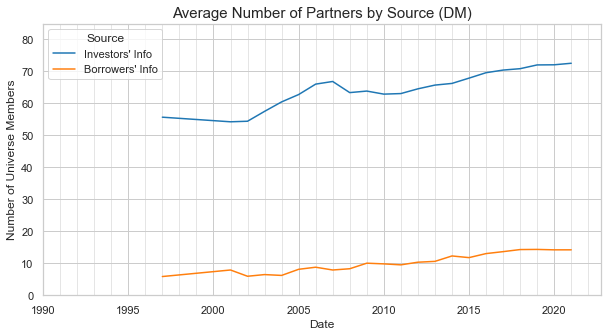

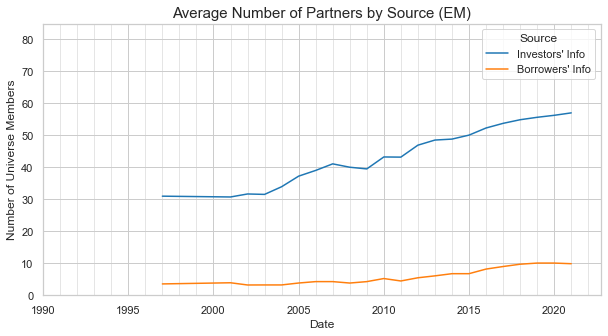

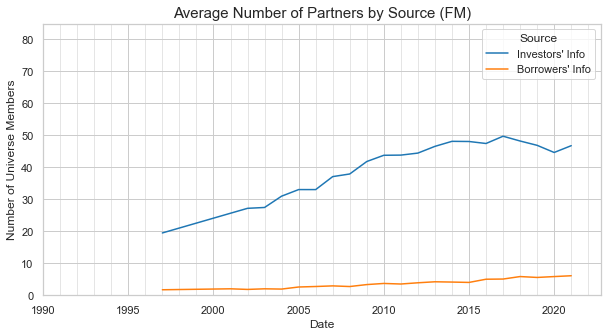

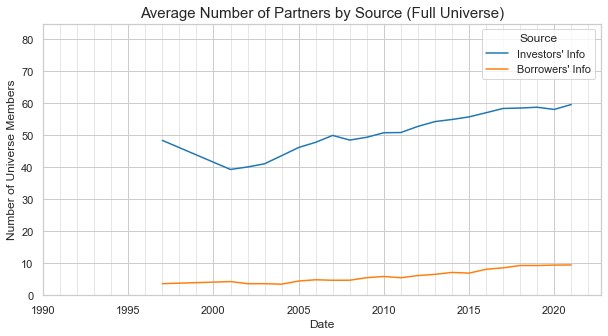

In [106]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Coverage data container:
dict_unique_mean = {}
### Partners number calculation:
dict_unique_mean['Investors\' Info'] = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).count()
dict_unique_mean['Borrowers\' Info'] = df_asset_aug['Liability'].groupby(['Date', 'Reporter', 'Market']).count()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source']).round(0).dropna().astype(int)
ser_unique_mean = ser_unique_mean[ser_unique_mean > 0]
ser_unique_mean.name = 'Number of Partners'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average partners number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Investor']).unstack(['Market of Investor', 'Reporter', 'Source']).resample('YS').last()\
                                                                                    .stack(['Market of Investor', 'Reporter']).dropna(how = 'all')\
                                                                                    .stack('Source').reset_index()
df_to_plot.rename({0: 'Number of Partners'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Number of Partners', hue = 'Source', 
                               hue_order = ['Investors\' Info', 'Borrowers\' Info'], ci = None)
    ax_partners.set_title('Average Number of Partners by Source (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

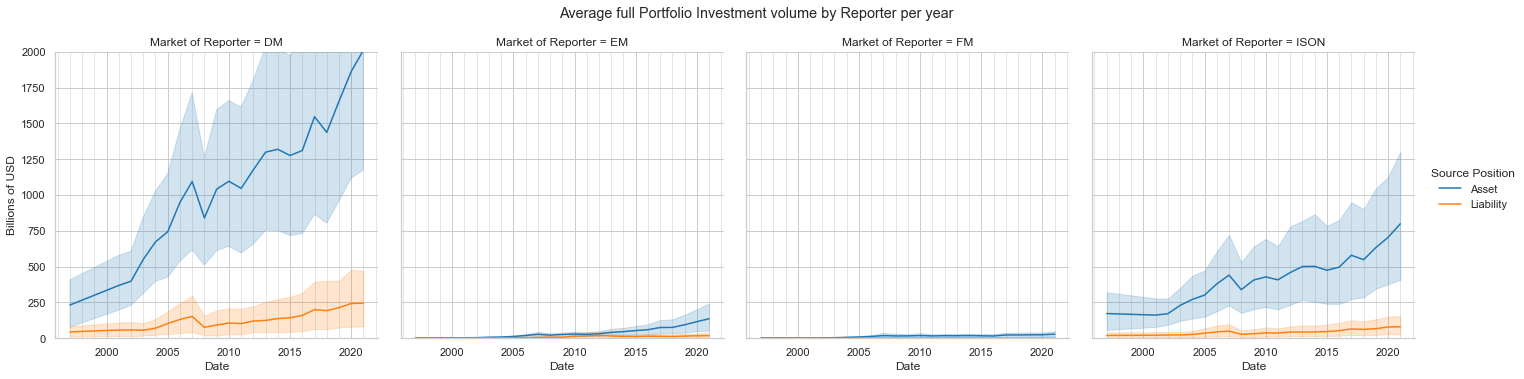

In [42]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: TOTAL OBSERVATIONS VOLUME

gc.collect()
### Valome calculation:
dict_unique_sum = {}
dict_unique_sum['Asset'] = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Liability'] = df_asset_aug['Liability'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Position']).round(2)
ser_unique_sum.name = 'Portfolio Investment volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Reporter'])\
               .unstack(['Market of Reporter', 'Reporter', 'Source Position']).resample('YS').last()\
               .stack(['Market of Reporter', 'Reporter', 'Source Position']).reset_index()
df_to_plot.rename({0: 'Portfolio Investment volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Portfolio Investment volume', col = 'Market of Reporter', hue = 'Source Position', kind = 'line')
fig_mean_unique.fig.suptitle('Average full Portfolio Investment volume by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 2000))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

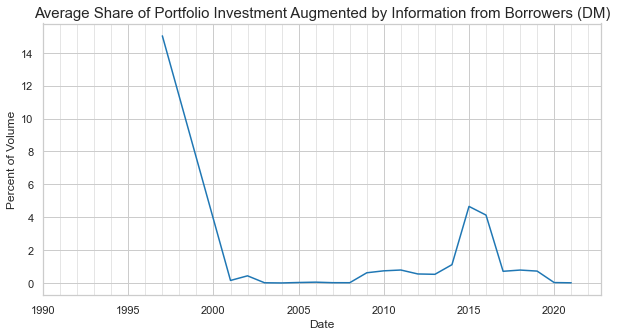

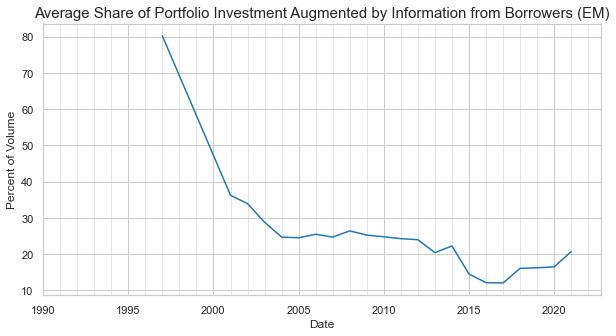

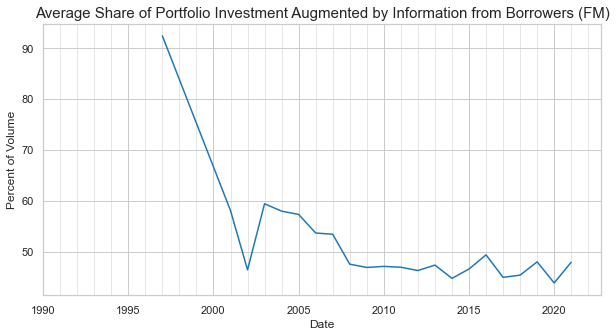

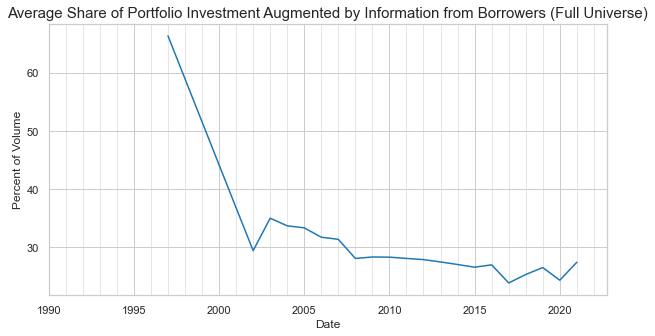

In [129]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: UNIQUE INVERTED LIABILITIES VOLUME

gc.collect()
### Unique inverted import data filtering:
ser_liability_unique = df_asset_aug.loc[df_asset_aug['Asset'].isna() & df_asset_aug['Liability'].notna(), 'Liability']\
                                 .groupby(['Date', 'Reporter', 'Market']).sum()
ser_liability_unique_ann = ser_liability_unique.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_liability_unique_ann.name = 'Added Volume'
### Unique inverted import by Market grouping:
dict_unique_liability = {}
dict_unique_liability['Full Universe'] = ser_liability_unique_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_liability[iter_region] = ser_liability_unique_ann.loc[All, All, iter_region].dropna()
ser_liability_isoned = pd.concat(dict_unique_liability, axis = 0, names = ['Market of Investor'])
### Total export data filtering:
ser_asset_total = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum()
ser_asset_total_ann = ser_asset_total.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_asset_total_ann.name = 'Asset Volume'
### Total export by Market grouping:
dict_asset_total = {}
dict_asset_total['Full Universe'] = ser_asset_total_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_asset_total[iter_region] = ser_asset_total_ann.loc[All, All, iter_region].dropna()
ser_asset_isoned = pd.concat(dict_asset_total, axis = 0, names = ['Market of Investor'])
### Share of Export Augmented by Information from Importers:
ser_share = (ser_liability_isoned.fillna(0) / (ser_liability_isoned.fillna(0) + ser_asset_isoned.fillna(0)) * 100).round(2)
### Dataset to draw:
df_to_plot = ser_share.unstack(['Market of Investor', 'Reporter']).resample('YS').last().stack(['Market of Investor', 'Reporter']).reset_index()
df_to_plot.rename({0: 'Share Added'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_share = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Share Added', ci = None)
    ax_share.set_title('Average Share of Portfolio Investment Augmented by Information from Borrowers (' + iter_region + ')', fontsize = 15)
    ax_share.set(xlim = (date_start, date_end), ylabel = 'Percent of Volume')#, ylim = (0, 12))
    ### Major ticker options:    
    ax_share.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_share.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_share.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_share.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()

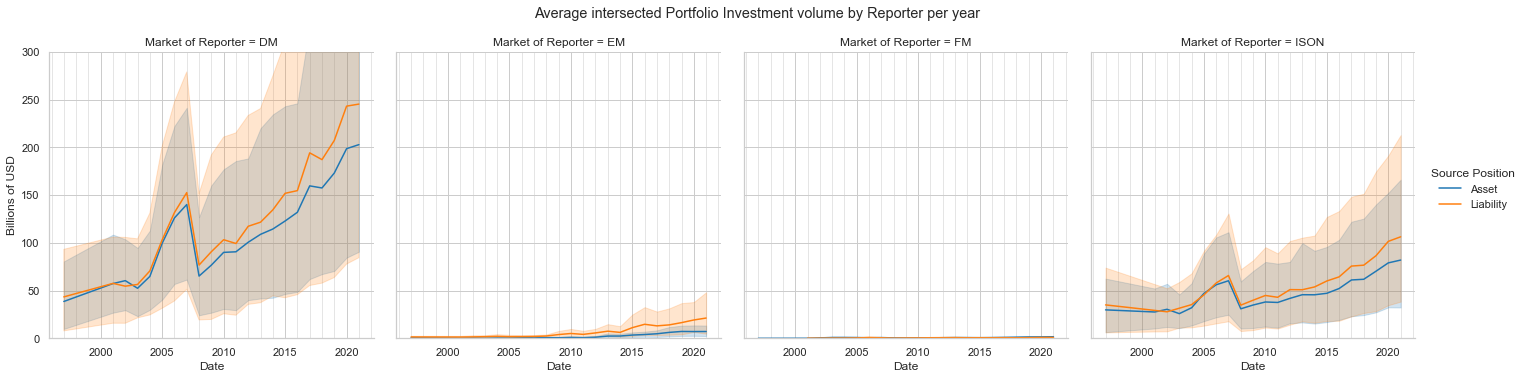

In [44]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS VOLUME

gc.collect()

dict_unique_sum = {}
dict_unique_sum['Asset'] = df_asset_aug.dropna()['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Liability'] = df_asset_aug.dropna()['Liability'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Position']).round(2)
ser_unique_sum.name = 'Portfolio Investment volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Reporter'])\
               .unstack(['Market of Reporter', 'Reporter', 'Source Position']).resample('YS').last()\
               .stack(['Market of Reporter', 'Reporter', 'Source Position']).reset_index()
df_to_plot.rename({0: 'Portfolio Investment volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Portfolio Investment volume', col = 'Market of Reporter', hue = 'Source Position', kind = 'line')
fig_mean_unique.fig.suptitle('Average intersected Portfolio Investment volume by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 300))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

In [45]:
### TEMP

gc.collect()
#print(ser_inter_sum[ser_inter_sum > 0.0].sum())
#print(ser_unique_sum[ser_unique_sum > 0.0].sum())
ser_inter_exp = df_asset_aug.dropna()['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_total_exp = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = df_asset_aug.loc[df_asset_aug['Asset'].notna() & df_asset_aug['Liability'].isna(), 'Asset']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
print('Total:', ser_total_exp.sum())
print('Intersected:', ser_inter_exp.sum())
print('Unique:', ser_unique_exp.sum())
print('Sum:', ser_inter_exp.sum() + ser_unique_exp.sum())
print('Percent of unique:', ser_unique_exp.sum() / ser_total_exp.sum() * 100)

Total: 574910.3
Intersected: 56927.215
Unique: 517983.06
Sum: 574910.25
Percent of unique: 90.09806513786316


In [130]:
### IMF CPIS: LIABILITY DATA INCORPORATION:

### Combining Export & Import data:
df_asset_aug['Asset_Augmented'] = df_asset_aug['Asset'].combine_first(df_asset_aug['Liability'])

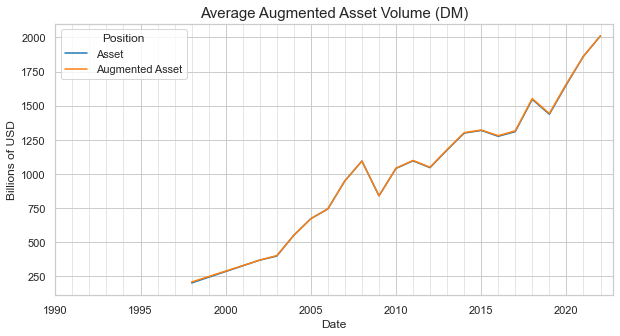

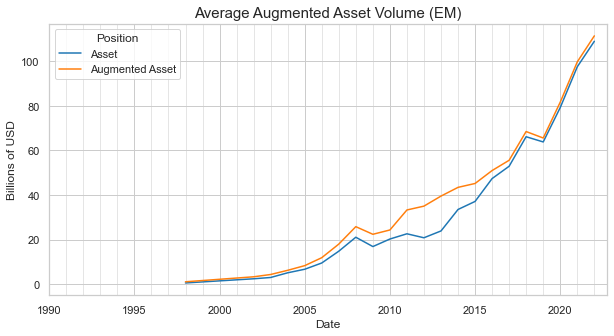

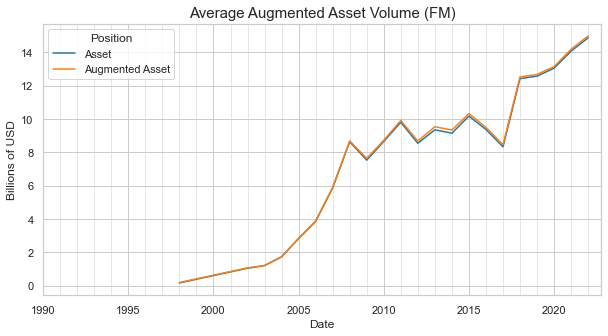

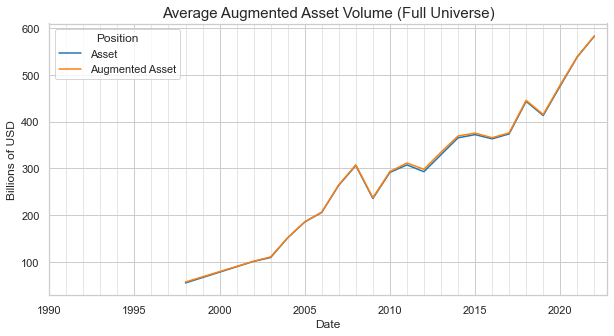

In [134]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()

df_options_sum = df_asset_aug.groupby(['Date', 'Reporter', 'Market']).sum() / 1000
df_options_sum.columns = ['Asset', 'Liability', 'Augmented Asset']
ser_options_sum = df_options_sum[['Asset', 'Augmented Asset']].reset_index()\
                        .melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Position', value_name = 'Asset_Volume')\
                        .set_index(['Date', 'Reporter', 'Market', 'Position']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['Full Universe'] = ser_options_sum.dropna().droplevel('Market')
for iter_region in list_regions:
    dict_options_sum[iter_region] = ser_options_sum.dropna().loc[All, All, iter_region, All]
### Export volume plotting:
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Reporter']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_volume = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Asset_Volume', hue = 'Position', ci = None)
    ax_volume.set_title('Average Augmented Asset Volume (' + iter_region + ')', fontsize = 15)
    ax_volume.set(xlim = (date_start, date_end), ylabel = 'Billions of USD')
    ### Major ticker options:    
    ax_volume.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_volume.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_volume.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_volume.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

In [20]:
### IMF CPIS: LIABILITY DATA INCORPORATION: RESULTS SAVING

### Dataset saving:
df_asset_aug = df_asset_aug.astype('float32')
df_asset_aug = df_asset_aug.reset_index()
df_asset_aug = df_asset_aug.astype({'Reporter': 'category', 'Partner': 'category', 'Market': 'category'})
df_asset_aug.to_hdf(path_or_buf = str_path_imf_cpis_combined, key = str_full_imf_cpis_combined, mode = 'w', format = 'table')
del df_asset_aug
gc.collect()

<function gc.collect(generation=2)>

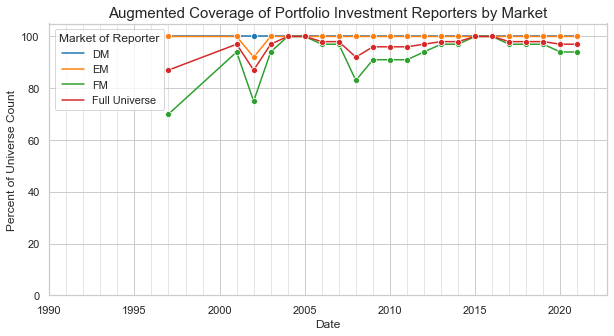

In [104]:
### IMF CPIS: NUMBER OF REPORTERS CHANGE

dict_reporters = {}
### Data loading:
ser_oecd_fdi = pd.read_hdf(path_or_buf = str_path_imf_cpis_combined, key = str_full_imf_cpis_combined).set_index(['Date', 'Reporter', 'Partner', 'Market'])\
                                                                                                                        .sort_index()['Asset_Augmented'].dropna()
### Total reporters number:
ser_iter_reporters = ser_oecd_fdi.groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = ser_oecd_fdi[:, :, :, iter_region].groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Augmented Coverage of Portfolio Investment Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

Last date reported: 2021-12-31 00:00:00


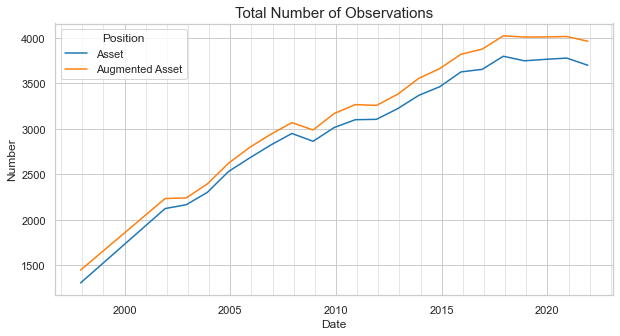

In [136]:
### IMF CPIS: DATA FRESHNESS

df_imf_cpis = pd.read_hdf(path_or_buf = str_path_imf_cpis_combined, key = str_full_imf_cpis_combined).set_index(['Date', 'Reporter', 'Partner'])\
                                                                                                      .sort_index()[['Asset', 'Asset_Augmented']]
df_imf_cpis.columns = ['Asset', 'Augmented Asset']
ser_imf_cpis = df_imf_cpis.stack().sort_index()
ser_imf_cpis.index.names = ['Date', 'Reporter', 'Partner', 'Position']
print('Last date reported:', ser_imf_cpis.index.get_level_values('Date').max())
df_to_plot = ser_imf_cpis.groupby(['Date', 'Position']).count().sort_index().unstack('Position').resample('MS').last().stack('Position').reset_index()
df_to_plot.rename({0: 'Number'}, axis = 1, inplace = True)
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_number = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Number', hue = 'Position', hue_order = ['Asset', 'Augmented Asset'])
ax_number.set_title('Total Number of Observations', fontsize = 15)
### Major ticker options:    
ax_number.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_number.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_number.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_number.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [8]:
### OECD FDI: FOREIGN DIRECT INVESTMENT

In [9]:
### OECD FDI: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
str_oecd_base_url = 'https://stats.oecd.org/sdmx-json/data/'
str_oecd_structure_url = 'https://stats.oecd.org/restsdmx/sdmx.ashx/GetDataStructure/'
str_fdi_flow_dataset_add = 'FDI_FLOW_CTRY'
str_fdi_pos_dataset_add = 'FDI_POS_CTRY'

In [10]:
### OECD FDI: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors:
dict_header = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
request_session.headers.update(dict_header)

In [11]:
### OECD FDI: FDI POSITION STRUCTURE REQUEST

obj_oecd_structure = request_session.get(str_oecd_structure_url + str_fdi_pos_dataset_add)
xml_tree_root = et.fromstring(obj_oecd_structure.content)
dict_concepts = {}
dict_dimensions = {}
dict_codelists = {}
for xml_tree_child in xml_tree_root:
    if xml_tree_child.tag.endswith('Concepts'):
        for xml_tree_grand in xml_tree_child:
            str_concept_id = xml_tree_grand.attrib['id']
            str_concept_name = xml_tree_grand[0].text
            dict_concepts[str_concept_id] = str_concept_name
    if xml_tree_child.tag.endswith('KeyFamilies'):
        for xml_tree_family in xml_tree_child:
            for xml_tree_component in xml_tree_family:
                if xml_tree_component.tag.endswith('Components'):
                    for xml_tree_measure in xml_tree_component:
                        if xml_tree_measure.tag.endswith('Dimension'):
                            str_concept_id = xml_tree_measure.attrib['conceptRef']
                            str_concept_cl_id = xml_tree_measure.attrib['codelist']
                            dict_dimensions[str_concept_id] = str_concept_cl_id
    if xml_tree_child.tag.endswith('CodeLists'):       
        for num_tree_grand, xml_tree_grand in enumerate(xml_tree_child):
            str_codelist_id = xml_tree_grand.attrib['id']
            dict_codelist = {}
            for xml_tree_codelist in xml_tree_grand:                
                if xml_tree_codelist.tag.endswith('Code'):
                    str_code_id = xml_tree_codelist.attrib['value']
                    str_code_value = xml_tree_codelist[0].text
                    dict_codelist[str_code_id] = str_code_value
            dict_codelists[str_codelist_id] = dict_codelist

In [13]:
### OECD FDI: DIMENSIONS

pd.concat([pd.Series(dict_concepts), pd.Series(dict_dimensions)], axis = 1, sort = False).dropna()

0  \
COU                        Reporting country   
MEASURE                             Currency   
MEASURE_PRINCIPLE      Measurement principle   
FDI_TYPE                         Type of FDI   
TYPE_ENTITY                   Type of entity   
ACCOUNTING_ENTRY            Accounting entry   
LEVEL_COUNTERPART       Level of counterpart   
COUNTERPART_AREA   Partner country/territory   
TIME                                    Year   

                                                   1  
COU                              CL_FDI_POS_CTRY_COU  
MEASURE                      CL_FDI_POS_CTRY_MEASURE  
MEASURE_PRINCIPLE  CL_FDI_POS_CTRY_MEASURE_PRINCIPLE  
FDI_TYPE                    CL_FDI_POS_CTRY_FDI_TYPE  
TYPE_ENTITY              CL_FDI_POS_CTRY_TYPE_ENTITY  
ACCOUNTING_ENTRY    CL_FDI_POS_CTRY_ACCOUNTING_ENTRY  
LEVEL_COUNTERPART  CL_FDI_POS_CTRY_LEVEL_COUNTERPART  
COUNTERPART_AREA    CL_FDI_POS_CTRY_COUNTERPART_AREA  
TIME                            CL_FDI_POS_CTRY_TIME

In [14]:
### OECD FDI: FDI POSITION CONCEPT SOURCE CODELISTS:

dict_codelists['CL_FDI_POS_CTRY_FDI_TYPE']

{'LE_FA_F': 'FDI positions -Total',
 'LE_FA_F5': 'FDI positions - Equity (including reinvestment of earnings)',
 'LE_FA_FL': 'FDI positions - Debt'}

In [15]:
### OECD FDI: FDI POSITION PARAMETERS PREPARATION: Non-country parameters:

### Currency:
str_measure = 'USD'
### Direction:
str_direction = '+'.join(['DI', 'DO'])
### Investment type:
str_fdi_type = 'LE_FA_F'
### Residence defining:
str_residence = 'ALL'
### Accounting way:
str_accounting = '+'.join(['NET', 'A', 'L']) # 'NET' # 
### Level counterpart(???):
str_counterpart = 'IMC'

In [16]:
### OECD FDI: FDI POSITION PARAMETERS PREPARATION: Reporters and partners control and preparation

### ISON Countries collecting:
df_ison_countries = df_country_codes.set_index('ISO SHORT', append = True).reset_index('COUNTRY', drop = True)
df_ison_countries = df_ison_countries.reindex(ser_ison_membership.index.get_level_values(1).unique().to_list())
ser_ison_countries = df_ison_countries.reset_index().set_index('ISO LONG').squeeze()
### OECD reporters vs ISON members:
ser_oecd_reporters = pd.Series(dict_codelists['CL_FDI_POS_CTRY_COU'])
ser_oecd_reporters = ser_oecd_reporters.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_reporters[ser_oecd_reporters.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Reporter country with no ISON match:', iter_iso_long)
### ISON countries with no OECD reporter match:
set_no_reporters = set(ser_ison_countries.dropna().index) - set(ser_oecd_reporters.index)
print('ISON countries with no OECD reporter match:', set_no_reporters, '(', len(set_no_reporters), ')')           
### OECD partners vs ISON members:
ser_oecd_partners = pd.Series(dict_codelists['CL_FDI_POS_CTRY_COUNTERPART_AREA'])
ser_oecd_partners = ser_oecd_partners.to_frame().join(ser_ison_countries).drop(0, axis = 1).squeeze()
for iter_iso_long in (ser_oecd_partners[ser_oecd_partners.isna()].index.get_level_values(0)):
    if iter_iso_long in ser_ison_countries.index:
        print('OECD Partner country with no ISON match:', iter_iso_long)
### ISON countries with no OECD partner match:
set_no_partners = set(ser_ison_countries.dropna().index) - set(ser_oecd_partners.index)
print('ISON countries with no OECD partner match:', set_no_partners, '(', len(set_no_partners), ')')
### Lists preparation:
str_reporters_all = '+'.join(ser_oecd_reporters.dropna().index.to_list())
str_partners_all = '+'.join(ser_oecd_partners.dropna().index.to_list())

ISON countries with no OECD reporter match: {'HRV', 'MUS', 'BGD', 'PHL', 'JOR', 'BRA', 'GHA', 'MLT', 'MYS', 'BGR', 'SGP', 'UGA', 'IDN', 'LKA', 'CIV', 'VNM', 'NGA', 'SAU', 'ARE', 'QAT', 'HKG', 'EGY', 'CYP', 'ECU', 'BWA', 'THA', 'PAN', 'CHN', 'RUS', 'PER', 'LBN', 'PAK', 'MAR', 'UKR', 'IND', 'SRB', 'TUN', 'KWT', 'BHR', 'ZAF', 'NAM', 'ARG', 'KEN', 'ZMB', 'KAZ', 'TWN', 'OMN', 'ROU'} ( 48 )
ISON countries with no OECD partner match: {'ROU'} ( 1 )


In [17]:
### OECD FDI: FDI POSITION REQUEST CONSTRUCTING

str_fdi_pos_request_params = '.'.join([str_reporters_all, str_measure, str_direction, str_fdi_type, str_residence, str_accounting, str_counterpart, str_partners_all])
str_fdi_pos_request = str_oecd_base_url + str_fdi_pos_dataset_add + '/' + str_fdi_pos_request_params + '/all?startTime=' + str(date_start.year) + \
                      '&endTime=' + str(date_end.year) + '&detail=DataOnly'
obj_fdi_pos_dataset = request_session.get(str_fdi_pos_request).json()
#str_fdi_flow_request

In [18]:
### OECD FDI: FDI POSITION INDEX DATA COLLECTING:

### Dates:
list_idx_dates = []
for tup_date in obj_fdi_pos_dataset['structure']['dimensions']['observation'][0]['values']:
    list_idx_dates.append(pd.to_datetime(tup_date['id']) + pd.offsets.BYearEnd())
### Parameters:    
list_idx_library = []
for iter_position in obj_fdi_pos_dataset['structure']['dimensions']['series']:
    list_param_values = []
    for tup_parameter in iter_position['values']:
        list_param_values.append(tup_parameter['id'])            
    list_idx_library.append(list_param_values)
### Result:
list_idx_library.append(list_idx_dates)
### Converting to dictionary for future replacing:
list_idx_dict = []
for iter_list in list_idx_library:
    list_idx_dict.append(dict(zip(map(str, range(len(iter_list))), iter_list)))

In [19]:
### OECD FDI: FDI POSITION DATASET RESAMPLING

dict_datasets_res = {}
dict_datasets_source = obj_fdi_pos_dataset['dataSets'][0]['series']
### Parameters and date indexes integration:
for iter_dataset in dict_datasets_source:
    dict_observations = dict_datasets_source[iter_dataset]['observations']
    for iter_observation in dict_observations:
        str_iter_idx = iter_dataset + ':' + iter_observation
        flo_iter_value = dict_observations[iter_observation][0]
        dict_datasets_res[str_iter_idx] = flo_iter_value

In [20]:
### OECD FDI: FDI POSITION DATASET REINDEXATION

df_fdi_pos_data = pd.Series(dict_datasets_res)
df_fdi_pos_data.index = pd.MultiIndex.from_arrays(zip(*df_fdi_pos_data.index.str.split(':')))
int_levels_number = df_fdi_pos_data.index.nlevels
df_fdi_pos_data = df_fdi_pos_data.reset_index()
### Replacing numbers with parameter values:
for iter_level in range(int_levels_number):
    df_fdi_pos_data['level_' + str(iter_level)].replace(list_idx_dict[iter_level], inplace = True)
    ### Replacing long ISO names with short ISO names:
    if (iter_level == 0):
        df_fdi_pos_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_reporters.index, ser_oecd_reporters)), inplace = True)
    elif (iter_level == 7):
        df_fdi_pos_data['level_' + str(iter_level)].replace(dict(zip(ser_oecd_partners.index, ser_oecd_partners)), inplace = True)      
    ### Directions renaming:
    elif (iter_level == 2):
        df_fdi_pos_data['level_' + str(iter_level)].replace({'DI': 'Inward', 'DO': 'Outward'}, inplace = True)
    ### Flow types renaming:
    elif (iter_level == 5):
        df_fdi_pos_data['level_' + str(iter_level)].replace({'NET': 'Net', 'A': 'Asset', 'L': 'Liability'}, inplace = True)      

### Indexes defining:
ser_fdi_pos_data = df_fdi_pos_data.drop(['level_3', 'level_4', 'level_6'], axis = 1)\
                    .set_index(['level_2', 'level_8', 'level_0', 'level_7', 'level_1', 'level_5']).squeeze()
ser_fdi_pos_data.index.names = ['Direction', 'Date', 'Reporter_ID', 'Partner_ID', 'Currency', 'Accounting']
ser_fdi_pos_data.sort_index(inplace = True)
ser_fdi_pos_data = ser_fdi_pos_data[ser_fdi_pos_data.index.get_level_values('Reporter_ID') != ser_fdi_pos_data.index.get_level_values('Partner_ID')]
ser_fdi_pos_data.name = 'FDI Positions'

In [21]:
### OECD FDI: FDI POSITION DATASET CONVERTING TO ASSET / LIABILITY DIMENSION: EMPTY VALUES FILLING

df_fdi_pos_acc = ser_fdi_pos_data.droplevel('Currency').unstack('Accounting')

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   (df_fdi_pos_acc['Net'] < 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Liability'] = -df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   (df_fdi_pos_acc['Net'] >= 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Asset'] = df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   (df_fdi_pos_acc['Net'] < 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Asset'] = -df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   (df_fdi_pos_acc['Net'] >= 0.0) & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna()), 'Liability'] = df_fdi_pos_acc['Net']
print('Only Net is filled:\n', df_fdi_pos_acc[df_fdi_pos_acc['Net'].notna() & (df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].isna())])

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & df_fdi_pos_acc['Net'].isna(), 'Net'] = \
                                                                      df_fdi_pos_acc['Asset'] - df_fdi_pos_acc['Liability']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & df_fdi_pos_acc['Net'].isna(), 'Net'] = \
                                                                      df_fdi_pos_acc['Liability'] - df_fdi_pos_acc['Asset']
print('Empty Net value when Asset & Liability are filled:\n', 
      df_fdi_pos_acc[df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Asset'].notna() & df_fdi_pos_acc['Liability'].notna()])

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Asset'].notna(), 'Net'] = \
                                                                                                                                      df_fdi_pos_acc['Asset']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Net'] = \
                                                                                                                                     -df_fdi_pos_acc['Liability']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Asset'].notna(), 'Net'] = \
                                                                                                                                    -df_fdi_pos_acc['Asset']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & df_fdi_pos_acc['Net'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Net'] = \
                                                                                                                                     df_fdi_pos_acc['Liability']
print('Empty Net value when Asset or Liability are filled:\n', 
      df_fdi_pos_acc[df_fdi_pos_acc['Net'].isna() & (df_fdi_pos_acc['Asset'].notna() | df_fdi_pos_acc['Liability'].notna())])

df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].notna() & df_fdi_pos_acc['Liability'].isna(), 'Liability'] = \
                                                                                      df_fdi_pos_acc['Asset'] - df_fdi_pos_acc['Net']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Outward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Asset'] = \
                                                                              df_fdi_pos_acc['Net'] + df_fdi_pos_acc['Liability']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].notna() & df_fdi_pos_acc['Liability'].isna(), 'Liability'] = \
                                                                                      df_fdi_pos_acc['Net'] + df_fdi_pos_acc['Asset']
df_fdi_pos_acc.loc[(df_fdi_pos_acc.index.get_level_values('Direction') == 'Inward') & 
                   df_fdi_pos_acc['Net'].notna() & df_fdi_pos_acc['Asset'].isna() & df_fdi_pos_acc['Liability'].notna(), 'Asset'] = \
                                                                              df_fdi_pos_acc['Liability'] - df_fdi_pos_acc['Net']
print('Empty Net / Asset / Liability value when two others are filled:\n', set(df_fdi_pos_acc.dropna(thresh = 2).index) - set(df_fdi_pos_acc.dropna().index))

Only Net is filled:
 Empty DataFrame
Columns: [Asset, Liability, Net]
Index: []
Empty Net value when Asset & Liability are filled:
 Empty DataFrame
Columns: [Asset, Liability, Net]
Index: []
Empty Net value when Asset or Liability are filled:
 Empty DataFrame
Columns: [Asset, Liability, Net]
Index: []
Empty Net / Asset / Liability value when two others are filled:
 set()


In [22]:
### TEMP

df_fdi_pos_acc.loc[(All, '2012-12-31', 'CL', 'GB'), :]

Accounting                                   Asset    Liability          Net
Direction Date       Reporter_ID Partner_ID                                 
Inward    2012-12-31 CL          GB            0.0  2613.815192  2613.815192
Outward   2012-12-31 CL          GB            0.0   254.151301  -254.151301

In [23]:
### OECD FDI: FDI POSITION DATASET CONVERTING TO ASSET / LIABILITY DIMENSION: CALCULATING

ser_fdi_pos_acc = df_fdi_pos_acc.stack('Accounting', dropna = False).unstack('Direction').sort_index().loc[(All, All, All, ['Asset', 'Liability']), All].sum(axis = 1)
ser_fdi_pos_acc = ser_fdi_pos_acc.reorder_levels([-1, 0, 1, 2]).sort_index()
ser_fdi_pos_acc.index.rename('Position', level = 0, inplace = True)

In [24]:
### TEMP

ser_fdi_pos_acc.loc[:, '2012-12-31', ['CL', 'GB'], ['CL', 'GB']]

Position   Date        Reporter_ID  Partner_ID
Asset      2012-12-31  CL           GB               0.000000
Liability  2012-12-31  CL           GB            2867.966493
dtype: float64

In [25]:
### OECD FDI: FDI POSITIONS SAVING

ser_fdi_pos_acc.name = 'Value'
df_fdi_full = ser_fdi_pos_acc.reset_index()
df_fdi_full.rename({'Reporter_ID': 'Reporter', 'Partner_ID': 'Partner'}, axis = 1, inplace = True)
df_fdi_full = df_fdi_full.astype({'Reporter': 'category', 'Partner': 'category', 'Position': 'category'})[['Date', 'Reporter', 'Partner', 'Position', 'Value']]
df_fdi_full.to_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset, mode = 'w', format = 'table')

### Example:
list_to_plot = ['IL', 'US']
print(ser_fdi_pos_acc.loc[All, ['2011-12-30', '2020-12-31'], list_to_plot, list_to_plot].unstack(['Position']))

Position                                  Asset     Liability
Date       Reporter_ID Partner_ID                            
2011-12-30 IL          US          13197.709998  15509.973318
           US          IL          12472.000000  12753.000000
2020-12-31 IL          US          10573.000000  37575.000000
           US          IL          40129.000000  11277.000000


In [12]:
### OECD FDI: DATA LOADING

df_fdi_full = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset)
df_fdi_full = df_fdi_full[df_fdi_full['Value'] > 0.0]
df_fdi_asset = df_fdi_full[df_fdi_full['Position'] == 'Asset']

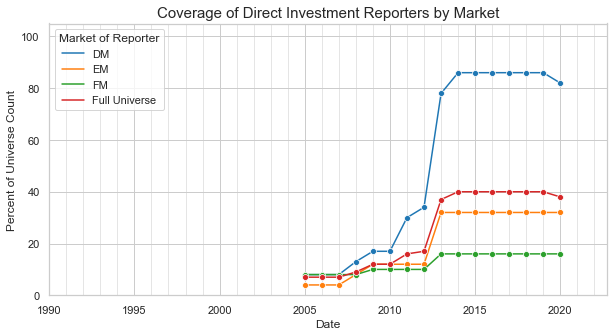

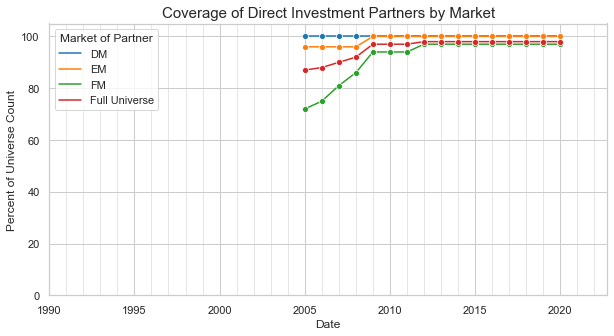

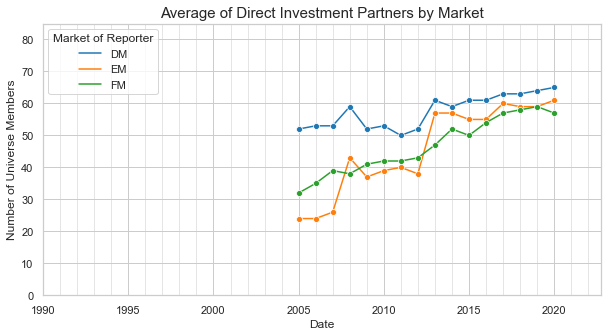

In [10]:
### OECD FDI: STATS: ASSET COVERAGE: PARTICIPANTS NUMBER

gc.collect()
### Adding regions of reporters and partners:
ser_ison_status.index.names = ['Country']
df_coverage_full = df_fdi_asset.merge(ser_ison_status, left_on = 'Reporter', right_on = 'Country').merge(ser_ison_status, left_on = 'Partner', right_on = 'Country')
df_coverage_full.rename({'Market_x': 'Reporter_Market', 'Market_y': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Coverage of Direct Investment Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
ser_iter_partners.name = 'Percent'
### Region's partners number:
dict_partners['Full Universe']  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
    ser_iter_partners.name = 'Percent'
    dict_partners[iter_region]  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Partner', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_partners.set_title('Coverage of Direct Investment Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                                .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
    ser_iter_partners.name = 'Percent'
#    dict_ave_partners[iter_region] = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
    dict_ave_partners[iter_region] = ser_iter_partners.resample('BY').last().dropna().astype(int)    
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions, marker = 'o')
ax_partners.set_title('Average of Direct Investment Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 85), ylabel = 'Number of Universe Members')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

OECD Foreign Direct Investment Assets: Total ISON Reporters number: 35
OECD Foreign Direct Investment Assets: Absent countries: ['AE', 'AR', 'AT', 'BD', 'BG', 'BH', 'BR', 'BW', 'CI', 'CN', 'CY', 'EC', 'EG', 'GH', 'HK', 'HR', 'ID', 'IN', 'JO', 'KE', 'KW', 'KZ', 'LB', 'LK', 'MA', 'MT', 'MU', 'MX', 'MY', 'NA', 'NG', 'OM', 'PA', 'PE', 'PH', 'PK', 'QA', 'RO', 'RS', 'RU', 'SA', 'SG', 'TH', 'TN', 'TW', 'UA', 'UG', 'VN', 'ZA', 'ZM']


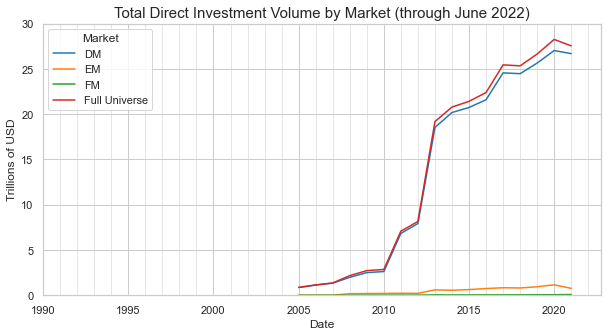

In [28]:
### OECD FDI: STATS: EXPORT VOLUME

gc.collect()
print('OECD Foreign Direct Investment Assets: Total ISON Reporters number:', str(len(df_fdi_asset['Reporter'].unique())))
print('OECD Foreign Direct Investment Assets: Absent countries:', sorted(list(set(ser_ison_status.index) - set(df_fdi_asset['Reporter']))))
### Total export volume calculation start:
dict_total_volume = {}
### ISON total volume:
ser_ison_status.index.names = ['Reporter']
df_fdi_asset_isoned = df_fdi_asset.join(ser_ison_status, on = 'Reporter')
dict_total_volume['Full Universe'] = df_fdi_asset.groupby('Date')['Value'].sum() / 1000000
### Region's total volume:
for iter_region in list_regions:
    dict_total_volume[iter_region] = df_fdi_asset_isoned[df_fdi_asset_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000
### Data consolidating:    
df_volume = pd.concat(dict_total_volume).unstack(0).resample('YS').last().stack(0).reset_index()
df_volume.columns = ['Date', 'Market', 'Volume']
df_to_plot = df_volume[df_volume['Date'] < date_end]
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Volume', hue = 'Market', hue_order = ['DM', 'EM', 'FM', 'Full Universe'])
ax_total.set_title('Total Direct Investment Volume by Market (through June 2022)', fontsize = 15)
ax_total.set(xlim = (date_start, date_end), ylabel = 'Trillions of USD', ylim = (0, 30))
### Major ticker options:    
ax_total.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_total.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_total.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_total.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

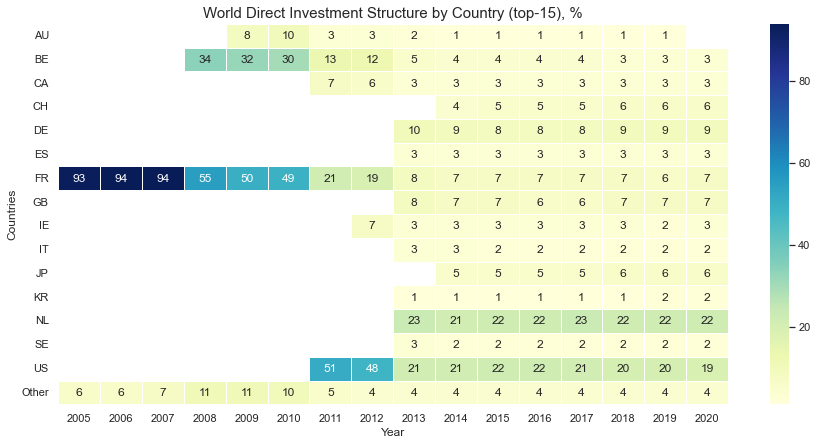

In [12]:
### OECD FDI: STATS: ASSET LEADERS

gc.collect()
### Stats parameter - leaders to plot:
int_top = 15
### Stats parameter - years to define leaders:
int_term = 10
### Country trade proprotion for each date:
ser_country_value = df_fdi_asset.groupby(['Date', 'Reporter'])['Value'].sum().dropna() / 1000000
ser_total_volume = df_fdi_asset.groupby(['Date'])['Value'].sum().dropna() / 1000000
df_country_part = (ser_country_value / ser_total_volume).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze().sort_index()
### Limited by term country trade volume:
ser_country_sum = ser_country_value.groupby('Reporter').apply(lambda ser_group: ser_group.iloc[-int_term :].sum()).sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other[ser_country_other > 0]}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f')
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Direct Investment Structure by Country (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()   

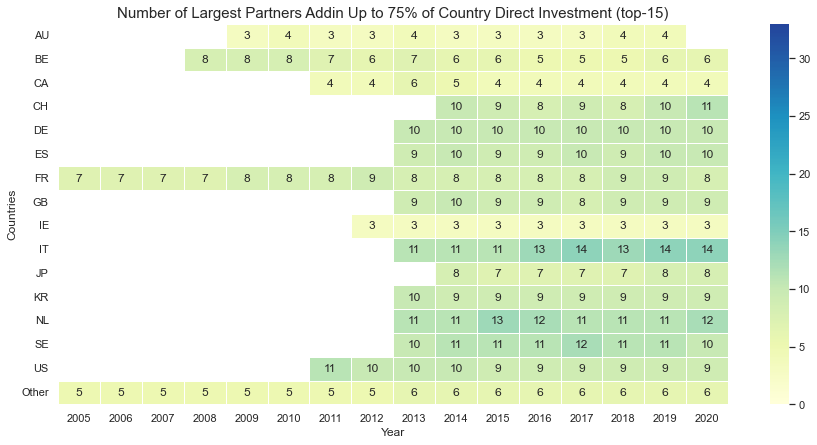

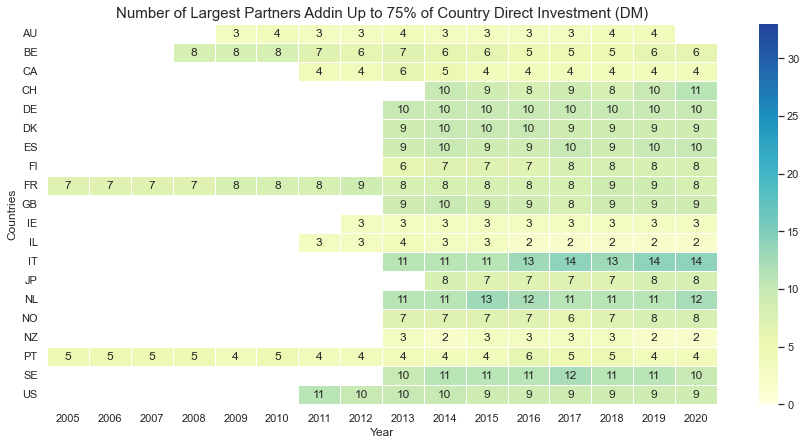

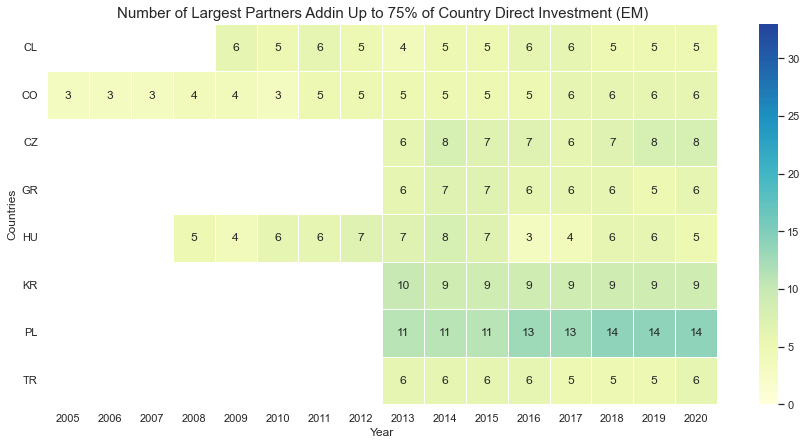

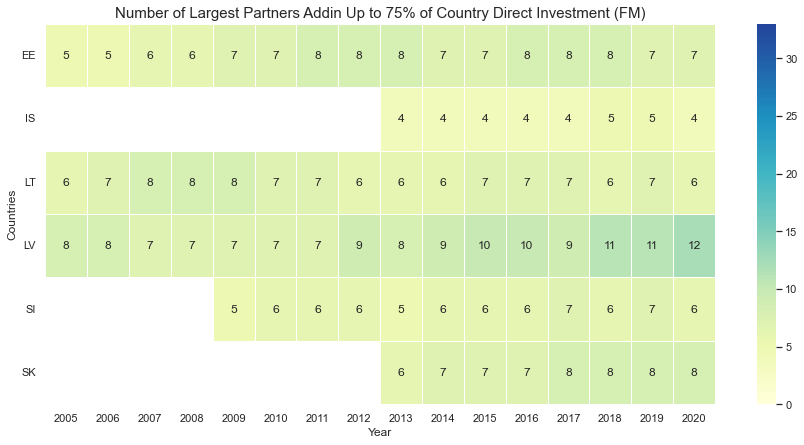

In [14]:
### OECD FDI: STATS: NUMBER OF PARTNERS TO COMPLETE FIXED % OF EXPORT FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(ser_group, flo_perc):
    ser_by_partner = ser_group.groupby(['Date', 'Partner'])['Value'].sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.75
### Stats parameter - leaders to plot:
int_top = 15
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Partners number calculation for each Date / Reporter pair:
ser_partners = df_fdi_asset.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).dropna().astype(int)
ser_partners.name = 'Number'
df_partners = ser_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Leaders data extraction for leaders plot:
df_top_part = df_partners[df_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_partners[df_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Direct Investment (top-' + str(int_top) + ')', 
                     fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_regions:
    ### Data extraction:    
    df_to_plot = df_partners.loc[df_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of Largest Partners Adding Up to ' + str(int(flo_perc * 100)) + '% of Country Direct Investment (' + iter_region + ')', 
                         fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

In [29]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

gc.collect()
### Data loading:
df_fdi_full = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset)
df_fdi_full = df_fdi_full[(df_fdi_full['Date'] > date_start) & (df_fdi_full['Date'] <= date_end)].dropna()
df_fdi_full = df_fdi_full[df_fdi_full['Value'] > 0.0]
ser_asset = df_fdi_full.loc[df_fdi_full['Position'] == 'Asset'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_liability = df_fdi_full.loc[df_fdi_full['Position'] == 'Liability'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
### Data concatenation:
ser_flows = pd.concat([ser_asset, ser_liability], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()

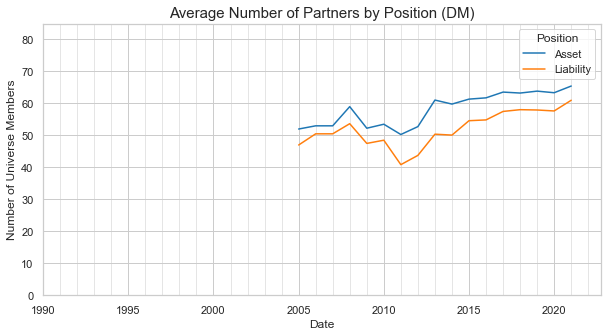

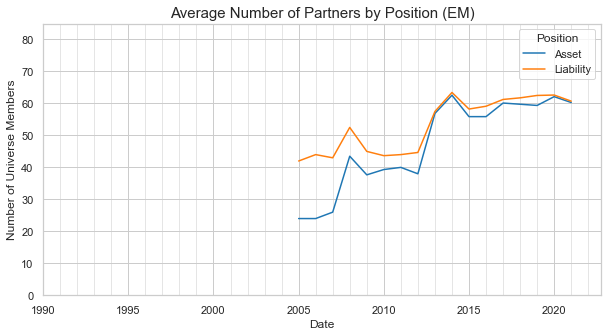

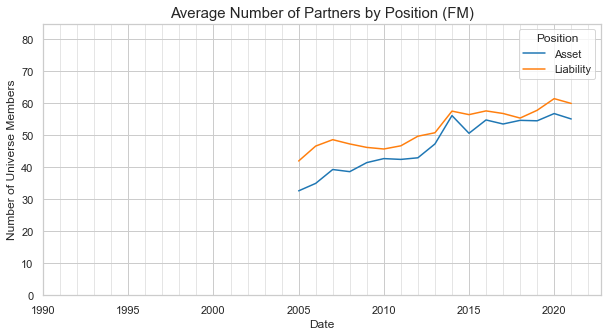

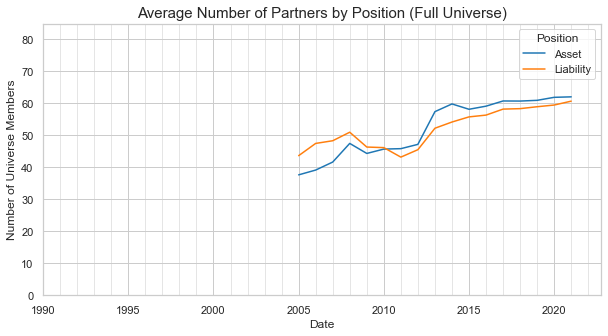

Number of observations for each position: 
 Position
Asset        21652
Liability    20881
dtype: int64


In [30]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Average partners number for Date / Reporter:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Position', 'Market']).count()
dict_obs_mean['Full Universe'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_regions:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                               .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Value', hue = 'Position', ci = None)
    ax_partners.set_title('Average Number of Partners by Position (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break
print('Number of observations for each position:', '\n', ser_flows.unstack('Position').count())

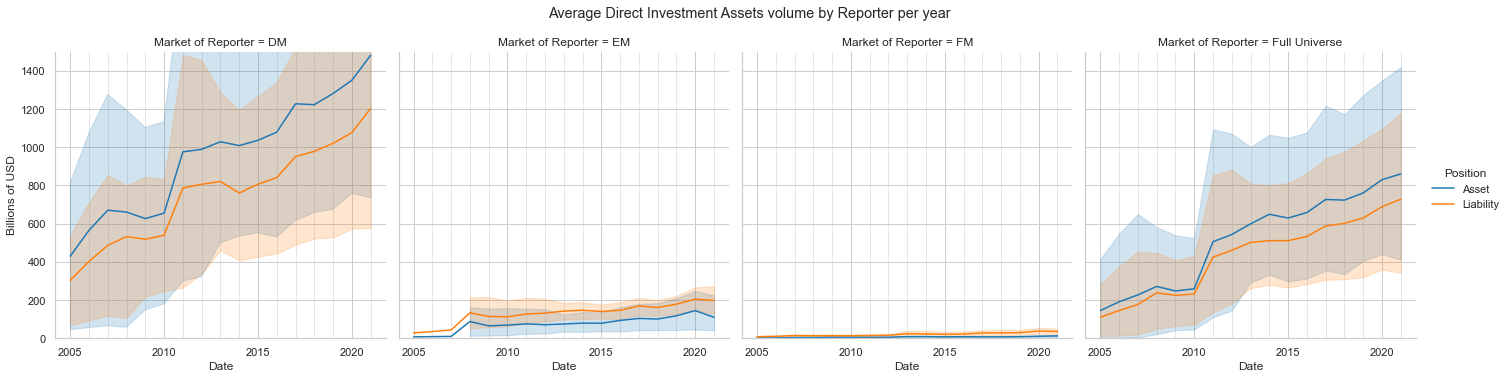

In [31]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: VOLUME COMPARING

gc.collect()
### Trade volume calculation:
dict_obs_sum = {}
ser_reporter_sum = ser_flows.groupby(['Date', 'Reporter', 'Position', 'Market']).sum() / 1000
dict_obs_sum['Full Universe'] = ser_reporter_sum.round(0).droplevel('Market').round(2).dropna()
for iter_region in list_regions:
    dict_obs_sum[iter_region] = ser_reporter_sum.loc[All, All, All, iter_region].round(2).dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_sum, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                              .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Market of Reporter', hue = 'Position', kind = 'line')
fig_mean_obs.fig.suptitle('Average Direct Investment Assets volume by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Billions of USD')
fig_mean_obs.set(ylim = (0, 1500))
### Axes customizing:
for iter_ax in fig_mean_obs.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [32]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()
### Data loading:
df_fdi_full = pd.read_hdf(path_or_buf = str_path_fdi_dataset, key = str_fdi_pos_oecd_dataset)
df_fdi_full = df_fdi_full[(df_fdi_full['Date'] > date_start) & (df_fdi_full['Date'] <= date_end)].dropna()
df_fdi_full = df_fdi_full[df_fdi_full['Value'] > 0.0]
ser_asset = df_fdi_full.loc[df_fdi_full['Position'] == 'Asset'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_liability = df_fdi_full.loc[df_fdi_full['Position'] == 'Liability'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
del df_fdi_full
gc.collect()
### Data aggregation:
ser_liability_rev = ser_liability[:]
ser_liability_rev.index.set_names('Partner_Inv', level = 1, inplace = True)
ser_liability_rev.index.set_names('Reporter', level = 2, inplace = True)
ser_liability_rev.index.set_names('Partner', level = 1, inplace = True)
ser_liability_rev = ser_liability_rev.swaplevel('Reporter', 'Partner').sort_index()
df_asset_aug = pd.concat([ser_asset.droplevel('Position'), ser_liability_rev.droplevel('Position')], axis = 1, 
                           names = 'Source Position', keys = ['Asset', 'Liability'])
df_asset_aug = df_asset_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_asset_aug = df_asset_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')

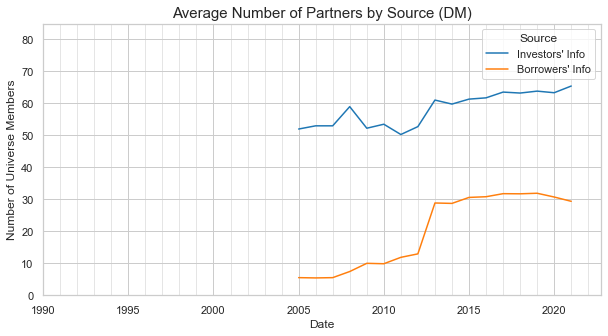

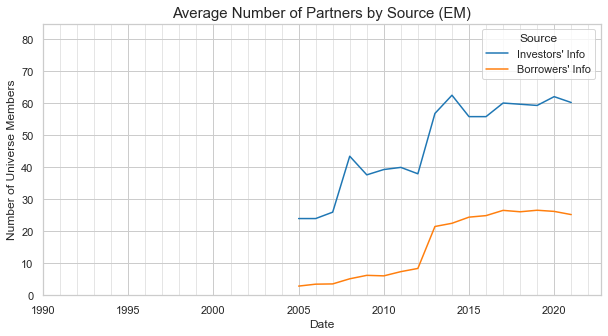

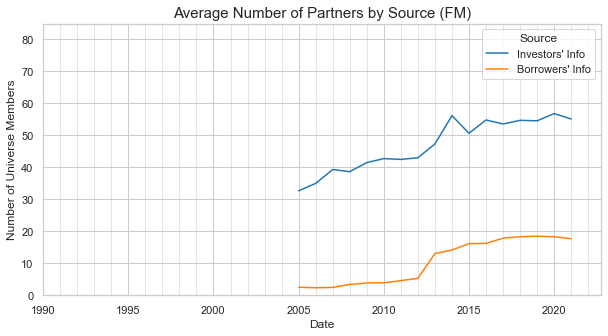

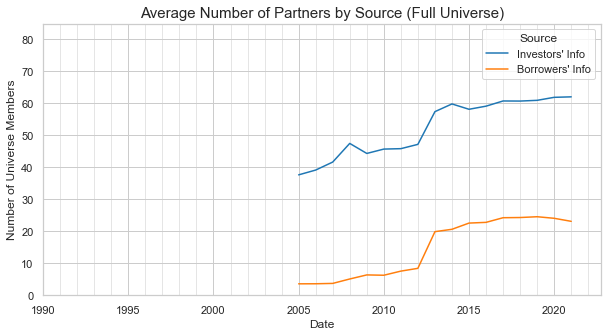

In [33]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Coverage data container:
dict_unique_mean = {}
### Partners number calculation:
dict_unique_mean['Investors\' Info'] = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).count()
dict_unique_mean['Borrowers\' Info'] = df_asset_aug['Liability'].groupby(['Date', 'Reporter', 'Market']).count()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source']).round(0).dropna().astype(int)
ser_unique_mean = ser_unique_mean[ser_unique_mean > 0]
ser_unique_mean.name = 'Number of Partners'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average partners number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Investor']).unstack(['Market of Investor', 'Reporter', 'Source']).resample('YS').last()\
                                                                                    .stack(['Market of Investor', 'Reporter']).dropna(how = 'all')\
                                                                                    .stack('Source').reset_index()
df_to_plot.rename({0: 'Number of Partners'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Number of Partners', hue = 'Source', 
                               hue_order = ['Investors\' Info', 'Borrowers\' Info'], ci = None)
    ax_partners.set_title('Average Number of Partners by Source (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

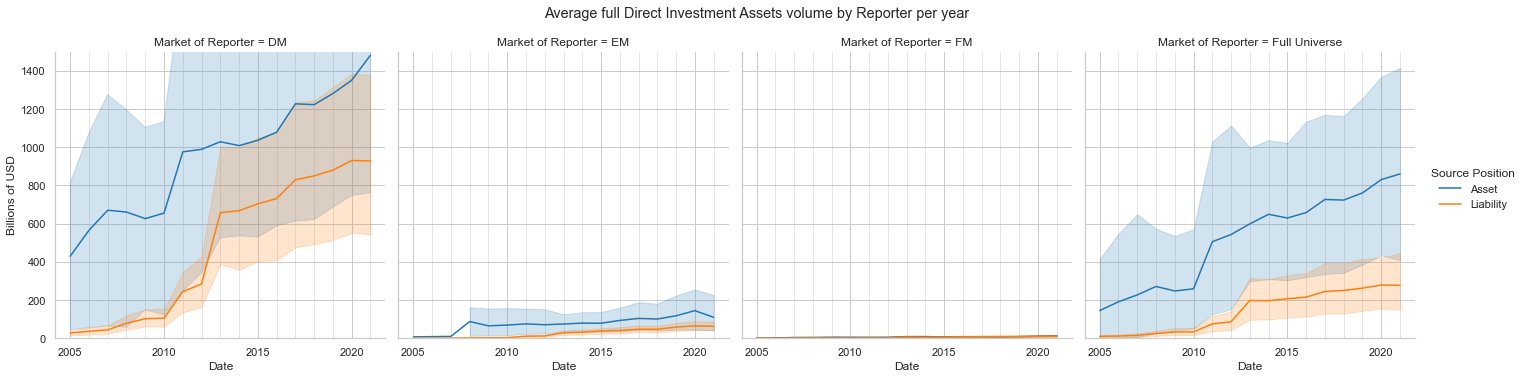

In [34]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: TOTAL OBSERVATIONS VOLUME

gc.collect()
### Valome calculation:
dict_unique_sum = {}
dict_unique_sum['Asset'] = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Liability'] = df_asset_aug['Liability'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Position']).round(2).dropna()
ser_unique_sum.name = 'Direct Investment volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market')
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region]
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Reporter'])\
               .unstack(['Market of Reporter', 'Reporter', 'Source Position']).resample('YS').last()\
               .stack(['Market of Reporter', 'Reporter', 'Source Position']).reset_index()
df_to_plot.rename({0: 'Direct Investment volume'}, axis = 1, inplace = True)
df_to_plot.sort_values(['Source Position', 'Date', 'Market of Reporter', 'Reporter'], inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Direct Investment volume', col = 'Market of Reporter', hue = 'Source Position', kind = 'line')
fig_mean_unique.fig.suptitle('Average full Direct Investment Assets volume by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 1500))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

In [31]:
### TEMP

print(df_asset_aug['Asset']['2020-12-31'].dropna().index.get_level_values('Reporter').unique())
print(df_asset_aug['Liability']['2020-12-31'].dropna().index.get_level_values('Reporter').unique())

Index(['BE', 'CA', 'CH', 'CL', 'CO', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR',
       'GB', 'GR', 'HU', 'IE', 'IL', 'IS', 'IT', 'JP', 'KR', 'LT', 'LV', 'NL',
       'NO', 'NZ', 'PL', 'PT', 'SE', 'SI', 'SK', 'TR', 'US'],
      dtype='object', name='Reporter')
Index(['AE', 'AR', 'AT', 'AU', 'BD', 'BE', 'BG', 'BH', 'BR', 'BW', 'CA', 'CH',
       'CI', 'CL', 'CN', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'EC', 'EE', 'EG',
       'ES', 'FI', 'FR', 'GB', 'GH', 'GR', 'HK', 'HR', 'HU', 'ID', 'IE', 'IL',
       'IN', 'IS', 'IT', 'JO', 'JP', 'KE', 'KR', 'KW', 'KZ', 'LB', 'LK', 'LT',
       'LV', 'MA', 'MT', 'MU', 'MX', 'MY', 'NA', 'NG', 'NL', 'NO', 'NZ', 'OM',
       'PA', 'PE', 'PH', 'PK', 'PL', 'PT', 'QA', 'RS', 'RU', 'SA', 'SE', 'SG',
       'SI', 'SK', 'TH', 'TN', 'TR', 'TW', 'UA', 'UG', 'US', 'VN', 'ZA', 'ZM'],
      dtype='object', name='Reporter')


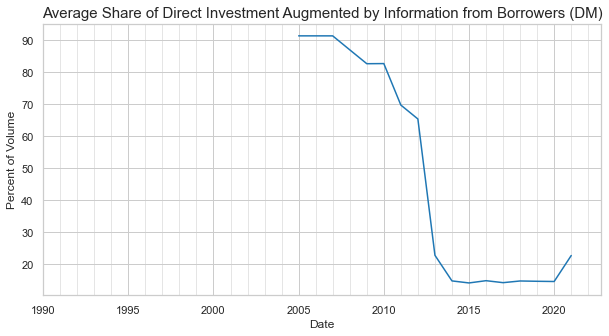

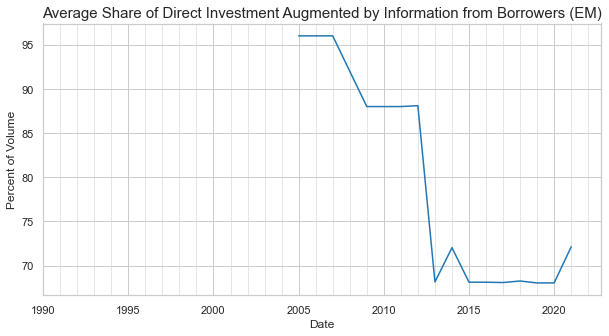

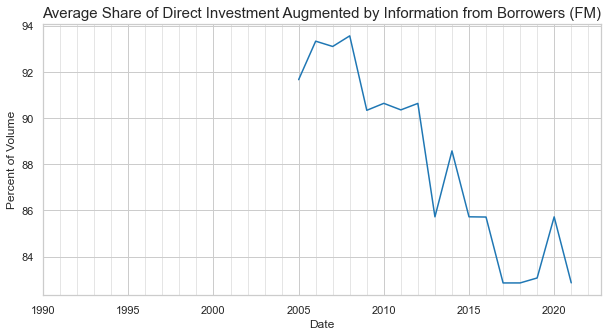

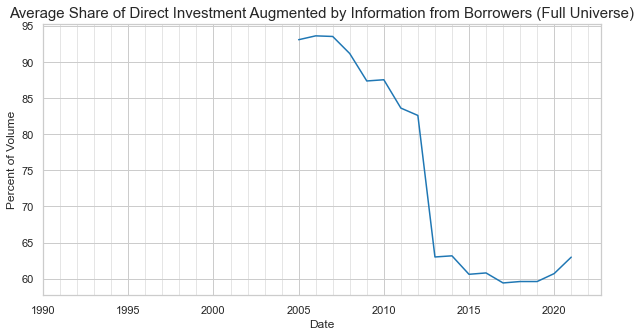

In [35]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: UNIQUE INVERTED LIABILITIES VOLUME

gc.collect()
### Unique inverted import data filtering:
ser_liability_unique = df_asset_aug.loc[df_asset_aug['Asset'].isna() & df_asset_aug['Liability'].notna(), 'Liability']\
                                 .groupby(['Date', 'Reporter', 'Market']).sum()
ser_liability_unique_ann = ser_liability_unique.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_liability_unique_ann.name = 'Added Volume'
### Unique inverted import by Market grouping:
dict_unique_liability = {}
dict_unique_liability['Full Universe'] = ser_liability_unique_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_liability[iter_region] = ser_liability_unique_ann.loc[All, All, iter_region].dropna()
ser_liability_isoned = pd.concat(dict_unique_liability, axis = 0, names = ['Market of Investor'])
### Total export data filtering:
ser_asset_total = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum()
ser_asset_total_ann = ser_asset_total.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_asset_total_ann.name = 'Asset Volume'
### Total export by Market grouping:
dict_asset_total = {}
dict_asset_total['Full Universe'] = ser_asset_total_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_asset_total[iter_region] = ser_asset_total_ann.loc[All, All, iter_region].dropna()
ser_asset_isoned = pd.concat(dict_asset_total, axis = 0, names = ['Market of Investor'])
### Share of Export Augmented by Information from Importers:
ser_share = (ser_liability_isoned.fillna(0) / (ser_liability_isoned.fillna(0) + ser_asset_isoned.fillna(0)) * 100).round(2)
### Dataset to draw:
df_to_plot = ser_share.unstack(['Market of Investor', 'Reporter']).resample('YS').last().stack(['Market of Investor', 'Reporter']).reset_index()
df_to_plot.rename({0: 'Share Added'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_share = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Share Added', ci = None)
    ax_share.set_title('Average Share of Direct Investment Augmented by Information from Borrowers (' + iter_region + ')', fontsize = 15)
    ax_share.set(xlim = (date_start, date_end), ylabel = 'Percent of Volume')#, ylim = (0, 12))
    ### Major ticker options:    
    ax_share.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_share.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_share.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_share.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()

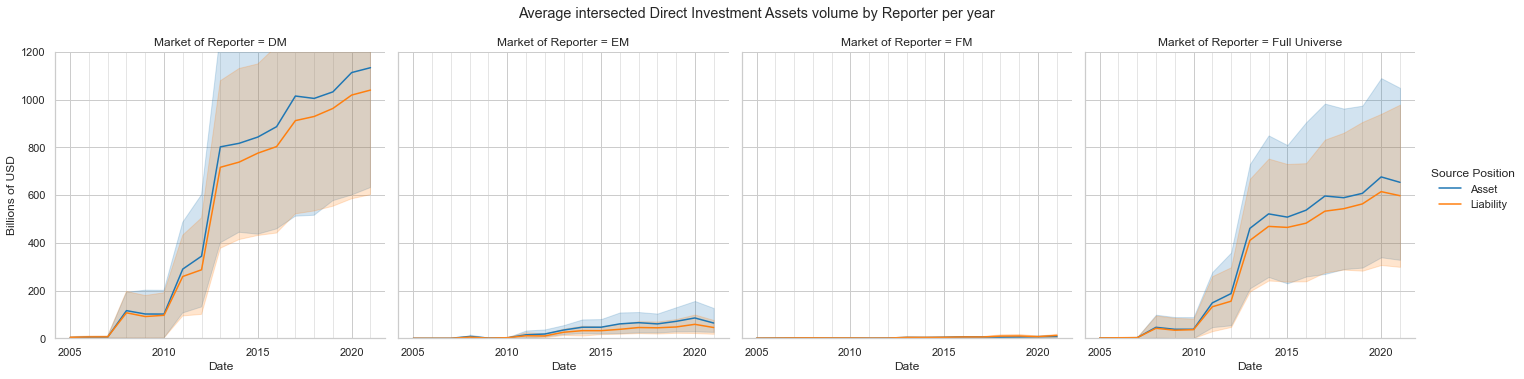

In [36]:
### OECD FDI: LIABILITY OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS VOLUME

gc.collect()

dict_unique_sum = {}
dict_unique_sum['Asset'] = df_asset_aug.dropna()['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Liability'] = df_asset_aug.dropna()['Liability'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Position']).round(2)
ser_unique_sum.name = 'Direct Investment volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Reporter'])\
               .unstack(['Market of Reporter', 'Reporter', 'Source Position']).resample('YS').last()\
               .stack(['Market of Reporter', 'Reporter', 'Source Position']).reset_index()
df_to_plot.rename({0: 'Direct Investment volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Direct Investment volume', col = 'Market of Reporter', hue = 'Source Position', kind = 'line')
fig_mean_unique.fig.suptitle('Average intersected Direct Investment Assets volume by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 1200))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

In [37]:
### TEMP

gc.collect()
#print(ser_inter_sum[ser_inter_sum > 0.0].sum())
#print(ser_unique_sum[ser_unique_sum > 0.0].sum())
ser_inter_exp = df_asset_aug.dropna()['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_total_exp = df_asset_aug['Asset'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = df_asset_aug.loc[df_asset_aug['Asset'].notna() & df_asset_aug['Liability'].isna(), 'Asset']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
print('Total:', ser_total_exp.sum())
print('Intersected:', ser_inter_exp.sum())
print('Unique:', ser_unique_exp.sum())
print('Sum:', ser_inter_exp.sum() + ser_unique_exp.sum())
print('Percent of unique:', ser_unique_exp.sum() / ser_total_exp.sum() * 100)

Total: 243250.16680388007
Intersected: 179622.33977972664
Unique: 63627.82702415344
Sum: 243250.16680388007
Percent of unique: 26.157362134700296


In [38]:
### OECD FDI: LIABILITY DATA INCORPORATION:

### Combining Export & Import data:
df_asset_aug['Asset_Augmented'] = df_asset_aug['Asset'].combine_first(df_asset_aug['Liability'])

In [ ]:
### IMF CPIS: LIABILITY OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()

df_options_sum = df_asset_aug.groupby(['Date', 'Reporter', 'Market']).sum() / 1000
df_options_sum.columns = ['Asset', 'Liability', 'Augmented Asset']
ser_options_sum = df_options_sum[['Asset', 'Augmented Asset']].reset_index()\
                        .melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Position', value_name = 'Asset_Volume')\
                        .set_index(['Date', 'Reporter', 'Market', 'Position']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['Full Universe'] = ser_options_sum.dropna().droplevel('Market')
for iter_region in list_regions:
    dict_options_sum[iter_region] = ser_options_sum.dropna().loc[All, All, iter_region, All]
### Export volume plotting:
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Reporter']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_volume = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Asset_Volume', hue = 'Position', ci = None)
    ax_volume.set_title('Average Augmented Asset Volume (' + iter_region + ')', fontsize = 15)
    ax_volume.set(xlim = (date_start, date_end), ylabel = 'Billions of USD')
    ### Major ticker options:    
    ax_volume.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_volume.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_volume.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_volume.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

In [40]:
### OECD FDI: LIABILITY DATA INCORPORATION: RESULTS SAVING

### Dataset saving:
df_asset_aug = df_asset_aug.astype('float32')
df_asset_aug = df_asset_aug.reset_index()
df_asset_aug = df_asset_aug.astype({'Reporter': 'category', 'Partner': 'category', 'Market': 'category'})
df_asset_aug.to_hdf(path_or_buf = str_path_oecd_fdi_combined, key = str_full_oecd_fdi_combined, mode = 'w', format = 'table')
del df_asset_aug
gc.collect()

16817

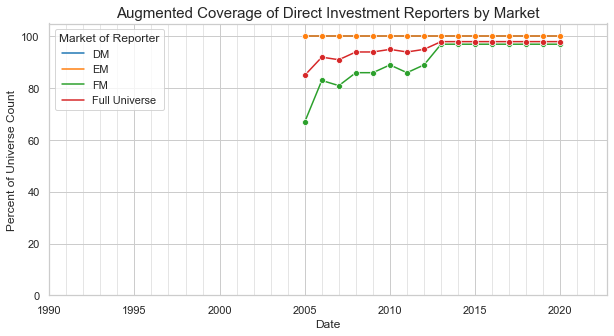

In [103]:
### OECD FDI: NUMBER OF REPORTERS CHANGE

dict_reporters = {}
### Data loading:
ser_oecd_fdi = pd.read_hdf(path_or_buf = str_path_oecd_fdi_combined, key = str_full_oecd_fdi_combined).set_index(['Date', 'Reporter', 'Partner', 'Market'])\
                                                                                                                        .sort_index()['Asset_Augmented'].dropna()
### Total reporters number:
ser_iter_reporters = ser_oecd_fdi.groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = ser_oecd_fdi[:, :, :, iter_region].groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Augmented Coverage of Direct Investment Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

Last date reported: 2020-12-31 00:00:00


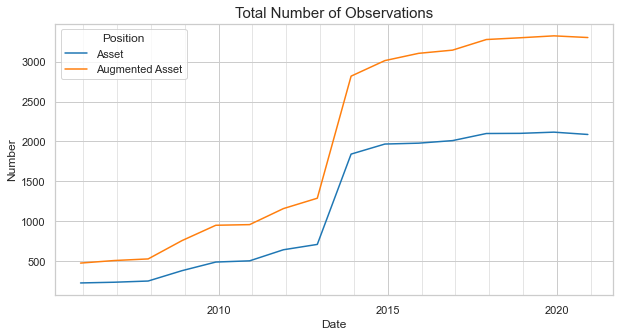

In [34]:
### OECD FDI: DATA FRESHNESS

df_oecd_fdi = pd.read_hdf(path_or_buf = str_path_oecd_fdi_combined, key = str_full_oecd_fdi_combined).set_index(['Date', 'Reporter', 'Partner'])\
                                                                                                      .sort_index()[['Asset', 'Asset_Augmented']]
df_oecd_fdi.columns = ['Asset', 'Augmented Asset']
ser_oecd_fdi = df_oecd_fdi.stack().sort_index()
ser_oecd_fdi.index.names = ['Date', 'Reporter', 'Partner', 'Position']
print('Last date reported:', ser_oecd_fdi.index.get_level_values('Date').max())
df_to_plot = ser_oecd_fdi.groupby(['Date', 'Position']).count().sort_index().unstack('Position').resample('MS').last().stack('Position').reset_index()
df_to_plot.rename({0: 'Number'}, axis = 1, inplace = True)
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_number = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Number', hue = 'Position', hue_order = ['Asset', 'Augmented Asset'])
ax_number.set_title('Total Number of Observations', fontsize = 15)
### Major ticker options:    
ax_number.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_number.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_number.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_number.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [55]:
### BIS LBS: BILATERAL BANK LENDING

In [56]:
### BIS LBS: GET LBS DATAFLOW

### Session start:
request_session = requests.Session()
str_bis_base_url = 'https://stats.bis.org/api/v1/'
str_bis_dataflow_add = 'dataflow/BIS/all/latest?references=none&detail=allstubs'
### SDMX structure of dataflows list loading:
obj_bis_dataflow_list = request_session.get(str_bis_base_url + str_bis_dataflow_add)
xml_tree_root = et.fromstring(obj_bis_dataflow_list.content)
### Searching for LBS dataflow:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    str_dataflow_description = xml_tree_child_level_2[0].text
                    if ((str_dataflow_description.find('BIS') > -1) & (str_dataflow_description.find('location') > -1) & (str_dataflow_description.find('bank') > -1)):
                        str_dataflow_id = xml_tree_child_level_2.attrib['id']
                        print(str_dataflow_description, ':', str_dataflow_id)  

BIS locational banking : WS_LBS_D_PUB


In [57]:
### BIS LBS: GET LBS DATA STRUCTURE

str_bis_data_structure_add = 'structure/BIS/' + str_dataflow_id + '/latest?references=none&detail=full'
### SDMX structure of dataflow loading:
obj_bis_data_stucture = request_session.get(str_bis_base_url + str_bis_data_structure_add)
xml_tree_root = et.fromstring(obj_bis_data_stucture.content)
### Searching for LBS datastructure:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('Dataflows'):
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('Dataflow'):
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('Structure'):
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    str_data_structure_id = xml_tree_child_level_4.attrib['id']
                                    print('Datastructure:', str_data_structure_id)

Datastructure: BIS_LBS_DISS


In [58]:
### BIS LBS: GET LBS REQUEST STRUCTURE

str_bis_request_structure_add = 'datastructure/BIS/' + str_data_structure_id + '/latest?references=none&detail=full'
### SDMX request structure list loading:
obj_bis_request_stucture = request_session.get(str_bis_base_url + str_bis_request_structure_add)
xml_tree_root = et.fromstring(obj_bis_request_stucture.content)
### Dummy containers creating:
dict_concepts = {}
dict_codelists = {}
### LBS request positions collecting:
for xml_tree_child_level_0 in xml_tree_root:
    if xml_tree_child_level_0.tag.endswith('Structures'):
        for xml_tree_child_level_1 in xml_tree_child_level_0:
            if xml_tree_child_level_1.tag.endswith('DataStructures'):            
                for xml_tree_child_level_2 in xml_tree_child_level_1:
                    if xml_tree_child_level_2.tag.endswith('DataStructure'):  
                        for xml_tree_child_level_3 in xml_tree_child_level_2:
                            if xml_tree_child_level_3.tag.endswith('DataStructureComponents'): 
                                for xml_tree_child_level_4 in xml_tree_child_level_3:
                                    if xml_tree_child_level_4.tag.endswith('DimensionList'):           
                                        for xml_tree_child_level_5 in xml_tree_child_level_4:
                                            if xml_tree_child_level_5.tag.endswith('Dimension'):
                                                int_position = int(xml_tree_child_level_5.attrib['position'])
                                                for xml_tree_child_level_6 in xml_tree_child_level_5:
                                                    if xml_tree_child_level_6.tag.endswith('ConceptIdentity'):
                                                        for xml_tree_child_level_7 in xml_tree_child_level_6:
                                                            if xml_tree_child_level_7.tag.endswith('Ref'):
                                                                dict_concepts[int_position] = xml_tree_child_level_7.attrib['id']
                                                    elif xml_tree_child_level_6.tag.endswith('LocalRepresentation'):
                                                        for xml_tree_child_level_7 in xml_tree_child_level_6:
                                                            if xml_tree_child_level_7.tag.endswith('Enumeration'):
                                                                for xml_tree_child_level_8 in xml_tree_child_level_7:
                                                                    if xml_tree_child_level_8.tag.endswith('Ref'):
                                                                        dict_codelists[int_position] = xml_tree_child_level_8.attrib['id']
### LBS request structure consolidating:                                                                        
df_lbs_concept = pd.concat([pd.Series(dict_concepts), pd.Series(dict_codelists)], axis = 1, keys = ['Concept', 'Codelist'])
print('Request structure:\n', df_lbs_concept)

Request structure:
             Concept            Codelist
1              FREQ             CL_FREQ
2         L_MEASURE       CL_STOCK_FLOW
3        L_POSITION       CL_L_POSITION
4           L_INSTR          CL_L_INSTR
5           L_DENOM    CL_CURRENCY_3POS
6       L_CURR_TYPE      CL_L_CURR_TYPE
7      L_PARENT_CTY  CL_BIS_IF_REF_AREA
8   L_REP_BANK_TYPE      CL_L_BANK_TYPE
9         L_REP_CTY  CL_BIS_IF_REF_AREA
10      L_CP_SECTOR         CL_L_SECTOR
11     L_CP_COUNTRY  CL_BIS_IF_REF_AREA
12       L_POS_TYPE       CL_L_POS_TYPE
13      TIME_PERIOD                 NaN


In [59]:
### BIS LBS: GET LBS CONCEPTS OPTIONS

### Dummy container creating:
df_lbs_concept['Options'] = np.NaN
### Searching for LBS concepts options:
for iter_pos, iter_row in df_lbs_concept.iterrows():
    if isinstance(iter_row['Codelist'], str):
        dict_options = {}
        str_lbs_codelist_add = 'codelist/BIS/' + iter_row['Codelist'] + '/latest?references=none&detail=full'
        ### SDMX codelist options list loading:
        obj_bis_codelist_options = request_session.get(str_bis_base_url + str_lbs_codelist_add)
        xml_tree_root = et.fromstring(obj_bis_codelist_options.content)
        ### LBS reqCodelists options collecting:
        for xml_tree_child_level_0 in xml_tree_root:
            if xml_tree_child_level_0.tag.endswith('Structures'):
                for xml_tree_child_level_1 in xml_tree_child_level_0:
                    if xml_tree_child_level_1.tag.endswith('Codelists'):
                        for xml_tree_child_level_2 in xml_tree_child_level_1:
                            if xml_tree_child_level_2.tag.endswith('Codelist'):
                                for xml_tree_child_level_3 in xml_tree_child_level_2:
                                    if xml_tree_child_level_3.tag.endswith('Code'):
                                        str_option_id = xml_tree_child_level_3.attrib['id']
                                        for xml_tree_child_level_4 in xml_tree_child_level_3:
                                            if xml_tree_child_level_4.tag.endswith('Name'):
                                                dict_options[str_option_id] = xml_tree_child_level_4.text
        iter_row['Options'] = dict_options
        df_lbs_concept.loc[iter_pos] = iter_row
        
print('Request structure & options:\n', df_lbs_concept)

Request structure & options:
             Concept            Codelist  \
1              FREQ             CL_FREQ   
2         L_MEASURE       CL_STOCK_FLOW   
3        L_POSITION       CL_L_POSITION   
4           L_INSTR          CL_L_INSTR   
5           L_DENOM    CL_CURRENCY_3POS   
6       L_CURR_TYPE      CL_L_CURR_TYPE   
7      L_PARENT_CTY  CL_BIS_IF_REF_AREA   
8   L_REP_BANK_TYPE      CL_L_BANK_TYPE   
9         L_REP_CTY  CL_BIS_IF_REF_AREA   
10      L_CP_SECTOR         CL_L_SECTOR   
11     L_CP_COUNTRY  CL_BIS_IF_REF_AREA   
12       L_POS_TYPE       CL_L_POS_TYPE   
13      TIME_PERIOD                 NaN   

                                              Options  
1   {'A': 'Annual', 'B': 'Daily - business week (n...  
2   {'F': 'FX and break adjusted change (BIS calcu...  
3   {'B': 'Local claims', 'C': 'Total claims', 'D'...  
4   {'A': 'All instruments', 'D': 'Debt securities...  
5   {'ADP': 'Andorran Peseta', 'AED': 'UAE dirham'...  
6   {'A': 'All currencies (=D+F

In [34]:
### BIS LBS: SELECTING LBS CONCEPTS OPTIONS

int_pos = 9
# 1 to 12
print(df_lbs_concept.loc[int_pos, 'Concept'], '/', df_lbs_concept.loc[int_pos, 'Codelist'], ':\n', end = '')
print(pd.Series(df_lbs_concept.loc[int_pos, 'Options']))
#  1 - FREQUENCY - 'Q': 'Quaterly'
#  2 - MEASURE - 'S': Amounts outstanding / Stocks'
#  3 - BALANCE SHEET POSITION - 'C': 'Total claims' / 'L': 'Total liabilities'
#  4 - TYPE OF INSTRUMENTS - 'A': 'All instruments'
#  5 - CURRENCY DENOMINATION - 'TO1': 'All currencies'
#  6 - CURRENCY TYPE - 'A': 'All currencies'
#  7 - PARENT COUNTRY - '5J': 'All countries'
#  8 - TYPE OF REPORTING INSTITUTION - 'A': 'All reporting banks/institutions (domestic, foreign, consortium and unclassified)'
#  9 - REPORTING COUNTRY - we need to construct request for all ISON countries as reporters
# 10 - COUNTERPARTY SECTOR - 'A': 'All sectors'
# 11 - COUNTERPARTY COUNTRY - we need to construct request for all ISON countries as partners
# 12 - POSITION TYPE - 'N': 'Cross-border'
# 13 - TIME PERIOD

L_REP_CTY / CL_BIS_IF_REF_AREA :
00                                               Others
11    Technical residual (Non-residents / Cross-border)
1A                         US banks in offshore centres
1B                     International banking facilities
1C                          International organisations
                            ...                        
ZA                                         South Africa
ZM                                               Zambia
ZR                                                Zaire
ZW                                             Zimbabwe
_Z                                       Not applicable
Length: 426, dtype: object


In [35]:
### TEMP

pd.Series(df_lbs_concept.loc[int_pos, 'Options']).loc['5J']

'All countries (total)'

In [60]:
### BIS LBS: ANNUAL REQUESTS

### Container initializing:
list_lbs_data = []
### Looping over needed date range year-by year:
for iter_year in range(date_start.year, date_end.year + 1): # [1989, 1990]: # 
    str_bis_data_year_add = 'data/' + str_dataflow_id + '/Q.S..A.TO1.A.5J.A..A..N/all?startPeriod=' \
                            + str(iter_year) + '-Q1&endPeriod=' + str(iter_year) + '-Q4&detail=dataonly'    
    ### SDMX structure of dataflow loading:
    obj_bis_data_annual = request_session.get(str_bis_base_url + str_bis_data_year_add)
    xml_tree_root = et.fromstring(obj_bis_data_annual.content)
    ### LBS data collecting:
    for xml_tree_child_level_0 in xml_tree_root:
        if xml_tree_child_level_0.tag.endswith('DataSet'):
            for xml_tree_child_level_1 in xml_tree_child_level_0:
                if xml_tree_child_level_1.tag.endswith('Series'):
                    ### Series attributes getting:
                    str_position = xml_tree_child_level_1.attrib['L_POSITION']
                    str_rep_country = xml_tree_child_level_1.attrib['L_REP_CTY']
                    str_cp_country = xml_tree_child_level_1.attrib['L_CP_COUNTRY']
                    ### Series values getting:
                    dict_values = {}
                    for xml_tree_child_level_2 in xml_tree_child_level_1:
                        if xml_tree_child_level_2.tag.endswith('Obs'):
                            dict_values[xml_tree_child_level_2.attrib['TIME_PERIOD']] = xml_tree_child_level_2.attrib['OBS_VALUE']
                    ### Transforming data to series:
                    list_lbs_data.append(pd.concat([pd.Series(dict_values)], keys = [(str_position, str_rep_country, str_cp_country)], 
                                                    names = ['Position', 'Reporter_ID', 'Partner_ID']))
    print(str(iter_year), ': data loaded')

1989 : data loaded
1990 : data loaded
1991 : data loaded
1992 : data loaded
1993 : data loaded
1994 : data loaded
1995 : data loaded
1996 : data loaded
1997 : data loaded
1998 : data loaded
1999 : data loaded
2000 : data loaded
2001 : data loaded
2002 : data loaded
2003 : data loaded
2004 : data loaded
2005 : data loaded
2006 : data loaded
2007 : data loaded
2008 : data loaded
2009 : data loaded
2010 : data loaded
2011 : data loaded
2012 : data loaded
2013 : data loaded
2014 : data loaded
2015 : data loaded
2016 : data loaded
2017 : data loaded
2018 : data loaded
2019 : data loaded
2020 : data loaded
2021 : data loaded
2022 : data loaded


In [61]:
### BIS LBS: DATA MANIPULATING

gc.collect()
### Converting container to series:
ser_lbs_quarter = pd.concat(list_lbs_data)
### Period index preparing:
ser_lbs_quarter.index.names = ser_lbs_quarter.index.names[: -1] + ['Quarter']
ser_lbs_quarter.index = ser_lbs_quarter.index.set_levels(pd.to_datetime(ser_lbs_quarter.index.levels[-1]) + pd.offsets.BQuarterEnd(), level = 'Quarter')
### ISON filtering:
set_ison_countries = set(ser_ison_membership.index.get_level_values(1))
ser_lbs_quarter = ser_lbs_quarter.loc[All, list(set_ison_countries), list(set_ison_countries), All]
#### Data type casting:
ser_lbs_quarter = ser_lbs_quarter.astype(float).sort_index()
### Zero years to NaN (there are no full zero years in original quaterly data) after resampling:
ser_lbs_quarter = ser_lbs_quarter.replace({0.0: np.NaN})
### Index ordering:
ser_lbs_quarter.index.names = ser_lbs_quarter.index.names[: -1] + ['Date']
ser_lbs_quarter = ser_lbs_quarter.reorder_levels([0, 3, 1, 2])
ser_lbs_quarter.name = 'Value'
#### Resampling to annual frequency:
#ser_lbs_year = ser_lbs_quarter.groupby(['Position', 'Reporter_ID', 'Partner_ID'])\
#                              .apply(lambda iter_group: iter_group.droplevel(['Position', 'Reporter_ID', 'Partner_ID']).resample('BY').sum())
#### Zero years to NaN (there are no full zero years in original quaterly data) after resampling:
#ser_lbs_year = ser_lbs_year.replace({0.0: np.NaN})
#### Index ordering:
#ser_lbs_year.index.names = ser_lbs_year.index.names[: -1] + ['Date']
#ser_lbs_year = ser_lbs_year.reorder_levels([0, 3, 1, 2])
#ser_lbs_year.name = 'Value'

In [62]:
### BIS LBS: DATA AGGREGATION & SAVING

df_lbs_full = pd.concat([ser_lbs_quarter.loc['C'], ser_lbs_quarter.loc['L']], axis = 1, keys = ['Claim', 'Liability'])
df_lbs_full = df_lbs_full.reset_index().melt(id_vars = ['Date', 'Reporter_ID', 'Partner_ID'], var_name = 'Position', value_name = 'Value')
df_lbs_full.rename({'Reporter_ID': 'Reporter', 'Partner_ID': 'Partner'}, axis = 1, inplace = True)
df_lbs_full = df_lbs_full.astype({'Reporter': 'category', 'Partner': 'category', 'Position': 'category', 'Value': float})
df_lbs_full.to_hdf(path_or_buf = str_path_bis_dataset, key = str_full_bis_dataset, format = 'table', mode = 'w')

In [14]:
### BIS LBS: DATA LOADING

df_lbs_full = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_full_bis_dataset)
df_lbs_claim = df_lbs_full[(df_lbs_full['Position'] == 'Claim') & (df_lbs_full['Date'] > date_start) & (df_lbs_full['Date'] <= date_end)].dropna()

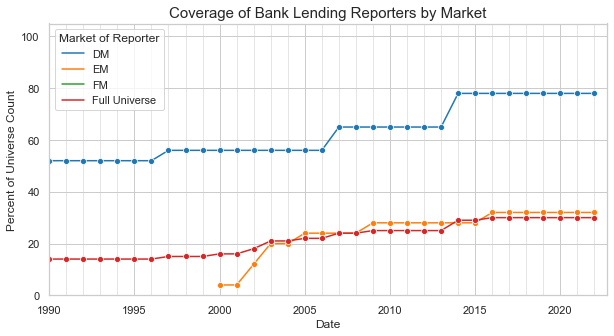

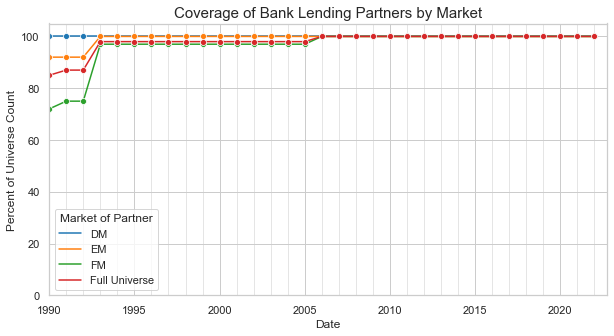

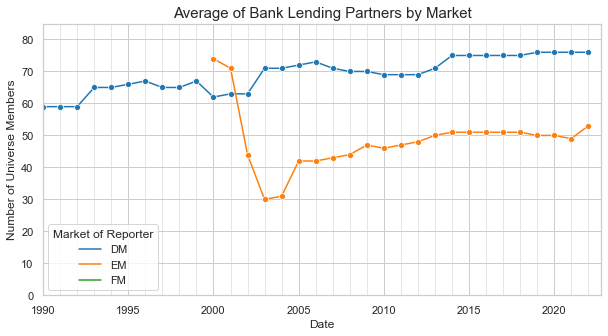

In [15]:
### BIS LBS: STATS: CLAIM COVERAGE: PARTICIPANTS NUMBER

gc.collect()
### Adding regions of reporters and partners:
ser_ison_status.index.names = ['Country']
df_coverage_full = df_lbs_claim.merge(ser_ison_status, left_on = 'Reporter', right_on = 'Country').merge(ser_ison_status, left_on = 'Partner', right_on = 'Country')
df_coverage_full.rename({'Market_x': 'Reporter_Market', 'Market_y': 'Partner_Market'}, axis = 1, inplace = True)
### Reporters number calculation start:
dict_reporters = {}
### Total reporters number:
ser_iter_reporters = df_coverage_full.groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                            .groupby('Date')['Reporter'].apply(lambda ser_date: len(ser_date.unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Coverage of Bank Lending Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Partners number calculation start:
dict_partners = {}
### Total partners number:
ser_iter_partners = df_coverage_full.groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
ser_iter_partners.name = 'Percent'
### Region's partners number:
dict_partners['Full Universe']  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
for iter_region in list_regions:
    ser_iter_partners = df_coverage_full[df_coverage_full['Partner_Market'] == iter_region]\
                            .groupby('Date')['Partner'].apply(lambda ser_date: len(ser_date.dropna().unique()))
    ser_iter_partners.name = 'Percent'
    dict_partners[iter_region]  = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:        
df_partners = pd.concat(dict_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Partner', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Partner', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_partners.set_title('Coverage of Bank Lending Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()
### Average partners number calculation start:
dict_ave_partners = {}
### Region's partners average number:
for iter_region in list_regions:
    if (len(df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]) > 0):
        ser_iter_partners = df_coverage_full[df_coverage_full['Reporter_Market'] == iter_region]\
                                    .groupby(['Date', 'Reporter'])['Partner'].apply(lambda ser_date: len(ser_date.unique())).groupby('Date').mean().astype(int)
        ser_iter_partners.name = 'Percent'
    #    dict_ave_partners[iter_region] = (ser_iter_partners.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
        dict_ave_partners[iter_region] = ser_iter_partners.resample('BY').last().dropna().astype(int)    
### Data consolidating:         
df_partners = pd.concat(dict_ave_partners, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_partners.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_partners[df_partners['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_partners = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions, marker = 'o')
ax_partners.set_title('Average of Bank Lending Partners by Market', fontsize = 15)
ax_partners.set(xlim = (date_start, date_end), ylim = (0, 85), ylabel = 'Number of Universe Members')
### Major ticker options:    
ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

BIS LBS: Total ISON Reporters number: 26
BIS LBS: Absent countries: {'RO', 'SI', 'NG', 'NA', 'KE', 'IN', 'KW', 'BH', 'KZ', 'UG', 'SK', 'BG', 'SG', 'QA', 'MT', 'RS', 'CN', 'UA', 'GH', 'EE', 'PA', 'IL', 'SA', 'CR', 'MA', 'NZ', 'RU', 'JO', 'BW', 'AR', 'PK', 'PT', 'HR', 'MU', 'LK', 'CO', 'LB', 'AE', 'HU', 'NO', 'LV', 'EC', 'CZ', 'TN', 'ID', 'VN', 'PE', 'ZM', 'TH', 'OM', 'LT', 'BD', 'EG', 'PL', 'MY', 'IS', 'CY', 'CI', 'TR'}


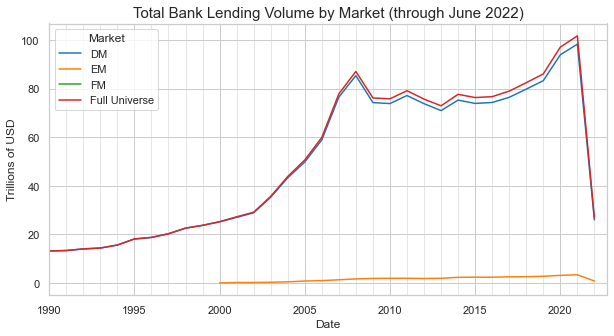

In [16]:
### BIS LBS: STATS: CLAIM VOLUME

gc.collect()
print('BIS LBS: Total ISON Reporters number:', str(len(df_lbs_claim['Reporter'].unique())))
print('BIS LBS: Absent countries:', (set(ser_ison_status.index) - set(df_lbs_claim['Reporter'].unique())))
### Total export volume calculation start:
ser_lbs_claim_ann = df_lbs_claim.groupby(['Reporter', 'Partner']).apply(lambda df_group: df_group.set_index('Date').resample('BY').sum())\
                                    .squeeze().reorder_levels([2, 0, 1])
ser_lbs_claim_ann = ser_lbs_claim_ann[ser_lbs_claim_ann > 0.0]
dict_total_volume = {}
### ISON total volume:
ser_total_volume = ser_lbs_claim_ann.dropna().groupby('Date').sum() / 1000000
dict_total_volume['Full Universe'] = ser_total_volume
ser_ison_status.index.names = ['Reporter']
df_lbs_claim_isoned = ser_lbs_claim_ann.dropna().to_frame().join(ser_ison_status, on = 'Reporter')
### Region's total volume:
for iter_region in list_regions:
    ser_iter_volume = df_lbs_claim_isoned[df_lbs_claim_isoned['Market'] == iter_region].groupby('Date')['Value'].sum() / 1000000
    dict_total_volume[iter_region] = ser_iter_volume
### Data consolidating:    
df_volume = pd.concat(dict_total_volume).unstack(0).resample('YS').last().stack(0).reset_index()
df_volume.columns = ['Date', 'Market', 'Volume']
df_to_plot = df_volume[df_volume['Date'] < date_end]
### Total export volume plotting
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_total = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Volume', hue = 'Market', hue_order = ['DM', 'EM', 'FM', 'Full Universe'])
ax_total.set_title('Total Bank Lending Volume by Market (through June 2022)', fontsize = 15)
ax_total.set(xlim = (date_start, date_end), ylabel = 'Trillions of USD')
### Major ticker options:    
ax_total.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_total.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_total.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_total.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

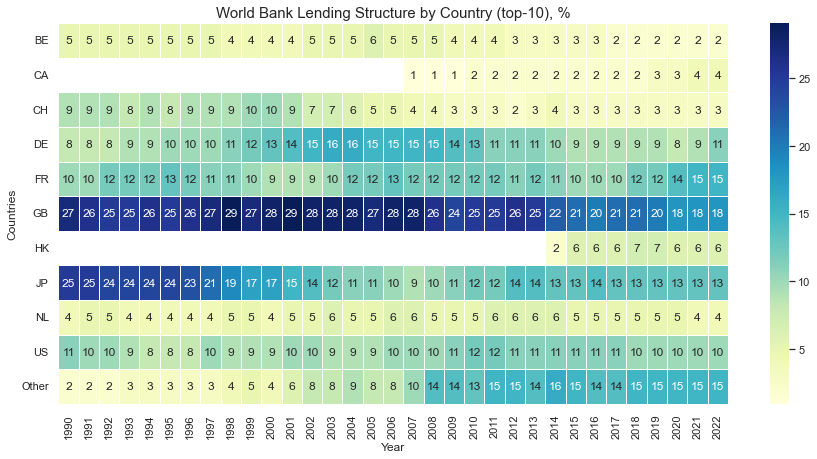

In [17]:
### BIS LBS: STATS: CLAIM LEADERS

gc.collect()
### Stats parameter - leaders to plot:
int_top = 10
### Stats parameter - years to define leaders:
int_term = 10
### Country trade proprotion for each date:
ser_country_value = ser_lbs_claim_ann.groupby(['Date', 'Reporter']).sum().dropna() / 1000000
df_country_part = (ser_country_value / ser_total_volume).round(2).reset_index()
df_country_part['Year'] = df_country_part['Date'].dt.year
ser_country_part = df_country_part.set_index(['Year', 'Reporter']).drop('Date', axis = 1).squeeze().sort_index()
### Limited by term country trade volume:
ser_country_sum = ser_country_value.groupby('Reporter').apply(lambda ser_group: ser_group.iloc[-int_term :].sum()).sort_values(ascending = False)
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Top countries proportions extracting:
ser_country_top = (ser_country_part.loc[All, idx_ave_top] * 100)
ser_country_top.index.set_levels(ser_country_top.index.levels[1].astype('O'), level = 'Reporter', inplace = True) 
### Other countries proportions extracting:
ser_country_other = (ser_country_part.loc[All, idx_ave_other].groupby('Year').sum() * 100)
ser_country_other = pd.concat({'Other': ser_country_other[ser_country_other > 0]}, names = ['Reporter']).swaplevel()
### Data consolidating:
df_to_plot = pd.concat([ser_country_top.unstack('Year').sort_index(), ser_country_other.unstack('Year')], axis = 0)
### Results plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         fmt = '.0f')
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('World Bank Lending Structure by Country (top-' + str(int_top) + '), %', fontsize = 15)
plt.yticks(rotation = 0)
plt.show()   

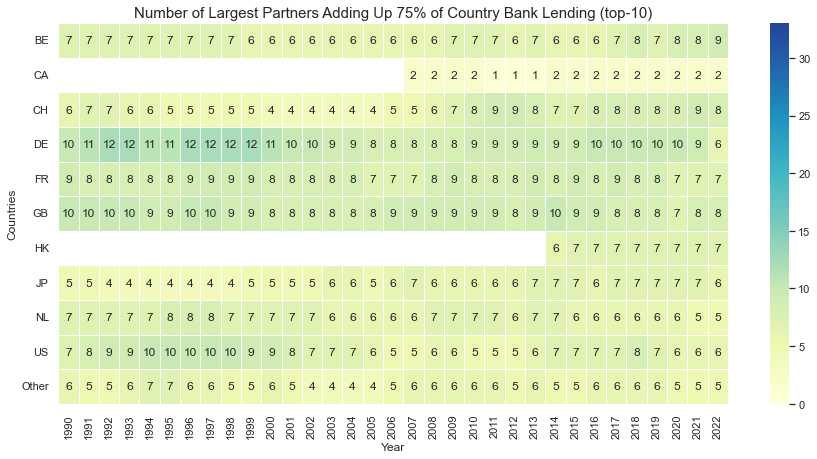

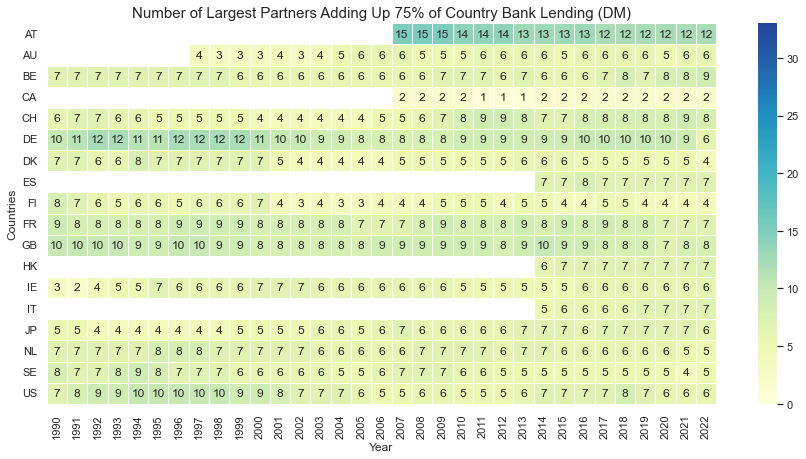

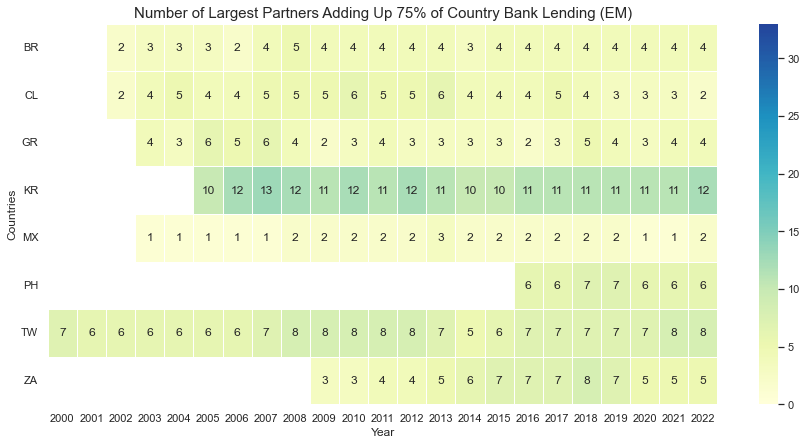

In [18]:
### BIS LBS: STATS: NUMBER OF PARTNERS TO COMPLETE FIXED % OF CLAIMS FOR COUNTRY

gc.collect()
### Defining top-% partners number calculation procedure:
def get_top_partners(ser_group, flo_perc):
    ser_by_partner = ser_group.groupby(['Date', 'Partner']).sum().dropna().sort_values(ascending = False)
    ser_cum_sum = ser_by_partner.cumsum() / ser_by_partner.sum()
    return len(ser_cum_sum[ser_cum_sum < flo_perc]) + 1
### Stats parameter - top bound:
flo_perc = 0.75
### Stats parameter - leaders to plot:
int_top = 10
### Top countries list:
idx_ave_top = ser_country_sum[: int_top].index
### Other countries list:
idx_ave_other = ser_country_sum[int_top :].index
### Partners number calculation for each Date / Reporter pair:
ser_partners = ser_lbs_claim_ann.groupby(['Date', 'Reporter']).apply(get_top_partners, flo_perc).dropna().astype(int)
ser_partners.name = 'Number'
df_partners = ser_partners.to_frame().join(ser_ison_status, on = 'Reporter').reset_index()
### Leaders data extraction for leaders plot:
df_top_part = df_partners[df_partners['Reporter'].isin(idx_ave_top)].copy()
df_top_part['Year'] = df_top_part['Date'].dt.year
df_top_part = df_top_part.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
df_top_part.index = df_top_part.index.astype('O')
### Other countries data extraction for leaders plot:
df_other_part = df_partners[df_partners['Reporter'].isin(idx_ave_other)].groupby('Date')['Number'].mean().astype(int).reset_index()
df_other_part['Year'] = df_other_part['Date'].dt.year
df_other_part = pd.concat({'Other': df_other_part.set_index('Year')}, names = ['Reporter'])
df_other_part = df_other_part.drop('Date', axis = 1).squeeze().unstack('Year')
### Leaders plot data aggregation:
df_to_plot = pd.concat([df_top_part, df_other_part], axis = 0)
### Leaders plot plotting:
plt.figure(figsize = (15, 7))
ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                         center = 20, vmin = 0, vmax = 33)
ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
ax_heatmap.set_title('Number of Largest Partners Adding Up ' + str(int(flo_perc * 100)) + '% of Country Bank Lending (top-' + str(int_top) + ')' , fontsize = 15)
plt.yticks(rotation = 0)
plt.show()
### Region's data plotting:
for iter_region in list_regions[: -1]:
    ### Data extraction:    
    df_to_plot = df_partners.loc[df_partners['Market'] == iter_region].copy()
    df_to_plot['Year'] = df_to_plot['Date'].dt.year
    df_to_plot = df_to_plot.drop(['Date', 'Market'], axis = 1).set_index(['Reporter', 'Year']).squeeze().unstack('Year').sort_index()
    ### Results plotting:
    plt.figure(figsize = (15, 7))
    ax_heatmap = sns.heatmap(df_to_plot, cmap = 'YlGnBu', xticklabels = True, yticklabels = True, cbar = True, linewidth = 0.5, square = False, annot = True, 
                             center = 20, vmin = 0, vmax = 33)
    ax_heatmap.set(xlabel = 'Year', ylabel = 'Countries')
    ax_heatmap.set_title('Number of Largest Partners Adding Up ' + str(int(flo_perc * 100)) + '% of Country Bank Lending (' + iter_region + ')' , fontsize = 15)
    plt.yticks(rotation = 0)
    plt.show()  

In [21]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO COMPARE FLOWS

gc.collect()
### Data loading:
df_lbs_full = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_full_bis_dataset)
df_lbs_full = df_lbs_full[(df_lbs_full['Date'] > date_start) & (df_lbs_full['Date'] <= date_end)].dropna()
ser_claim = df_lbs_full.loc[df_lbs_full['Position'] == 'Claim'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_claim_ann = ser_claim.groupby(['Reporter', 'Partner', 'Position'])\
                         .apply(lambda ser_group: ser_group.droplevel(['Reporter', 'Partner', 'Position']).resample('BY').sum()).reorder_levels([3, 0, 1, 2])
ser_liability = df_lbs_full.loc[df_lbs_full['Position'] == 'Liability'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_liability_ann = ser_liability.groupby(['Reporter', 'Partner', 'Position'])\
                                 .apply(lambda ser_group: ser_group.droplevel(['Reporter', 'Partner', 'Position']).resample('BY').sum()).reorder_levels([3, 0, 1, 2])
### Data concatenation:
ser_flows = pd.concat([ser_claim, ser_liability], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()
ser_flows_ann = pd.concat([ser_claim_ann, ser_liability_ann], axis = 0).to_frame().join(ser_ison_status, on = 'Reporter').set_index('Market', append = True).squeeze()

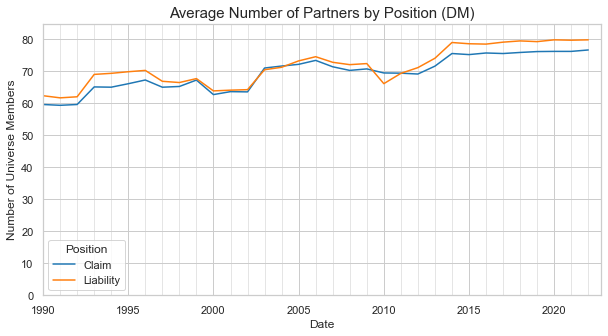

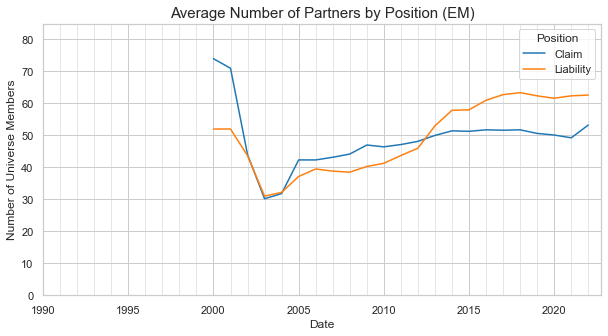

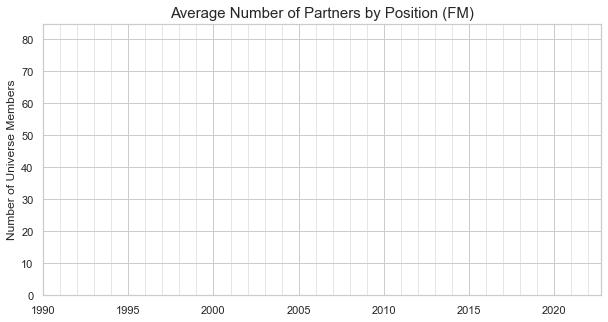

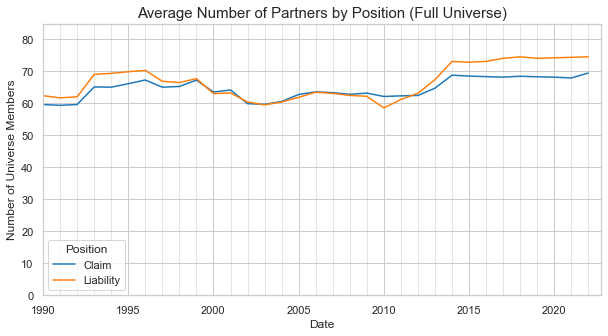

Number of observations for each flow: 
 Position
Claim        155006
Liability    160453
dtype: int64


In [20]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Average partners number for Date / Reporter:
dict_obs_mean = {}
ser_reporter_mean = ser_flows.groupby(['Date', 'Reporter', 'Position', 'Market']).count()
dict_obs_mean['Full Universe'] = ser_reporter_mean.round(0).droplevel('Market').dropna().astype(int)
for iter_region in list_regions[ :-1]:
    dict_obs_mean[iter_region] = ser_reporter_mean.loc[All, All, All, iter_region].round(0).dropna().astype(int)
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_mean, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                               .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Value', hue = 'Position', ci = None)
    ax_partners.set_title('Average Number of Partners by Position (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break
print('Number of observations for each flow:', '\n', ser_flows.unstack('Position').count())

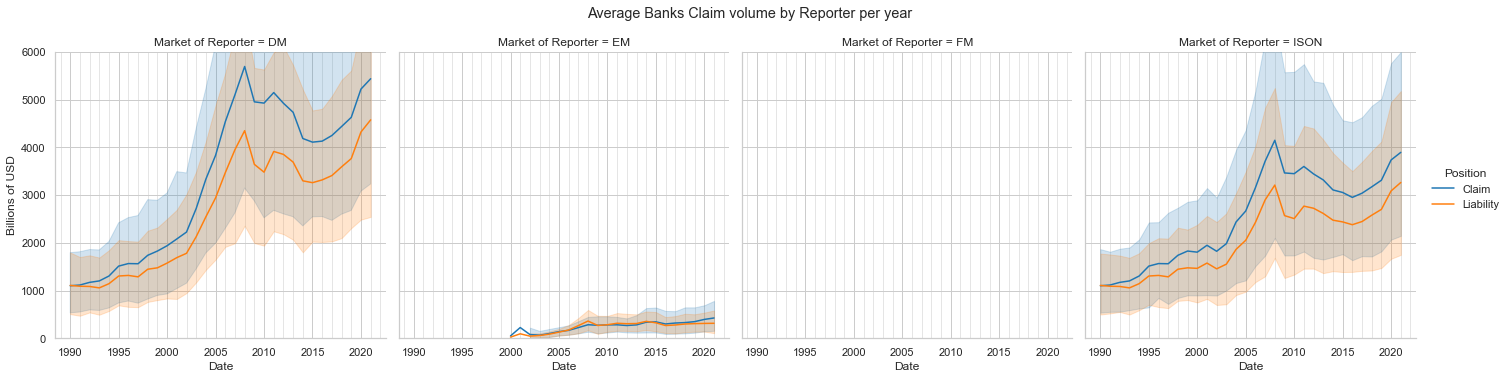

In [10]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: VOLUME COMPARING

gc.collect()
### Trade volume calculation:
dict_obs_sum = {}
ser_reporter_sum = ser_flows_ann.groupby(['Date', 'Reporter', 'Position', 'Market']).sum() / 1000
dict_obs_sum['Full Universe'] = ser_reporter_sum.round(0)[ser_reporter_sum > 0].droplevel('Market').round(2).dropna()
for iter_region in list_regions[: -1]:
    dict_obs_sum[iter_region] = ser_reporter_sum[ser_reporter_sum > 0].loc[All, All, All, iter_region].round(2).dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_obs_sum, axis = 0, names = ['Market of Reporter']).unstack(['Market of Reporter', 'Reporter', 'Position']).resample('YS').last()\
                                                                              .stack(['Market of Reporter', 'Reporter', 'Position']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
fig_mean_obs = sns.relplot(data = df_to_plot, x = 'Date', y = 'Value', col = 'Market of Reporter', col_order = ['DM', 'EM', 'FM', 'Full Universe'], hue = 'Position', 
                           kind = 'line')
fig_mean_obs.fig.suptitle('Average Banks Claim volume by Reporter per year', y = 1.05)
fig_mean_obs.set_ylabels('Billions of USD')
fig_mean_obs.set(ylim = (0, 6000))
### Axes customizing:
for iter_ax in fig_mean_obs.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [112]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: DATA PREPARATION TO INCORPORATE FLOWS

gc.collect()
### Data loading:
df_lbs_full = pd.read_hdf(path_or_buf = str_path_bis_dataset, key = str_full_bis_dataset)
df_lbs_full = df_lbs_full[(df_lbs_full['Date'] > date_start) & (df_lbs_full['Date'] <= date_end)].dropna()
ser_claim = df_lbs_full.loc[df_lbs_full['Position'] == 'Claim'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
ser_liability = df_lbs_full.loc[df_lbs_full['Position'] == 'Liability'].set_index(['Date', 'Reporter', 'Partner', 'Position']).squeeze()
del df_lbs_full
gc.collect()
### Data aggregation:
ser_liability_rev = ser_liability[:]
ser_liability_rev.index.set_names('Partner_Inv', level = 1, inplace = True)
ser_liability_rev.index.set_names('Reporter', level = 2, inplace = True)
ser_liability_rev.index.set_names('Partner', level = 1, inplace = True)
ser_liability_rev = ser_liability_rev.swaplevel('Reporter', 'Partner').sort_index()
df_claim_aug = pd.concat([ser_claim.droplevel('Position'), ser_liability_rev.droplevel('Position')], axis = 1, 
                           names = 'Source Position', keys = ['Claim', 'Liability'])
df_claim_aug = df_claim_aug.join(ser_ison_status, on = 'Reporter').set_index('Market', append = True)
df_claim_aug = df_claim_aug.drop('World', axis = 0, level = 'Reporter').drop('World', axis = 0, level = 'Partner')

In [28]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: ANNUAL DATA PREPARATION

gc.collect()
dict_claim_aug_ann = {}
dict_claim_aug_ann['Claim'] = df_claim_aug['Claim'].groupby(['Reporter', 'Partner', 'Market'])\
                                                    .apply(lambda df_group: df_group.droplevel(['Reporter', 'Partner', 'Market']).resample('BY').sum())\
                                                    .replace({0.0: np.NaN}).dropna().reorder_levels([3, 0, 1, 2]).sort_index()
dict_claim_aug_ann['Liability'] = df_claim_aug['Liability'].groupby(['Reporter', 'Partner', 'Market'])\
                                                        .apply(lambda df_group: df_group.droplevel(['Reporter', 'Partner', 'Market']).resample('BY').sum())\
                                                        .replace({0.0: np.NaN}).dropna().reorder_levels([3, 0, 1, 2]).sort_index()
df_claim_aug_ann = pd.concat(dict_claim_aug_ann, axis = 1)
del dict_claim_aug_ann

In [13]:
### TEMP

display(df_claim_aug.loc[('2021', 'US', 'IL', All), All].sum())
display(df_claim_aug_ann.loc[('2021-12-31', 'US', 'IL', All), All])

Claim        13038.0
Liability        0.0
dtype: float64

Claim  Liability
Date       Reporter Partner Market                    
2021-12-31 US       IL      DM      13038.0        NaN

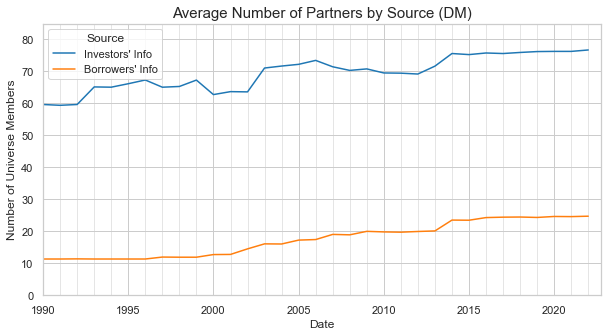

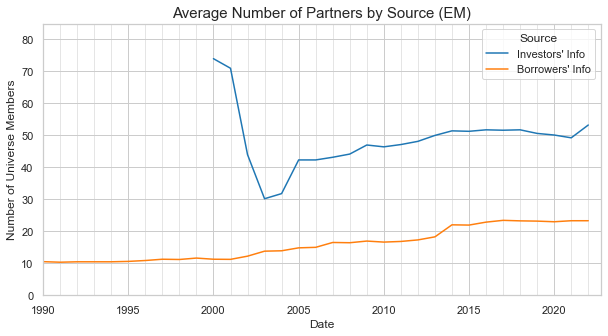

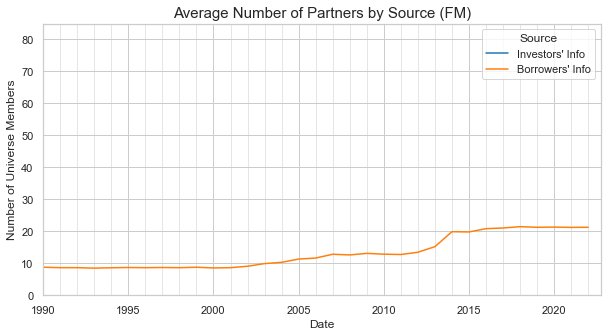

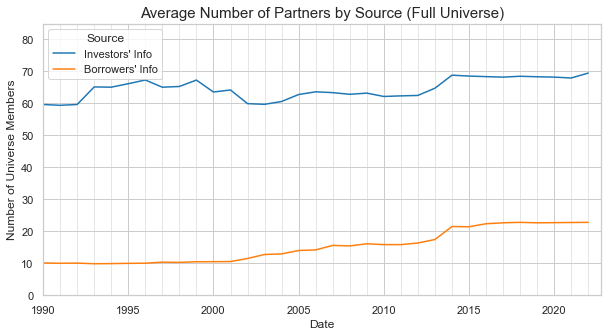

In [113]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: COVERAGE COMPARING

gc.collect()
### Coverage data container:
dict_unique_mean = {}
### Partners number calculation:
dict_unique_mean['Investors\' Info'] = df_claim_aug['Claim'].groupby(['Date', 'Reporter', 'Market']).count()
dict_unique_mean['Borrowers\' Info'] = df_claim_aug['Liability'].groupby(['Date', 'Reporter', 'Market']).count()
ser_unique_mean = pd.concat(dict_unique_mean, axis = 0, names = ['Source']).round(0).astype(int)
ser_unique_mean = ser_unique_mean[ser_unique_mean > 0.0]
ser_unique_mean.name = 'Number of Partners'
del dict_unique_mean
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_mean.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_mean.loc[All, All, All, iter_region].dropna()
### Average partners number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Investor']).unstack(['Market of Investor', 'Reporter', 'Source']).resample('YS').last()\
                                                                                    .stack(['Market of Investor', 'Reporter']).dropna(how = 'all')\
                                                                                    .stack('Source').reset_index()
df_to_plot.rename({0: 'Number of Partners'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_partners = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Number of Partners', hue = 'Source', 
                               hue_order = ['Investors\' Info', 'Borrowers\' Info'], ci = None)
    ax_partners.set_title('Average Number of Partners by Source (' + iter_region + ')', fontsize = 15)
    ax_partners.set(xlim = (date_start, date_end), ylabel = 'Number of Universe Members', ylim = (0, 85))
    ### Major ticker options:    
    ax_partners.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_partners.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_partners.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_partners.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()

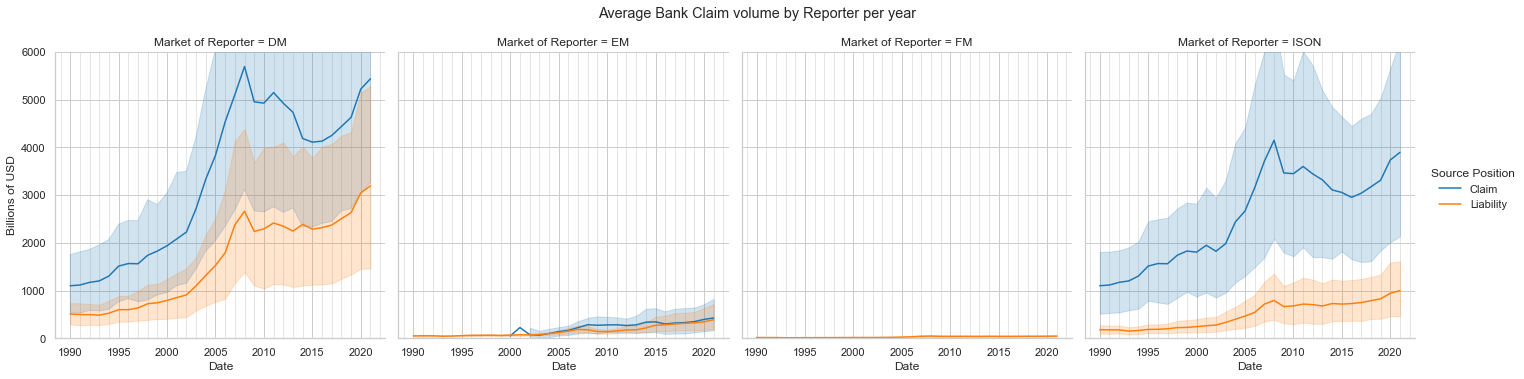

In [15]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: TOTAL OBSERVATIONS VOLUME

gc.collect()
### Valome calculation:
dict_unique_sum = {}
dict_unique_sum['Claim'] = df_claim_aug_ann['Claim'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_unique_sum['Liability'] = df_claim_aug_ann['Liability'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_sum = pd.concat(dict_unique_sum, axis = 0, names = ['Source Position']).round(2)
ser_unique_sum.name = 'Claim volume'
del dict_unique_sum
gc.collect()
dict_unique_source = {}
dict_unique_source['Full Universe'] = ser_unique_sum[ser_unique_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_source[iter_region] = ser_unique_sum[ser_unique_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average commodities number plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_unique_source, axis = 0, names = ['Market of Reporter'])\
               .unstack(['Market of Reporter', 'Reporter', 'Source Position']).resample('YS').last()\
               .stack(['Market of Reporter', 'Reporter', 'Source Position']).reset_index()
df_to_plot.rename({0: 'Claim volume'}, axis = 1, inplace = True)
fig_mean_unique = sns.relplot(data = df_to_plot, x = 'Date', y = 'Claim volume', col = 'Market of Reporter', hue = 'Source Position', 
                              hue_order = ['Claim', 'Liability'], kind = 'line')
fig_mean_unique.fig.suptitle('Average Bank Claim volume by Reporter per year', y = 1.05)
fig_mean_unique.set_ylabels('Billions of USD')
fig_mean_unique.set(ylim = (0, 6000))
### Axes customizing:
for iter_ax in fig_mean_unique.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5) 	
plt.show()

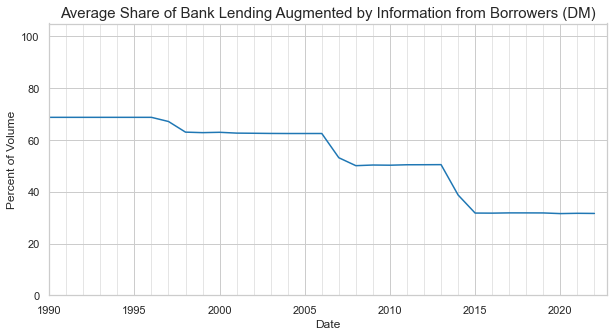

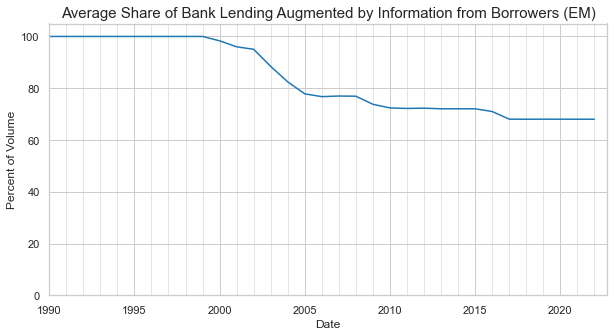

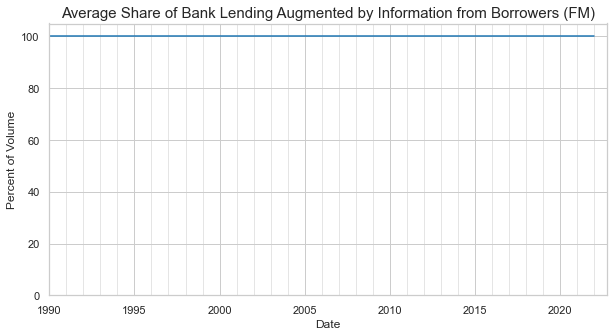

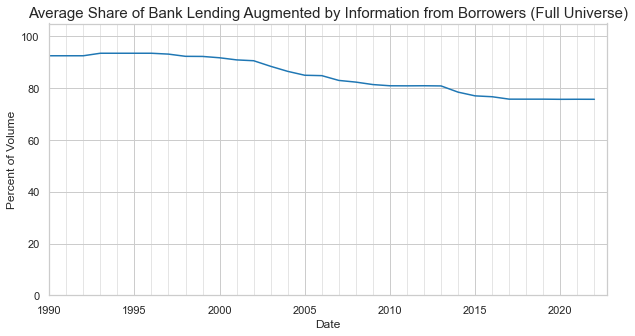

In [26]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: UNIQUE INVERTED LIABILITIES VOLUME

gc.collect()
### Unique inverted import data filtering:
ser_liability_unique = df_claim_aug.loc[df_claim_aug['Claim'].isna() & df_claim_aug['Liability'].notna(), 'Liability']\
                                 .groupby(['Date', 'Reporter', 'Market']).sum()
ser_liability_unique_ann = ser_liability_unique.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_liability_unique_ann.name = 'Added Volume'
### Unique inverted import by Market grouping:
dict_unique_liability = {}
dict_unique_liability['Full Universe'] = ser_liability_unique_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_unique_liability[iter_region] = ser_liability_unique_ann.loc[All, All, iter_region].dropna()
ser_liability_isoned = pd.concat(dict_unique_liability, axis = 0, names = ['Market of Investor'])
### Total export data filtering:
ser_claim_total = df_claim_aug['Claim'].groupby(['Date', 'Reporter', 'Market']).sum()
ser_claim_total_ann = ser_claim_total.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_claim_total_ann.name = 'Claim Volume'
### Total export by Market grouping:
dict_claim_total = {}
dict_claim_total['Full Universe'] = ser_claim_total_ann.droplevel('Market').dropna()
for iter_region in list_regions:
    dict_claim_total[iter_region] = ser_claim_total_ann.loc[All, All, iter_region].dropna()
ser_claim_isoned = pd.concat(dict_claim_total, axis = 0, names = ['Market of Investor'])
### Share of Export Augmented by Information from Importers:
ser_share = (ser_liability_isoned.fillna(0) / (ser_liability_isoned.fillna(0) + ser_claim_isoned.fillna(0)) * 100).round(2)
### Dataset to draw:
df_to_plot = ser_share.unstack(['Market of Investor', 'Reporter']).resample('YS').last().stack(['Market of Investor', 'Reporter']).reset_index()
df_to_plot.rename({0: 'Share Added'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_share = sns.lineplot(data = df_to_plot[df_to_plot['Market of Investor'] == iter_region], x = 'Date', y = 'Share Added', ci = None)
    ax_share.set_title('Average Share of Bank Lending Augmented by Information from Borrowers (' + iter_region + ')', fontsize = 15)
    ax_share.set(xlim = (date_start, date_end), ylabel = 'Percent of Volume', ylim = (0, 105))
    ### Major ticker options:    
    ax_share.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_share.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_share.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_share.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()

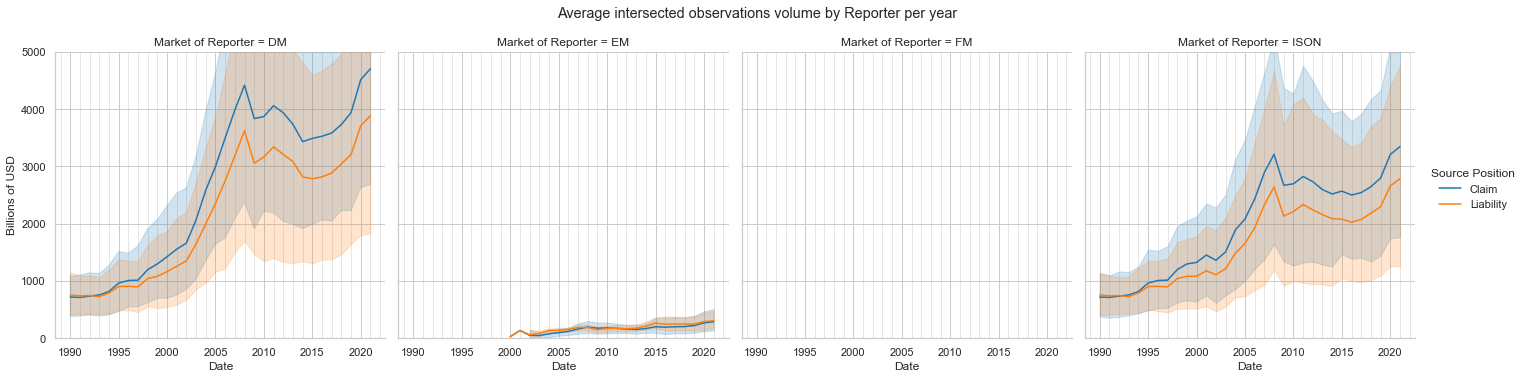

In [17]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: INTERSECTED OBSERVATIONS VOLUME

gc.collect()

dict_inter_sum = {}
dict_inter_sum['Claim'] = df_claim_aug.dropna()['Claim'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_inter_sum['Claim'] = dict_inter_sum['Claim'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
dict_inter_sum['Liability'] = df_claim_aug.dropna()['Liability'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
dict_inter_sum['Liability'] = dict_inter_sum['Liability'].unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_inter_sum = pd.concat(dict_inter_sum, axis = 0, names = ['Source Position']).round(2)
ser_inter_sum.name = 'Bank Claim volume'
del dict_inter_sum
gc.collect()
dict_inter_source = {}
dict_inter_source['Full Universe'] = ser_inter_sum[ser_inter_sum > 0.0].droplevel('Market').dropna()
for iter_region in list_regions[: -1]:
    dict_inter_source[iter_region] = ser_inter_sum[ser_inter_sum > 0.0].loc[All, All, All, iter_region].dropna()
### Average export volume plotting:
sns.set_style('whitegrid')
sns.set_context('notebook')
df_to_plot = pd.concat(dict_inter_source, axis = 0, names = ['Market of Reporter'])\
               .unstack(['Market of Reporter', 'Reporter', 'Source Position']).resample('YS').last()\
               .stack(['Market of Reporter', 'Reporter', 'Source Position']).reset_index()
df_to_plot.rename({0: 'Bank Claim volume'}, axis = 1, inplace = True)
fig_mean_inter = sns.relplot(data = df_to_plot, x = 'Date', y = 'Bank Claim volume', col = 'Market of Reporter', col_order = ['DM', 'EM', 'FM', 'Full Universe'], 
                             hue = 'Source Position', hue_order = ['Claim', 'Liability'], kind = 'line')
fig_mean_inter.fig.suptitle('Average intersected observations volume by Reporter per year', y = 1.05)
fig_mean_inter.set_ylabels('Billions of USD')
fig_mean_inter.set(ylim = (0, 5000))
### Axes customizing:
for iter_ax in fig_mean_inter.axes.ravel():
    ### Major ticker options:    
    iter_ax.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    iter_ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    iter_ax.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    iter_ax.grid(visible = True, which = 'minor', linewidth = 0.5)
plt.show()

In [18]:
### TEMP

gc.collect()
#print(ser_inter_sum[ser_inter_sum > 0.0].sum())
#print(ser_unique_sum[ser_unique_sum > 0.0].sum())
ser_inter_exp = df_claim_aug.dropna()['Claim'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_inter_exp = ser_inter_exp.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
ser_total_exp = df_claim_aug_ann['Claim'].groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = df_claim_aug.loc[df_claim_aug['Claim'].notna() & df_claim_aug['Liability'].isna(), 'Claim']\
                                         .groupby(['Date', 'Reporter', 'Market']).sum() / 1000
ser_unique_exp = ser_unique_exp.unstack(['Reporter', 'Market']).resample('BY').sum().stack(['Reporter', 'Market'])
print('Total:', ser_total_exp.sum())
print('Intersected:', ser_inter_exp.sum())
print('Unique:', ser_unique_exp.sum())
print('Sum:', ser_inter_exp.sum() + ser_unique_exp.sum())
print('Unique:', ser_unique_exp.sum() / ser_total_exp.sum() * 100)

Total: 1667429.5564940001
Intersected: 1317483.678997
Unique: 349945.877497
Sum: 1667429.556494
Unique: 20.987146121651417


In [29]:
### BIS LBS: LIABILITY DATA INCORPORATION:

### Combining Export & Import data:
df_claim_aug['Claim_Augmented'] = df_claim_aug['Claim'].combine_first(df_claim_aug['Liability'])

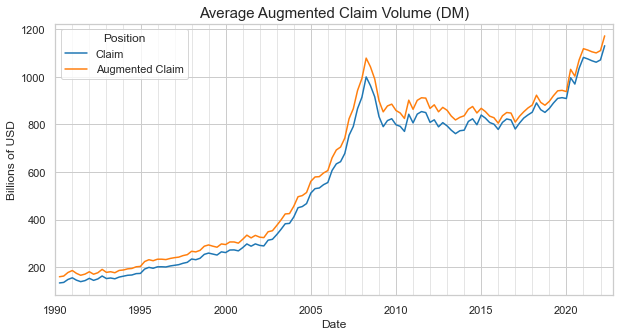

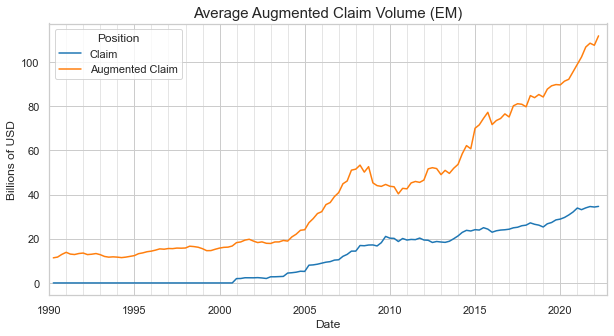

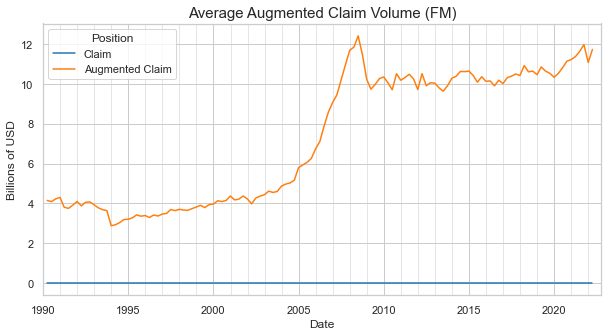

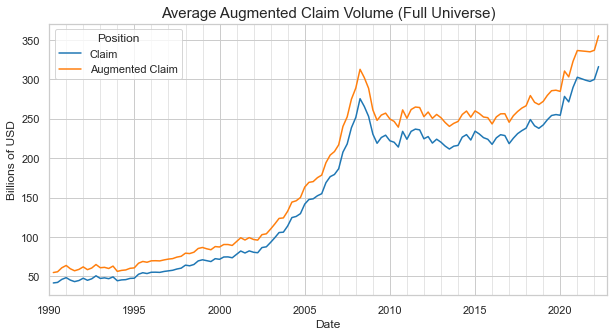

In [30]:
### BIS LBS: LIABILITY OBSERVATIONS INCORPORATION: VISUALIZATION

gc.collect()

df_options_sum = df_claim_aug.groupby(['Date', 'Reporter', 'Market']).sum() / 1000
df_options_sum.columns = ['Claim', 'Liability', 'Augmented Claim']
ser_options_sum = df_options_sum[['Claim', 'Augmented Claim']].reset_index()\
                        .melt(id_vars = ['Date', 'Reporter', 'Market'], var_name = 'Position', value_name = 'Claim_Volume')\
                        .set_index(['Date', 'Reporter', 'Market', 'Position']).squeeze()
### Regions data aggregation:
dict_options_sum = {}
dict_options_sum['Full Universe'] = ser_options_sum.dropna().droplevel('Market')
for iter_region in list_regions:
    dict_options_sum[iter_region] = ser_options_sum.dropna().loc[All, All, iter_region, All]
### Export volume plotting:
df_to_plot = pd.concat(dict_options_sum, axis = 0, names = ['Market of Reporter']).reset_index()
df_to_plot.rename({0: 'Value'}, axis = 1, inplace = True)
### Region's data plotting:
for iter_region in list_regions + ['Full Universe']:
    ### Style coinfiguration:
    sns.set_style('whitegrid')
    plt.figure(figsize = (10, 5))
    sns.set_context('notebook')
    ### Plot creating:
    ax_volume = sns.lineplot(data = df_to_plot[df_to_plot['Market of Reporter'] == iter_region], x = 'Date', y = 'Claim_Volume', hue = 'Position', ci = None)
    ax_volume.set_title('Average Augmented Claim Volume (' + iter_region + ')', fontsize = 15)
    ax_volume.set(xlim = (date_start, date_end), ylabel = 'Billions of USD')
    ### Major ticker options:    
    ax_volume.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
    ax_volume.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
    ### Minor ticker options:        
    ax_volume.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
    ax_volume.grid(visible = True, which = 'minor', linewidth = 0.5) 
    ### Plot drawing:
    plt.show()
#    break

In [68]:
### BIS LBS: IMPORT DATA INCORPORATION: RESULTS SAVING

### Dataset saving:
df_claim_aug = df_claim_aug.astype('float32')
df_claim_aug = df_claim_aug.reset_index()
df_claim_aug = df_claim_aug.astype({'Reporter': 'category', 'Partner': 'category', 'Market': 'category'})
df_claim_aug.to_hdf(path_or_buf = str_path_bis_lbs_combined, key = str_full_bis_lbs_combined, mode = 'w', format = 'table')
#del df_claim_aug
#gc.collect()

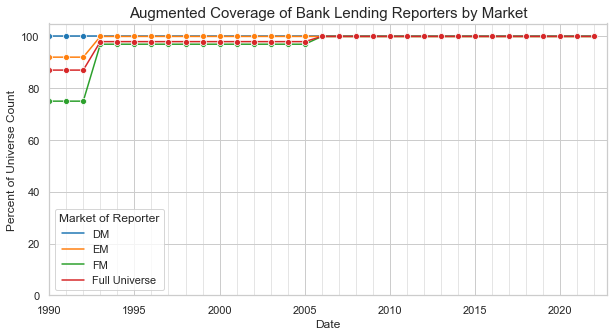

In [96]:
### BIS LBS: NUMBER OF REPORTERS CHANGE

dict_reporters = {}
### Data loading:
ser_bis_lbs = pd.read_hdf(path_or_buf = str_path_bis_lbs_combined, key = str_full_bis_lbs_combined).set_index(['Date', 'Reporter', 'Partner', 'Market']).sort_index()\
                                                                                                                        ['Claim_Augmented'].dropna()
### Total reporters number:
ser_iter_reporters = ser_bis_lbs.groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
ser_iter_reporters.name = 'Percent'
dict_reporters['Full Universe'] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len['Full Universe'] * 100).astype(int)
### Region's reporters number:
for iter_region in list_regions:
    ser_iter_reporters = ser_bis_lbs[:, :, :, iter_region].groupby('Date').apply(lambda ser_date: len(ser_date.index.get_level_values('Reporter').unique()))
    ser_iter_reporters.name = 'Percent'
    dict_reporters[iter_region] = (ser_iter_reporters.resample('BY').last().dropna() / dict_ison_len[iter_region] * 100).astype(int)
### Data consolidating:    
df_reporters = pd.concat(dict_reporters, axis = 0).unstack(0).resample('YS').last().stack(0).reset_index()
df_reporters.columns = ['Date', 'Market of Reporter', 'Percent']
df_to_plot = df_reporters[df_reporters['Date'] < date_end]
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_reporters = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Percent', hue = 'Market of Reporter', hue_order = list_regions + ['Full Universe'], marker = 'o')
ax_reporters.set_title('Augmented Coverage of Bank Lending Reporters by Market', fontsize = 15)
ax_reporters.set(xlim = (date_start, date_end), ylim = (0, 105), ylabel = 'Percent of Universe Count')
### Major ticker options:    
ax_reporters.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_reporters.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_reporters.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_reporters.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

Last date reported: 2022-03-31 00:00:00


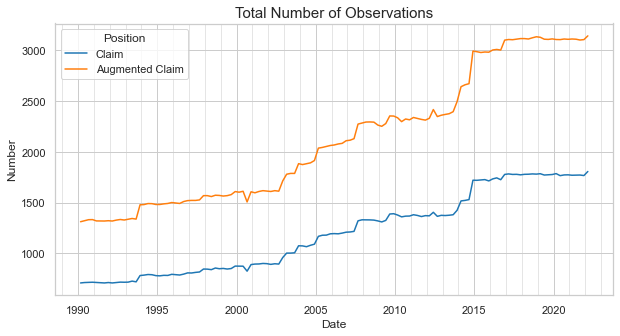

In [31]:
### BIS LBS: DATA FRESHNESS

df_bis_lbs = pd.read_hdf(path_or_buf = str_path_bis_lbs_combined, key = str_full_bis_lbs_combined).set_index(['Date', 'Reporter', 'Partner'])\
                                                                                                      .sort_index()[['Claim', 'Claim_Augmented']]
df_bis_lbs.columns = ['Claim', 'Augmented Claim']
ser_bis_lbs = df_bis_lbs.stack().sort_index()
ser_bis_lbs.index.names = ['Date', 'Reporter', 'Partner', 'Position']
print('Last date reported:', ser_bis_lbs.index.get_level_values('Date').max())
df_to_plot = ser_bis_lbs.groupby(['Date', 'Position']).count().sort_index().unstack('Position').resample('MS').last().stack('Position').reset_index()
df_to_plot.rename({0: 'Number'}, axis = 1, inplace = True)
### Results plotting:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.set_context('notebook')
ax_number = sns.lineplot(data = df_to_plot, x = 'Date', y = 'Number', hue = 'Position', hue_order = ['Claim', 'Augmented Claim'])
ax_number.set_title('Total Number of Observations', fontsize = 15)
### Major ticker options:    
ax_number.get_xaxis().set_major_locator(mdates.YearLocator(base = 5))                             
ax_number.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y'))       
### Minor ticker options:        
ax_number.get_xaxis().set_minor_locator(mdates.YearLocator(base = 1)) 
ax_number.grid(visible = True, which = 'minor', linewidth = 0.5) 
plt.show()

In [44]:
### IMF CDIS: ALTERNATIVE BILATERAL DIRECT INVESTMENT POSITIONS RESEARCH

In [45]:
### IMF CDIS: GENERAL DATA PREPARATION

### Constants:
All = slice(None)
dict_request_headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
str_imf_base_url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/'
str_imf_dataflow_add = 'DataFlow'
str_imf_datastructure_add = 'DataStructure/'
str_imf_codelist_add = 'CodeList/'
str_imf_dataset_add = 'CompactData/'
int_seconds_to_sleep = 5
int_imf_country_limit = 30

In [46]:
### IMF CDIS: REQUESTS SESSION INITIALIZING

request_session = requests.Session()
### For avoiding data request errors from IMF Data Service:
request_session.headers.update(dict_request_headers)

In [47]:
### IMF CDIS: DATAFLOW SEARCHING

obj_imf_dataflow_list = request_session.get(str_imf_base_url + str_imf_dataflow_add).json()
df_imf_dataflow = pd.DataFrame(obj_imf_dataflow_list['Structure']['Dataflows']['Dataflow'])
df_imf_dataflow = df_imf_dataflow.assign(Description = df_imf_dataflow['Name'].apply(pd.Series)['#text'].values)[['@id', 'Description']]
ser_imf_dataflow = df_imf_dataflow.set_index('@id', drop = True).squeeze()
### Searching DataFlow code for further requests:
str_imf_cdis_id = ser_imf_dataflow[ser_imf_dataflow.str.contains('CDIS')].index[0].replace('DS-', '')
print(str_imf_cdis_id)

CDIS


In [48]:
### IMF CDIS: DATASTRUCTURE SEARCHING

obj_imf_cdis_structure = request_session.get(str_imf_base_url + str_imf_datastructure_add + str_imf_cdis_id).json()
df_imf_cdis_params = pd.DataFrame(obj_imf_cdis_structure['Structure']['KeyFamilies']['KeyFamily']['Components']['Dimension'])\
                                [['@conceptRef', '@codelist', '@isFrequencyDimension']]
### Receiving DataFlow parameters and code lists for each of them:
print(df_imf_cdis_params)

        @conceptRef          @codelist @isFrequencyDimension
0              FREQ            CL_FREQ                  true
1          REF_AREA       CL_AREA_CDIS                   NaN
2         INDICATOR  CL_INDICATOR_CDIS                   NaN
3  COUNTERPART_AREA       CL_AREA_CDIS                   NaN


In [49]:
### IMF CDIS: CODES DESCRIPTION SEARCHING

for int_counter, str_param_code in enumerate(df_imf_cdis_params['@codelist']):
    if (int_counter == 2):
        time.sleep(int_seconds_to_sleep)    
        obj_imf_cdis_param = request_session.get(str_imf_base_url + str_imf_codelist_add + str_param_code).json()
        df_imf_cdis_param =  pd.DataFrame(obj_imf_cdis_param['Structure']['CodeLists']['CodeList']['Code'])
        ### Receiving values for each code list:
        df_imf_cdis_param = df_imf_cdis_param.assign(Text = df_imf_cdis_param['Description'].apply(pd.Series)['#text'].values)[['@value', 'Text']]
        print(int_counter, ':', df_imf_cdis_params.iloc[int_counter, All]['@conceptRef'], ':', str_param_code, ':\n', df_imf_cdis_param.head())
#df_imf_cdis_param.to_excel('Data_Files/Test_Files/cdis_indicators.xlsx')
str_cdis_freq = 'A' # 'B' # 
str_cdis_outward_asset_indicator = 'IOWFA_BP6_USD' 
str_cpis_outward_liability_indicator = 'IOWFL_BP6_USD'
list_ison_countries = sorted(list(map(str, ser_ison_membership.index.get_level_values(1).unique())))

2 : INDICATOR : CL_INDICATOR_CDIS :
              @value                                               Text
0  IIWDA_DV_BP6_USD  Inward Debt Instruments Assets Positions (Gros...
1     IIWDA_BP6_XDC  Inward Debt Instruments Assets Positions (Gros...
2     IIWDA_BP6_EUR  Inward Debt Instruments Assets Positions (Gros...
3     IIWDA_BP6_USD  Inward Debt Instruments Assets Positions (Gros...
4     IIWDL_BP6_XDC  Inward Debt Instruments Liabilities Positions ...


In [57]:
### IMF CDIS OUTWARD DIRECTION: ASSET DATASET RETRIEVING

list_cdis_bilateral = [] # List of bilateral dataframes for future concatenation
str_cdis_const_url = str_imf_base_url + str_imf_dataset_add + str_imf_cdis_id + '/' # Beggining of request URL
### Looping for reporter country groups:
for int_ison_reporter_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
    str_cdis_reporters = '+'.join(list_ison_countries[int_ison_reporter_part * int_imf_country_limit : (int_ison_reporter_part + 1) * int_imf_country_limit])
    ### Looping for partner country groups:
    for int_ison_partner_part in range(0, - (len(list_ison_countries) // ( - int_imf_country_limit))):
        str_cdis_partners = '+'.join(list_ison_countries[int_ison_partner_part * int_imf_country_limit : (int_ison_partner_part + 1) * int_imf_country_limit])    
        ### Generating complete request URL:
        str_cdis_full_url = str_cdis_const_url + \
                            '.'.join([str_cdis_freq, str_cdis_reporters, str_cdis_outward_asset_indicator, str_cdis_partners])
        ### Receiving CPIS dataset from IMF API:
        print(int_ison_reporter_part * int_imf_country_limit, '-', (int_ison_reporter_part + 1) * int_imf_country_limit, ' / ',
              int_ison_partner_part * int_imf_country_limit, '-', (int_ison_partner_part + 1) * int_imf_country_limit)
        obj_cdis_set = request_session.get(str_cdis_full_url)
        print(len(pd.DataFrame(obj_cdis_set.json()['CompactData']['DataSet']['Series'])['@REF_AREA'].unique()))        
        print(sorted(pd.DataFrame(obj_cdis_set.json()['CompactData']['DataSet']['Series'])['@REF_AREA'].unique()))
        break
#    break

0 - 30  /  0 - 30
14
['AT', 'BD', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB', 'GR']
30 - 60  /  0 - 30
15
['HK', 'HU', 'IE', 'IS', 'IT', 'KR', 'KZ', 'LT', 'LV', 'MA', 'MT', 'MU', 'MX', 'NG', 'NO']
60 - 90  /  0 - 30
11
['PE', 'PH', 'PK', 'PL', 'PT', 'RU', 'SE', 'SI', 'SK', 'TH', 'ZA']


In [59]:
### TEMP

obj_cdis_set.json()['CompactData']['DataSet']['Series'][: 5]

[{'@FREQ': 'A',
  '@REF_AREA': 'PL',
  '@INDICATOR': 'IOWFA_BP6_USD',
  '@COUNTERPART_AREA': 'CN',
  '@UNIT_MULT': '6',
  '@TIME_FORMAT': 'P1Y',
  'Obs': [{'@TIME_PERIOD': '2013', '@OBS_VALUE': '13.2802124833997'},
   {'@TIME_PERIOD': '2014', '@OBS_VALUE': '9.40921532846715'},
   {'@TIME_PERIOD': '2015', '@OBS_VALUE': '10.2278844428495'},
   {'@TIME_PERIOD': '2016', '@OBS_VALUE': '10.6477161247099'},
   {'@TIME_PERIOD': '2017', '@OBS_VALUE': '13.960302185965'},
   {'@TIME_PERIOD': '2018', '@OBS_VALUE': '10.6657446072825'},
   {'@TIME_PERIOD': '2019', '@OBS_VALUE': '7.82052294810017'},
   {'@TIME_PERIOD': '2020', '@OBS_VALUE': '14.4210302256279'},
   {'@TIME_PERIOD': '2021', '@OBS_VALUE': '15.2709359605911'}]},
 {'@FREQ': 'A',
  '@REF_AREA': 'SI',
  '@INDICATOR': 'IOWFA_BP6_USD',
  '@COUNTERPART_AREA': 'DE',
  '@UNIT_MULT': '6',
  '@TIME_FORMAT': 'P1Y',
  'Obs': [{'@TIME_PERIOD': '2009', '@OBS_VALUE': '1.231734810684'},
   {'@TIME_PERIOD': '2010', '@OBS_VALUE': '3.348477127362'},
   {'@

In [29]:
### TEMP

https://stats.oecd.org/Index.aspx?DataSetCode=QASA_7II_INDIC

https://data.oecd.org/searchresults/?hf=20&b=0&r=%2Bf%2Ftype%2Fdatasets&q=Institutional+Investors+Statistics&l=en&s=score

SyntaxError: invalid syntax (Temp/ipykernel_2224/3509883556.py, line 3)